# Import Dataset, drop 0 columns

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def clean_csv_files(folder_path):
  cleaned_dataframes = {}

  # List of columns to drop
  columns_to_drop = [
      "status", "start_date", "end_date", "window_start_date", "window_end_date",
      "emails", "devs", "emails_thread_starter", "emails_thread_starter_word_count",
      "emails_thread_starter_characters", "emails_threads", "emails_threads_word_count",
      "emails_threads_characters", "emails_no_replies", "emails_no_replies_word_count",
      "emails_no_replies_characters", "emails_jira", "most_complex_unit_loc",
      "most_complex_unit_mcabe_index", "total_number_of_files", "number_of_files_main",
      "lines_of_code_main", "number_of_files_test", "lines_of_code_test",
      "test_vs_main_lines_of_code_percentage", "number_of_files_generated",
      "lines_of_code_generated", "number_of_files_build_and_deployment",
      "lines_of_code_build_and_deployment", "negligible_risk_file_size_count",
      "low_risk_file_size_count", "medium_risk_file_size_count", "high_risk_file_size_count",
      "very_high_risk_file_size_count", "negligible_risk_file_size_loc", "low_risk_file_size_loc",
      "medium_risk_file_size_loc", "high_risk_file_size_loc", "very_high_risk_file_size_loc",
      "number_of_units", "lines_of_code_in_units", "lines_of_code_outside_units",
      "unit_size_negligible_risk_loc", "unit_size_negligible_risk_count", "unit_size_low_risk_loc",
      "unit_size_low_risk_count", "unit_size_medium_risk_loc", "unit_size_medium_risk_count",
      "unit_size_high_risk_loc", "unit_size_high_risk_count", "unit_size_very_high_risk_loc",
      "unit_size_very_high_risk_count", "conditional_complexity_negligible_risk_loc",
      "conditional_complexity_negligible_risk_count", "conditional_complexity_low_risk_loc",
      "conditional_complexity_low_risk_count", "conditional_complexity_medium_risk_loc",
      "conditional_complexity_medium_risk_count", "conditional_complexity_high_risk_loc",
      "conditional_complexity_high_risk_count", "conditional_complexity_very_high_risk_loc",
      "conditional_complexity_very_high_risk_count", "conditional_complexity_high_plus_risk_count",
      "conditional_complexity_high_plus_risk_loc", "number_of_contributors",
      "duplication_number_of_duplicates", "duplication_number_of_files_with_duplicates",
      "duplication_number_of_duplicated_lines", "duplication_percentage", "unit_duplicates_count", "releases"
  ]

  for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
      file_path = os.path.join(folder_path, filename)

      # Load CSV file
      df = pd.read_csv(file_path)

      # Drop specified columns
      df = df.drop(
          columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

      key = os.path.splitext(filename)[0]
      cleaned_dataframes[key] = df

  return cleaned_dataframes

folder_path = "scraper-output"
cleaned_data = clean_csv_files(folder_path)


# Clean data

In [2]:
import pandas as pd
import numpy as np

for key, df in cleaned_data.items():
    # Replace NaN values in numerical columns with 0
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(0)

    # Replace NaN and blank/empty values in 'programming_lang' column with the mode
    if 'programming_lang' in df.columns:
        # Calculate mode value
        mode_value = df['programming_lang'].mode()[0] if not df['programming_lang'].mode().empty else 'Unknown'
        
        # Replace NaN values with the mode
        df['programming_lang'] = df['programming_lang'].fillna(mode_value)
        
        # Replace blank or whitespace-only values with the mode
        df['programming_lang'] = df['programming_lang'].replace(r'^\s*$', mode_value, regex=True)

In [3]:
status_data = pd.read_csv("project-status.csv")
status_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   project  154 non-null    object
 1   status   154 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [4]:
# Filter out projects with fewer than 10 data points
cleaned_data = {project: df for project,
                df in cleaned_data.items() if len(df) >= 10}

def merge_status(cleaned_data, status_data):
  status_dict = status_data.set_index('project')['status'].to_dict()
  for project, df in cleaned_data.items():
    df['status'] = status_dict.get(project, 'Unknown')
  return cleaned_data

cleaned_data = merge_status(cleaned_data, status_data)


# Transformer based model

In [5]:
import copy
cleaned_data_transformer = copy.deepcopy(cleaned_data)
for key, df in cleaned_data_transformer.items():
  cleaned_data_transformer[key] = df[["commits", "authors",
                                      "committers", "minor_contributors", "major_contributors", "status"]]

In [6]:
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data Preprocessing
max_length = max(df.shape[0] for df in cleaned_data_transformer.values())

data = []
labels = []

for project, df in cleaned_data_transformer.items():
  text = df.drop(columns=['status']).astype(str).agg(' '.join, axis=1).tolist()
  label = df['status'].iloc[0]
  labels.append(label)
  while len(text) < max_length:
    text.append("PAD")
  data.append(" ".join(text))

# Retired=0, Graduated=1
labels = [0 if label == 'Retired' else 1 for label in labels]

# Custom Dataset Class


class ProjectDataset(Dataset):
  def __init__(self, data, labels, tokenizer, max_length):
    self.data = data
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, item):
    text = self.data[item]
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
    }


# Create dataset
dataset = ProjectDataset(data, labels, tokenizer, max_length)

# Train/Test/Validation split (70/20/10)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42, shuffle=True)

test_data, val_data, test_labels, val_labels = train_test_split(
    test_val_data, test_val_labels, test_size=1/3, stratify=test_val_labels, random_state=42, shuffle=True)

train_dataset = ProjectDataset(train_data, train_labels, tokenizer, max_length)
test_dataset = ProjectDataset(test_data, test_labels, tokenizer, max_length)
val_dataset = ProjectDataset(val_data, val_labels, tokenizer, max_length)


def train_model(model, train_loader, val_loader, optimizer, epochs=30, patience=5):
  best_val_loss = float('inf')
  patience_counter = 0

  for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
      optimizer.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = model(input_ids=input_ids,
                      attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      logits = outputs.logits

      total_train_loss += loss.item()
      _, predicted = torch.max(logits, dim=1)
      correct_train += (predicted == labels).sum().item()
      total_train += labels.size(0)

      loss.backward()
      optimizer.step()

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0

    with torch.no_grad():
      for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()

        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)
        correct_val += (predicted == labels).sum().item()
        total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val
    print(f"Epoch {epoch+1} - Train Loss: {total_train_loss/len(train_loader)} | Train Acc: {correct_train/total_train}")
    print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss} | Val Acc: {val_acc}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Model training and evaluation

best_hyperparams = None
best_test_acc = 0.0

def execute_hyperparameter_combination(dropout, weight_decay, lr, batch_size):
  global best_hyperparams, best_test_acc
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  model = BertForSequenceClassification.from_pretrained(
      'bert-base-uncased',
      num_labels=2,
      hidden_dropout_prob=dropout,
      attention_probs_dropout_prob=dropout
  ).to(device)

  optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

  train_model(model, train_loader, val_loader, optimizer, epochs=30)

  # Final testing
  print("Final evaluation on test set...")
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      _, predicted = torch.max(logits, dim=1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  test_acc = accuracy_score(all_labels, all_preds)
  print(f"\nTest Accuracy: {test_acc:.4f}")

  conf_matrix = confusion_matrix(all_labels, all_preds)
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[
              "Retired", "Graduated"], yticklabels=["Retired", "Graduated"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  if test_acc > best_test_acc:
    best_test_acc = test_acc
    best_hyperparams = (dropout, weight_decay, lr, batch_size)


hyperparameter_combinations = []

for dropout in [0.1, 0.2]:
  for weight_decay in [0, 0.01, 0.1]:
    for lr in [1e-5, 5e-5, 2e-4]:
      for batch_size in [16, 32, 64]:
        hyperparameter_combinations.append({
            "dropout": dropout,
            "weight_decay": weight_decay,
            "learning_rate": lr,
            "batch_size": batch_size
        })

/home/han/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch 1 - Train Loss: 0.6913838982582092 | Train Acc: 0.5142857142857142
Epoch 1 - Val Loss: 0.6369110941886902 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 2 - Train Loss: 0.6292443020003182 | Train Acc: 0.6761904761904762
Epoch 2 - Val Loss: 0.5708392858505249 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch 3 - Train Loss: 0.5762190180165427 | Train Acc: 0.7428571428571429
Epoch 3 - Val Loss: 0.5096064209938049 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch 4 - Train Loss: 0.5722257920673915 | Train Acc: 0.7428571428571429
Epoch 4 - Val Loss: 0.5350655317306519 | Val Acc: 0.6875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 5 - Train Loss: 0.5542636726583753 | Train Acc: 0.7428571428571429
Epoch 5 - Val Loss: 0.45067882537841797 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch 6 - Train Loss: 0.5384517014026642 | Train Acc: 0.7238095238095238
Epoch 6 - Val Loss: 0.5017478466033936 | Val Acc: 0.75


Validation Epoch 7/30: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch 7 - Train Loss: 0.5370559351784843 | Train Acc: 0.7619047619047619
Epoch 7 - Val Loss: 0.4280245006084442 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch 8 - Train Loss: 0.49153485894203186 | Train Acc: 0.7714285714285715
Epoch 8 - Val Loss: 0.40548986196517944 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch 9 - Train Loss: 0.5221562172685351 | Train Acc: 0.7523809523809524
Epoch 9 - Val Loss: 0.39866364002227783 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch 10 - Train Loss: 0.4792951260294233 | Train Acc: 0.7904761904761904
Epoch 10 - Val Loss: 0.42988088726997375 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch 11 - Train Loss: 0.4707403225558145 | Train Acc: 0.7714285714285715
Epoch 11 - Val Loss: 0.42162397503852844 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch 12 - Train Loss: 0.4263585720743452 | Train Acc: 0.8095238095238095
Epoch 12 - Val Loss: 0.4267798662185669 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch 13 - Train Loss: 0.45117831230163574 | Train Acc: 0.8285714285714286
Epoch 13 - Val Loss: 0.4243296980857849 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 14 - Train Loss: 0.4201420098543167 | Train Acc: 0.819047619047619
Epoch 14 - Val Loss: 0.3988369107246399 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


Test Accuracy: 0.7667


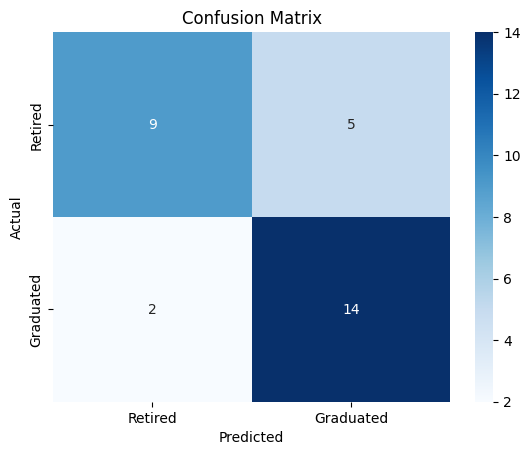

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 1 - Train Loss: 0.6923361569643021 | Train Acc: 0.47619047619047616
Epoch 1 - Val Loss: 0.6616438031196594 | Val Acc: 0.625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 2 - Train Loss: 0.6332817077636719 | Train Acc: 0.6285714285714286
Epoch 2 - Val Loss: 0.6290148496627808 | Val Acc: 0.625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 3 - Train Loss: 0.6069219410419464 | Train Acc: 0.6666666666666666
Epoch 3 - Val Loss: 0.5597193241119385 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 4 - Train Loss: 0.5878481417894363 | Train Acc: 0.6857142857142857
Epoch 4 - Val Loss: 0.499300092458725 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch 5 - Train Loss: 0.5963985025882721 | Train Acc: 0.7238095238095238
Epoch 5 - Val Loss: 0.49896976351737976 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 6 - Train Loss: 0.5301710888743401 | Train Acc: 0.7142857142857143
Epoch 6 - Val Loss: 0.5121116042137146 | Val Acc: 0.75


Validation Epoch 7/30: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch 7 - Train Loss: 0.5947418659925461 | Train Acc: 0.7142857142857143
Epoch 7 - Val Loss: 0.47006672620773315 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch 8 - Train Loss: 0.495089516043663 | Train Acc: 0.7523809523809524
Epoch 8 - Val Loss: 0.4653562307357788 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch 9 - Train Loss: 0.5469832718372345 | Train Acc: 0.7238095238095238
Epoch 9 - Val Loss: 0.5237003564834595 | Val Acc: 0.625


Validation Epoch 10/30: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 10 - Train Loss: 0.5447724238038063 | Train Acc: 0.7714285714285715
Epoch 10 - Val Loss: 0.48796147108078003 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch 11 - Train Loss: 0.47451911121606827 | Train Acc: 0.7619047619047619
Epoch 11 - Val Loss: 0.4777974784374237 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch 12 - Train Loss: 0.5013326480984688 | Train Acc: 0.7714285714285715
Epoch 12 - Val Loss: 0.48486417531967163 | Val Acc: 0.75


Validation Epoch 13/30: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch 13 - Train Loss: 0.4985906779766083 | Train Acc: 0.7619047619047619
Epoch 13 - Val Loss: 0.49474963545799255 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Test Accuracy: 0.7667


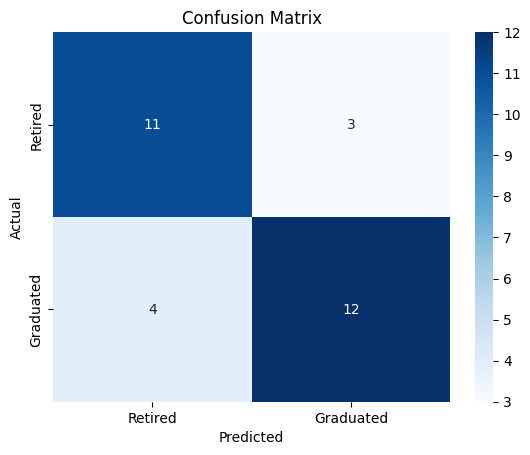

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Epoch 1 - Train Loss: 0.6954133212566376 | Train Acc: 0.49523809523809526
Epoch 1 - Val Loss: 0.6226126551628113 | Val Acc: 0.875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 2 - Train Loss: 0.6071346402168274 | Train Acc: 0.7714285714285715
Epoch 2 - Val Loss: 0.5333486199378967 | Val Acc: 0.8125


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 3 - Train Loss: 0.5875438749790192 | Train Acc: 0.7142857142857143
Epoch 3 - Val Loss: 0.5642762184143066 | Val Acc: 0.6875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 4 - Train Loss: 0.5725561380386353 | Train Acc: 0.7238095238095238
Epoch 4 - Val Loss: 0.5594061017036438 | Val Acc: 0.625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 5 - Train Loss: 0.5880821943283081 | Train Acc: 0.7047619047619048
Epoch 5 - Val Loss: 0.43890073895454407 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 6 - Train Loss: 0.5441915392875671 | Train Acc: 0.7428571428571429
Epoch 6 - Val Loss: 0.4310263991355896 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 7 - Train Loss: 0.5761187374591827 | Train Acc: 0.7333333333333333
Epoch 7 - Val Loss: 0.4270123839378357 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 8 - Train Loss: 0.5472194999456406 | Train Acc: 0.7714285714285715
Epoch 8 - Val Loss: 0.4399808645248413 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 9 - Train Loss: 0.5364493429660797 | Train Acc: 0.7619047619047619
Epoch 9 - Val Loss: 0.46957695484161377 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 10 - Train Loss: 0.5296401083469391 | Train Acc: 0.7619047619047619
Epoch 10 - Val Loss: 0.4733025133609772 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 11 - Train Loss: 0.5137353539466858 | Train Acc: 0.8
Epoch 11 - Val Loss: 0.43437352776527405 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 12 - Train Loss: 0.49769097566604614 | Train Acc: 0.7619047619047619
Epoch 12 - Val Loss: 0.4107372760772705 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 13 - Train Loss: 0.49976585805416107 | Train Acc: 0.780952380952381
Epoch 13 - Val Loss: 0.40487173199653625 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 14 - Train Loss: 0.4847618639469147 | Train Acc: 0.780952380952381
Epoch 14 - Val Loss: 0.40479737520217896 | Val Acc: 0.875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Epoch 15 - Train Loss: 0.4643275588750839 | Train Acc: 0.7904761904761904
Epoch 15 - Val Loss: 0.42524707317352295 | Val Acc: 0.8125


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 16 - Train Loss: 0.48778218030929565 | Train Acc: 0.7619047619047619
Epoch 16 - Val Loss: 0.40098804235458374 | Val Acc: 0.8125


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 17 - Train Loss: 0.43981021642684937 | Train Acc: 0.819047619047619
Epoch 17 - Val Loss: 0.39686816930770874 | Val Acc: 0.875


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 18 - Train Loss: 0.4477461576461792 | Train Acc: 0.819047619047619
Epoch 18 - Val Loss: 0.4075673222541809 | Val Acc: 0.8125


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 19 - Train Loss: 0.45265090465545654 | Train Acc: 0.8380952380952381
Epoch 19 - Val Loss: 0.4250542223453522 | Val Acc: 0.8125


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 20 - Train Loss: 0.4568173885345459 | Train Acc: 0.819047619047619
Epoch 20 - Val Loss: 0.3992096781730652 | Val Acc: 0.8125


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 21 - Train Loss: 0.4300524592399597 | Train Acc: 0.8571428571428571
Epoch 21 - Val Loss: 0.39868471026420593 | Val Acc: 0.8125


Validation Epoch 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 22 - Train Loss: 0.4149776101112366 | Train Acc: 0.8285714285714286
Epoch 22 - Val Loss: 0.4135553538799286 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Test Accuracy: 0.8000


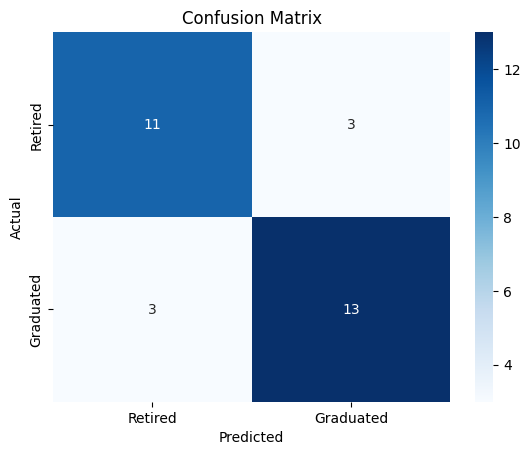

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Epoch 1 - Train Loss: 0.6793603897094727 | Train Acc: 0.6285714285714286
Epoch 1 - Val Loss: 0.7730817794799805 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 2 - Train Loss: 0.6692007184028625 | Train Acc: 0.6095238095238096
Epoch 2 - Val Loss: 0.5375207662582397 | Val Acc: 0.6875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 3 - Train Loss: 0.6110440790653229 | Train Acc: 0.6857142857142857
Epoch 3 - Val Loss: 0.5976510047912598 | Val Acc: 0.6875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Epoch 4 - Train Loss: 0.5691214714731488 | Train Acc: 0.780952380952381
Epoch 4 - Val Loss: 0.49237295985221863 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 5 - Train Loss: 0.5636907773358482 | Train Acc: 0.7142857142857143
Epoch 5 - Val Loss: 0.5120586156845093 | Val Acc: 0.6875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 6 - Train Loss: 0.5360588686806815 | Train Acc: 0.7619047619047619
Epoch 6 - Val Loss: 0.43738675117492676 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 7 - Train Loss: 0.5226862813745227 | Train Acc: 0.7714285714285715
Epoch 7 - Val Loss: 0.47254374623298645 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 8 - Train Loss: 0.534334693636213 | Train Acc: 0.7714285714285715
Epoch 8 - Val Loss: 0.37630391120910645 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Epoch 9 - Train Loss: 0.5175581191267286 | Train Acc: 0.7714285714285715
Epoch 9 - Val Loss: 0.44757017493247986 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 10 - Train Loss: 0.5104832989828927 | Train Acc: 0.7523809523809524
Epoch 10 - Val Loss: 0.4430258572101593 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 11 - Train Loss: 0.48418734329087393 | Train Acc: 0.7904761904761904
Epoch 11 - Val Loss: 0.46802622079849243 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 12 - Train Loss: 0.4281107485294342 | Train Acc: 0.7904761904761904
Epoch 12 - Val Loss: 0.3902468681335449 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 13 - Train Loss: 0.4034779795578548 | Train Acc: 0.8285714285714286
Epoch 13 - Val Loss: 0.3688320219516754 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 14 - Train Loss: 0.42891627975872587 | Train Acc: 0.819047619047619
Epoch 14 - Val Loss: 0.3874305486679077 | Val Acc: 0.875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 15 - Train Loss: 0.4241436549595424 | Train Acc: 0.8285714285714286
Epoch 15 - Val Loss: 0.38415807485580444 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 16 - Train Loss: 0.3828366441386087 | Train Acc: 0.8285714285714286
Epoch 16 - Val Loss: 0.3683435916900635 | Val Acc: 0.875


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 17 - Train Loss: 0.3450684483562197 | Train Acc: 0.8666666666666667
Epoch 17 - Val Loss: 0.3490752577781677 | Val Acc: 0.875


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 18 - Train Loss: 0.3405069942985262 | Train Acc: 0.8666666666666667
Epoch 18 - Val Loss: 0.4111380875110626 | Val Acc: 0.875


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 19 - Train Loss: 0.3150352771793093 | Train Acc: 0.8761904761904762
Epoch 19 - Val Loss: 0.4646241068840027 | Val Acc: 0.75


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 20 - Train Loss: 0.2631452807358333 | Train Acc: 0.8952380952380953
Epoch 20 - Val Loss: 0.3804883062839508 | Val Acc: 0.875


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 21 - Train Loss: 0.20934402410473144 | Train Acc: 0.9142857142857143
Epoch 21 - Val Loss: 0.7502936720848083 | Val Acc: 0.625


Validation Epoch 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 22 - Train Loss: 0.27944181114435196 | Train Acc: 0.9142857142857143
Epoch 22 - Val Loss: 1.304740071296692 | Val Acc: 0.5625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Test Accuracy: 0.6667


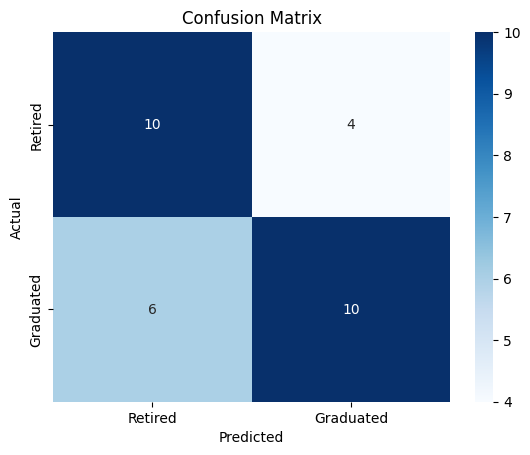

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 1 - Train Loss: 0.6752337217330933 | Train Acc: 0.5619047619047619
Epoch 1 - Val Loss: 0.7023119926452637 | Val Acc: 0.5


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 2 - Train Loss: 0.5841327607631683 | Train Acc: 0.6952380952380952
Epoch 2 - Val Loss: 0.4948734939098358 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 3 - Train Loss: 0.6391333639621735 | Train Acc: 0.7142857142857143
Epoch 3 - Val Loss: 0.499695748090744 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 4 - Train Loss: 0.5661181807518005 | Train Acc: 0.7047619047619048
Epoch 4 - Val Loss: 0.5162689089775085 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 5 - Train Loss: 0.5578576624393463 | Train Acc: 0.7523809523809524
Epoch 5 - Val Loss: 0.49969059228897095 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 6 - Train Loss: 0.5538854449987411 | Train Acc: 0.7523809523809524
Epoch 6 - Val Loss: 0.4816697835922241 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 7 - Train Loss: 0.6117502525448799 | Train Acc: 0.6571428571428571
Epoch 7 - Val Loss: 0.523614227771759 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 8 - Train Loss: 0.4730204865336418 | Train Acc: 0.7333333333333333
Epoch 8 - Val Loss: 0.5729761719703674 | Val Acc: 0.6875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 9 - Train Loss: 0.527111366391182 | Train Acc: 0.7428571428571429
Epoch 9 - Val Loss: 0.5271446704864502 | Val Acc: 0.625


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 10 - Train Loss: 0.47339656949043274 | Train Acc: 0.7904761904761904
Epoch 10 - Val Loss: 0.420589804649353 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 11 - Train Loss: 0.49713415652513504 | Train Acc: 0.780952380952381
Epoch 11 - Val Loss: 0.3725176155567169 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 12 - Train Loss: 0.5511407852172852 | Train Acc: 0.780952380952381
Epoch 12 - Val Loss: 0.4289481043815613 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 13 - Train Loss: 0.49951858818531036 | Train Acc: 0.7904761904761904
Epoch 13 - Val Loss: 0.4671841561794281 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 14 - Train Loss: 0.40751877799630165 | Train Acc: 0.8285714285714286
Epoch 14 - Val Loss: 0.4569756090641022 | Val Acc: 0.875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 15 - Train Loss: 0.3911488428711891 | Train Acc: 0.8285714285714286
Epoch 15 - Val Loss: 0.42113035917282104 | Val Acc: 0.8125


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 16 - Train Loss: 0.4082621783018112 | Train Acc: 0.8285714285714286
Epoch 16 - Val Loss: 0.41741228103637695 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Test Accuracy: 0.8000


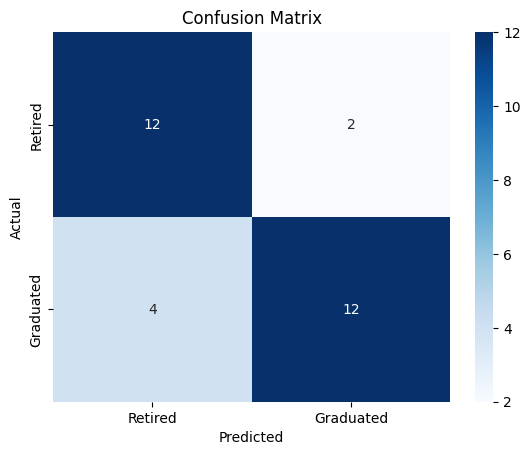

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1 - Train Loss: 0.6981883645057678 | Train Acc: 0.5619047619047619
Epoch 1 - Val Loss: 0.6778907179832458 | Val Acc: 0.625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 2 - Train Loss: 0.6888405084609985 | Train Acc: 0.6
Epoch 2 - Val Loss: 0.5928807854652405 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 3 - Train Loss: 0.6221791803836823 | Train Acc: 0.6857142857142857
Epoch 3 - Val Loss: 0.5332751274108887 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 4 - Train Loss: 0.5476723313331604 | Train Acc: 0.7238095238095238
Epoch 4 - Val Loss: 0.5342340469360352 | Val Acc: 0.625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 5 - Train Loss: 0.5350237339735031 | Train Acc: 0.7428571428571429
Epoch 5 - Val Loss: 0.5061999559402466 | Val Acc: 0.6875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch 6 - Train Loss: 0.5191363841295242 | Train Acc: 0.7238095238095238
Epoch 6 - Val Loss: 0.5839524865150452 | Val Acc: 0.6875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 7 - Train Loss: 0.5435925126075745 | Train Acc: 0.780952380952381
Epoch 7 - Val Loss: 0.5401318669319153 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 8 - Train Loss: 0.5236577093601227 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.47939106822013855 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 9 - Train Loss: 0.4640810936689377 | Train Acc: 0.7619047619047619
Epoch 9 - Val Loss: 0.46238112449645996 | Val Acc: 0.75


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 10 - Train Loss: 0.4526050239801407 | Train Acc: 0.7904761904761904
Epoch 10 - Val Loss: 0.43155017495155334 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 11 - Train Loss: 0.4554574489593506 | Train Acc: 0.7714285714285715
Epoch 11 - Val Loss: 0.4222429096698761 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch 12 - Train Loss: 0.4309930354356766 | Train Acc: 0.819047619047619
Epoch 12 - Val Loss: 0.4094559848308563 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 13 - Train Loss: 0.47270825505256653 | Train Acc: 0.7714285714285715
Epoch 13 - Val Loss: 0.3999220132827759 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 14 - Train Loss: 0.4446915537118912 | Train Acc: 0.8
Epoch 14 - Val Loss: 0.4238617420196533 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Epoch 15 - Train Loss: 0.4201490581035614 | Train Acc: 0.819047619047619
Epoch 15 - Val Loss: 0.39845073223114014 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 16 - Train Loss: 0.41374580562114716 | Train Acc: 0.8380952380952381
Epoch 16 - Val Loss: 0.3696427643299103 | Val Acc: 0.875


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 17 - Train Loss: 0.4025877118110657 | Train Acc: 0.8095238095238095
Epoch 17 - Val Loss: 0.34544074535369873 | Val Acc: 0.875


Validation Epoch 18/30: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Epoch 18 - Train Loss: 0.3491707220673561 | Train Acc: 0.8571428571428571
Epoch 18 - Val Loss: 0.33441486954689026 | Val Acc: 0.8125


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch 19 - Train Loss: 0.36663469672203064 | Train Acc: 0.8476190476190476
Epoch 19 - Val Loss: 0.3386487364768982 | Val Acc: 0.875


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 20 - Train Loss: 0.33590807020664215 | Train Acc: 0.8666666666666667
Epoch 20 - Val Loss: 0.3226734697818756 | Val Acc: 0.875


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 21 - Train Loss: 0.3531407117843628 | Train Acc: 0.8476190476190476
Epoch 21 - Val Loss: 0.3335776627063751 | Val Acc: 0.875


Validation Epoch 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 22 - Train Loss: 0.23521775752305984 | Train Acc: 0.8857142857142857
Epoch 22 - Val Loss: 0.3018849194049835 | Val Acc: 0.9375


Validation Epoch 23/30: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch 23 - Train Loss: 0.2649599462747574 | Train Acc: 0.8761904761904762
Epoch 23 - Val Loss: 0.5672367215156555 | Val Acc: 0.75


Validation Epoch 24/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 24 - Train Loss: 0.25806763023138046 | Train Acc: 0.8761904761904762
Epoch 24 - Val Loss: 0.5378063917160034 | Val Acc: 0.875


Validation Epoch 25/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 25 - Train Loss: 0.46074338257312775 | Train Acc: 0.780952380952381
Epoch 25 - Val Loss: 0.44043612480163574 | Val Acc: 0.875


Validation Epoch 26/30: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch 26 - Train Loss: 0.3006327524781227 | Train Acc: 0.8857142857142857
Epoch 26 - Val Loss: 0.5737845301628113 | Val Acc: 0.75


Validation Epoch 27/30: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch 27 - Train Loss: 0.31204958260059357 | Train Acc: 0.8666666666666667
Epoch 27 - Val Loss: 0.3715279996395111 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Test Accuracy: 0.8000


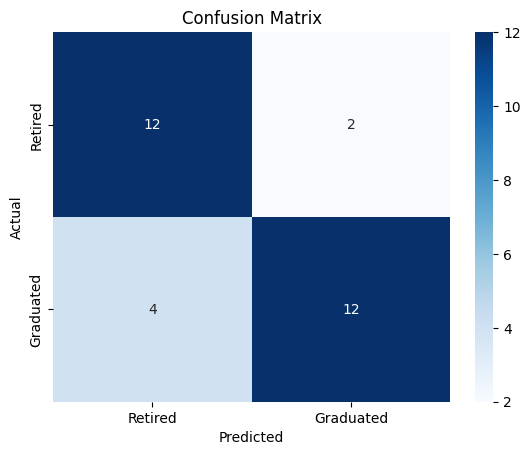

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 1 - Train Loss: 0.7300854921340942 | Train Acc: 0.5428571428571428
Epoch 1 - Val Loss: 0.7265758514404297 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 2 - Train Loss: 0.6405849712235587 | Train Acc: 0.7047619047619048
Epoch 2 - Val Loss: 0.5420909523963928 | Val Acc: 0.75


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 3 - Train Loss: 0.651753808770861 | Train Acc: 0.5904761904761905
Epoch 3 - Val Loss: 0.6776183843612671 | Val Acc: 0.5625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Epoch 4 - Train Loss: 0.8231632837227413 | Train Acc: 0.5523809523809524
Epoch 4 - Val Loss: 0.685024082660675 | Val Acc: 0.5625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 5 - Train Loss: 0.743297415120261 | Train Acc: 0.5047619047619047
Epoch 5 - Val Loss: 0.7162882685661316 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Epoch 6 - Train Loss: 0.7350131869316101 | Train Acc: 0.44761904761904764
Epoch 6 - Val Loss: 0.6795437335968018 | Val Acc: 0.5625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 7 - Train Loss: 0.6915793248585292 | Train Acc: 0.5523809523809524
Epoch 7 - Val Loss: 0.6731013655662537 | Val Acc: 0.5625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Test Accuracy: 0.5333


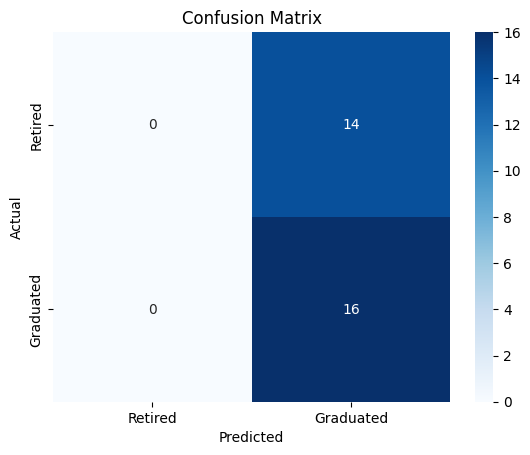

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 1 - Train Loss: 0.7664600014686584 | Train Acc: 0.49523809523809526
Epoch 1 - Val Loss: 0.6786287426948547 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 2 - Train Loss: 0.6620076894760132 | Train Acc: 0.6095238095238096
Epoch 2 - Val Loss: 0.6543667316436768 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 3 - Train Loss: 0.7065563201904297 | Train Acc: 0.580952380952381
Epoch 3 - Val Loss: 0.6516386270523071 | Val Acc: 0.625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 4 - Train Loss: 0.749700129032135 | Train Acc: 0.5142857142857142
Epoch 4 - Val Loss: 0.5964952707290649 | Val Acc: 0.6875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 5 - Train Loss: 0.5966755300760269 | Train Acc: 0.7142857142857143
Epoch 5 - Val Loss: 0.5216789841651917 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 6 - Train Loss: 0.6109967455267906 | Train Acc: 0.7523809523809524
Epoch 6 - Val Loss: 0.6754432320594788 | Val Acc: 0.625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 7 - Train Loss: 0.5644391477108002 | Train Acc: 0.7619047619047619
Epoch 7 - Val Loss: 0.5126461386680603 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 8 - Train Loss: 0.5409920886158943 | Train Acc: 0.7619047619047619
Epoch 8 - Val Loss: 0.7166183590888977 | Val Acc: 0.625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 9 - Train Loss: 0.7649085521697998 | Train Acc: 0.580952380952381
Epoch 9 - Val Loss: 0.7584773898124695 | Val Acc: 0.4375


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 10 - Train Loss: 0.7391354888677597 | Train Acc: 0.47619047619047616
Epoch 10 - Val Loss: 0.6948783993721008 | Val Acc: 0.5625


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 11 - Train Loss: 0.696137085556984 | Train Acc: 0.5333333333333333
Epoch 11 - Val Loss: 0.6858958601951599 | Val Acc: 0.5625


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 12 - Train Loss: 0.7037989050149918 | Train Acc: 0.5238095238095238
Epoch 12 - Val Loss: 0.6867702007293701 | Val Acc: 0.5625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Test Accuracy: 0.5333


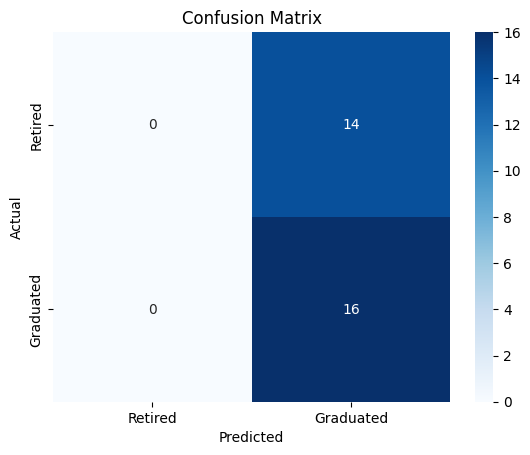

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 1 - Train Loss: 0.7076884508132935 | Train Acc: 0.4380952380952381
Epoch 1 - Val Loss: 0.6587989330291748 | Val Acc: 0.625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 2 - Train Loss: 0.6849903166294098 | Train Acc: 0.580952380952381
Epoch 2 - Val Loss: 0.6361337304115295 | Val Acc: 0.625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 3 - Train Loss: 0.6496994197368622 | Train Acc: 0.6190476190476191
Epoch 3 - Val Loss: 0.5589417219161987 | Val Acc: 0.75


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 4 - Train Loss: 0.5719766318798065 | Train Acc: 0.7142857142857143
Epoch 4 - Val Loss: 0.9201919436454773 | Val Acc: 0.4375


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 5 - Train Loss: 0.7175588011741638 | Train Acc: 0.580952380952381
Epoch 5 - Val Loss: 0.4844060242176056 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 6 - Train Loss: 0.6415528655052185 | Train Acc: 0.7238095238095238
Epoch 6 - Val Loss: 0.5235452055931091 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 7 - Train Loss: 0.5715364813804626 | Train Acc: 0.7047619047619048
Epoch 7 - Val Loss: 0.5022557377815247 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 8 - Train Loss: 0.5775689482688904 | Train Acc: 0.7142857142857143
Epoch 8 - Val Loss: 0.4212420582771301 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 9 - Train Loss: 0.5716258585453033 | Train Acc: 0.7047619047619048
Epoch 9 - Val Loss: 0.4058111011981964 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 10 - Train Loss: 0.5464593172073364 | Train Acc: 0.7619047619047619
Epoch 10 - Val Loss: 0.41893109679222107 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 11 - Train Loss: 0.5395788699388504 | Train Acc: 0.7523809523809524
Epoch 11 - Val Loss: 0.43997645378112793 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 12 - Train Loss: 0.5711649954319 | Train Acc: 0.780952380952381
Epoch 12 - Val Loss: 0.4023895859718323 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 13 - Train Loss: 0.5126345902681351 | Train Acc: 0.7619047619047619
Epoch 13 - Val Loss: 0.44646155834198 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 14 - Train Loss: 0.48220162093639374 | Train Acc: 0.7428571428571429
Epoch 14 - Val Loss: 0.45470869541168213 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 15 - Train Loss: 0.4761860966682434 | Train Acc: 0.780952380952381
Epoch 15 - Val Loss: 0.40288352966308594 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 16 - Train Loss: 0.48885996639728546 | Train Acc: 0.8
Epoch 16 - Val Loss: 0.4458400309085846 | Val Acc: 0.8125


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 17 - Train Loss: 0.4632764756679535 | Train Acc: 0.819047619047619
Epoch 17 - Val Loss: 0.41304582357406616 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Test Accuracy: 0.8667


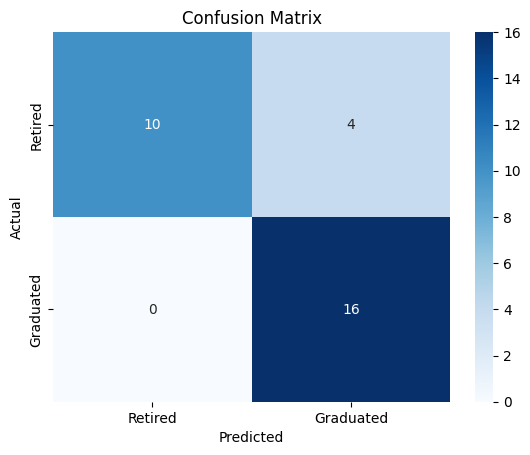

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 1 - Train Loss: 0.6523286189351764 | Train Acc: 0.6476190476190476
Epoch 1 - Val Loss: 0.5792735815048218 | Val Acc: 0.875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 2 - Train Loss: 0.6258660980633327 | Train Acc: 0.6952380952380952
Epoch 2 - Val Loss: 0.5589614510536194 | Val Acc: 0.625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 3 - Train Loss: 0.5646969420569283 | Train Acc: 0.7428571428571429
Epoch 3 - Val Loss: 0.44732898473739624 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 4 - Train Loss: 0.5337221665041787 | Train Acc: 0.7238095238095238
Epoch 4 - Val Loss: 0.43314477801322937 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 5 - Train Loss: 0.5302941671439579 | Train Acc: 0.7523809523809524
Epoch 5 - Val Loss: 0.4336337447166443 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 6 - Train Loss: 0.506940484046936 | Train Acc: 0.780952380952381
Epoch 6 - Val Loss: 0.37691786885261536 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 7 - Train Loss: 0.5344047333512988 | Train Acc: 0.7714285714285715
Epoch 7 - Val Loss: 0.3928438127040863 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 8 - Train Loss: 0.44298876183373587 | Train Acc: 0.8095238095238095
Epoch 8 - Val Loss: 0.4023706614971161 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 9 - Train Loss: 0.46844186953135897 | Train Acc: 0.7904761904761904
Epoch 9 - Val Loss: 0.3618697226047516 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 10 - Train Loss: 0.46055281162261963 | Train Acc: 0.8095238095238095
Epoch 10 - Val Loss: 0.45526227355003357 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 11 - Train Loss: 0.45929193070956637 | Train Acc: 0.819047619047619
Epoch 11 - Val Loss: 0.3718743622303009 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


Epoch 12 - Train Loss: 0.4378232743058886 | Train Acc: 0.8095238095238095
Epoch 12 - Val Loss: 0.396793931722641 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 13 - Train Loss: 0.39892046792166574 | Train Acc: 0.8380952380952381
Epoch 13 - Val Loss: 0.36231982707977295 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 14 - Train Loss: 0.3670433099780764 | Train Acc: 0.8571428571428571
Epoch 14 - Val Loss: 0.37264931201934814 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


Test Accuracy: 0.8667


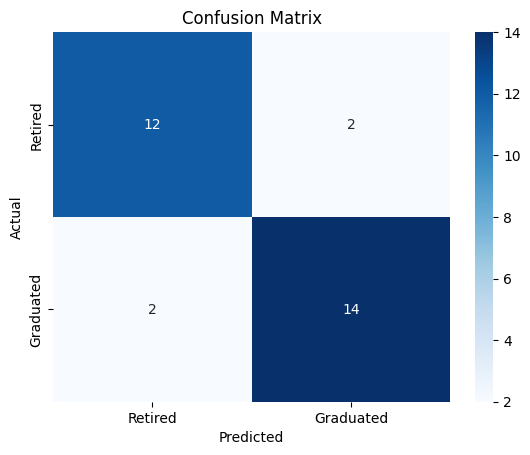

In [19]:
for i in range(0, 10):
  hyperparameters = hyperparameter_combinations[i]
  execute_hyperparameter_combination(
      hyperparameters['dropout'],
      hyperparameters['weight_decay'],
      hyperparameters['learning_rate'],
      hyperparameters['batch_size']
  )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 1 - Train Loss: 0.7058124244213104 | Train Acc: 0.5333333333333333
Epoch 1 - Val Loss: 0.6041251420974731 | Val Acc: 0.875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 2 - Train Loss: 0.5775294080376625 | Train Acc: 0.6952380952380952
Epoch 2 - Val Loss: 0.5342157483100891 | Val Acc: 0.75


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 3 - Train Loss: 0.5742697268724442 | Train Acc: 0.7142857142857143
Epoch 3 - Val Loss: 0.44028908014297485 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 4 - Train Loss: 0.5666034668684006 | Train Acc: 0.6857142857142857
Epoch 4 - Val Loss: 0.4400734603404999 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Epoch 5 - Train Loss: 0.6200636550784111 | Train Acc: 0.7142857142857143
Epoch 5 - Val Loss: 0.4515419006347656 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Epoch 6 - Train Loss: 0.5512197688221931 | Train Acc: 0.7047619047619048
Epoch 6 - Val Loss: 0.4419156610965729 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 7 - Train Loss: 0.5106390342116356 | Train Acc: 0.7428571428571429
Epoch 7 - Val Loss: 0.45497819781303406 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Epoch 8 - Train Loss: 0.5074747502803802 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.4489738643169403 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 9 - Train Loss: 0.5314832702279091 | Train Acc: 0.7714285714285715
Epoch 9 - Val Loss: 0.42754194140434265 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 10 - Train Loss: 0.5165751129388809 | Train Acc: 0.7523809523809524
Epoch 10 - Val Loss: 0.42410194873809814 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 11 - Train Loss: 0.5366368591785431 | Train Acc: 0.7333333333333333
Epoch 11 - Val Loss: 0.4298068881034851 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 12 - Train Loss: 0.462255135178566 | Train Acc: 0.7714285714285715
Epoch 12 - Val Loss: 0.4290882349014282 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 13 - Train Loss: 0.5086268410086632 | Train Acc: 0.780952380952381
Epoch 13 - Val Loss: 0.4161609709262848 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 14 - Train Loss: 0.4553993418812752 | Train Acc: 0.7904761904761904
Epoch 14 - Val Loss: 0.4093034565448761 | Val Acc: 0.875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 15 - Train Loss: 0.43831513077020645 | Train Acc: 0.8095238095238095
Epoch 15 - Val Loss: 0.3719886839389801 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 16 - Train Loss: 0.5052276700735092 | Train Acc: 0.780952380952381
Epoch 16 - Val Loss: 0.43833839893341064 | Val Acc: 0.8125


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 17 - Train Loss: 0.4434179961681366 | Train Acc: 0.8
Epoch 17 - Val Loss: 0.49394676089286804 | Val Acc: 0.75


Validation Epoch 18/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 18 - Train Loss: 0.4623552933335304 | Train Acc: 0.8
Epoch 18 - Val Loss: 0.433895468711853 | Val Acc: 0.8125


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 19 - Train Loss: 0.49424518644809723 | Train Acc: 0.8
Epoch 19 - Val Loss: 0.40485918521881104 | Val Acc: 0.875


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 20 - Train Loss: 0.43303266167640686 | Train Acc: 0.819047619047619
Epoch 20 - Val Loss: 0.4074210822582245 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Test Accuracy: 0.8000


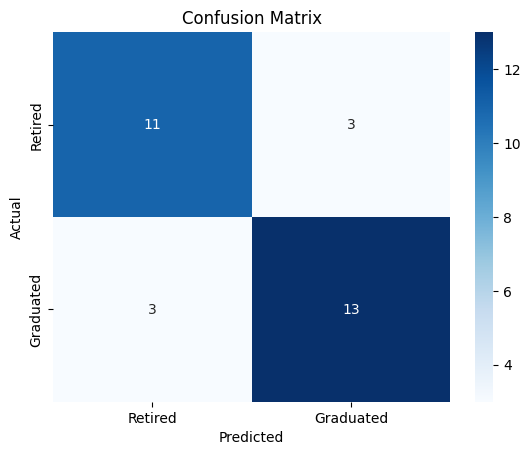

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 1 - Train Loss: 0.7354881465435028 | Train Acc: 0.47619047619047616
Epoch 1 - Val Loss: 0.6738568544387817 | Val Acc: 0.375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 2 - Train Loss: 0.6647042632102966 | Train Acc: 0.6190476190476191
Epoch 2 - Val Loss: 0.6359100937843323 | Val Acc: 0.8125


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 3 - Train Loss: 0.640026181936264 | Train Acc: 0.580952380952381
Epoch 3 - Val Loss: 0.5630753040313721 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 4 - Train Loss: 0.6072843074798584 | Train Acc: 0.7047619047619048
Epoch 4 - Val Loss: 0.5089669227600098 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 5 - Train Loss: 0.5594374537467957 | Train Acc: 0.7428571428571429
Epoch 5 - Val Loss: 0.5016627907752991 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 6 - Train Loss: 0.5846062898635864 | Train Acc: 0.7333333333333333
Epoch 6 - Val Loss: 0.5418996810913086 | Val Acc: 0.6875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 7 - Train Loss: 0.5584205687046051 | Train Acc: 0.7333333333333333
Epoch 7 - Val Loss: 0.5263466835021973 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 8 - Train Loss: 0.5380853712558746 | Train Acc: 0.7619047619047619
Epoch 8 - Val Loss: 0.49707531929016113 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 9 - Train Loss: 0.5418698489665985 | Train Acc: 0.7428571428571429
Epoch 9 - Val Loss: 0.47027161717414856 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 10 - Train Loss: 0.5538786947727203 | Train Acc: 0.7142857142857143
Epoch 10 - Val Loss: 0.46060460805892944 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 11 - Train Loss: 0.5425790548324585 | Train Acc: 0.7428571428571429
Epoch 11 - Val Loss: 0.46319475769996643 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 12 - Train Loss: 0.5198082029819489 | Train Acc: 0.7523809523809524
Epoch 12 - Val Loss: 0.4874644875526428 | Val Acc: 0.75


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 13 - Train Loss: 0.5460222810506821 | Train Acc: 0.780952380952381
Epoch 13 - Val Loss: 0.5009443759918213 | Val Acc: 0.75


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 14 - Train Loss: 0.5063822567462921 | Train Acc: 0.7714285714285715
Epoch 14 - Val Loss: 0.48857495188713074 | Val Acc: 0.75


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 15 - Train Loss: 0.5009859800338745 | Train Acc: 0.7714285714285715
Epoch 15 - Val Loss: 0.4697238504886627 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Test Accuracy: 0.7333


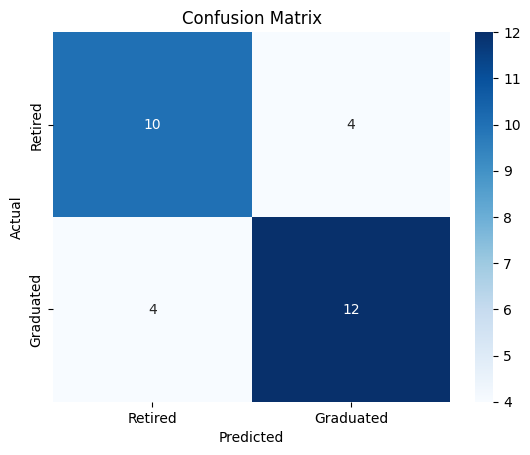

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 1 - Train Loss: 0.6776868530682155 | Train Acc: 0.6190476190476191
Epoch 1 - Val Loss: 0.6781459450721741 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 2 - Train Loss: 0.6189654895237514 | Train Acc: 0.6666666666666666
Epoch 2 - Val Loss: 0.5983181595802307 | Val Acc: 0.6875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 3 - Train Loss: 0.5813184593405042 | Train Acc: 0.7523809523809524
Epoch 3 - Val Loss: 0.4294218420982361 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 4 - Train Loss: 0.5604911574295589 | Train Acc: 0.7047619047619048
Epoch 4 - Val Loss: 0.44159454107284546 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 5 - Train Loss: 0.528732397726604 | Train Acc: 0.7333333333333333
Epoch 5 - Val Loss: 0.43603378534317017 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 6 - Train Loss: 0.539137716804232 | Train Acc: 0.780952380952381
Epoch 6 - Val Loss: 0.501632034778595 | Val Acc: 0.8125


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 7 - Train Loss: 0.5148885548114777 | Train Acc: 0.7619047619047619
Epoch 7 - Val Loss: 0.4274861514568329 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 8 - Train Loss: 0.4417898952960968 | Train Acc: 0.8095238095238095
Epoch 8 - Val Loss: 0.397348016500473 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 9 - Train Loss: 0.44270830920764376 | Train Acc: 0.8
Epoch 9 - Val Loss: 0.3989879786968231 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 10 - Train Loss: 0.5020370440823692 | Train Acc: 0.7904761904761904
Epoch 10 - Val Loss: 0.43381306529045105 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Epoch 11 - Train Loss: 0.47160649725369047 | Train Acc: 0.7904761904761904
Epoch 11 - Val Loss: 0.3958958387374878 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 12 - Train Loss: 0.47406417982918875 | Train Acc: 0.7904761904761904
Epoch 12 - Val Loss: 0.390971302986145 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 13 - Train Loss: 0.43776010615485056 | Train Acc: 0.8
Epoch 13 - Val Loss: 0.3848976790904999 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 14 - Train Loss: 0.4160205956016268 | Train Acc: 0.8095238095238095
Epoch 14 - Val Loss: 0.6911380887031555 | Val Acc: 0.6875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 15 - Train Loss: 0.40194844773837496 | Train Acc: 0.819047619047619
Epoch 15 - Val Loss: 0.3858368396759033 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 16 - Train Loss: 0.3791183020387377 | Train Acc: 0.8571428571428571
Epoch 16 - Val Loss: 0.39370065927505493 | Val Acc: 0.8125


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 17 - Train Loss: 0.35638043710163664 | Train Acc: 0.8666666666666667
Epoch 17 - Val Loss: 0.3921717405319214 | Val Acc: 0.875


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 18 - Train Loss: 0.36254369786807467 | Train Acc: 0.8761904761904762
Epoch 18 - Val Loss: 0.4521544575691223 | Val Acc: 0.75
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Test Accuracy: 0.8000


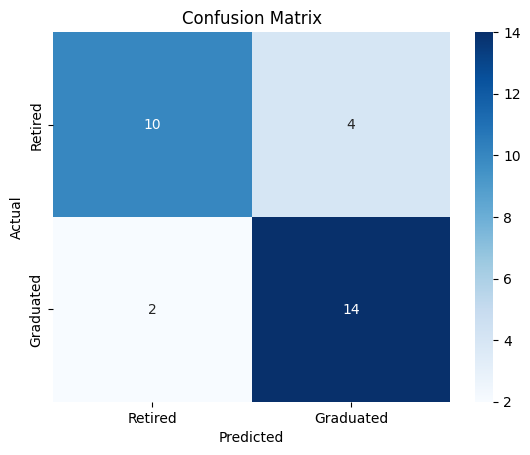

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 1 - Train Loss: 0.6891755312681198 | Train Acc: 0.580952380952381
Epoch 1 - Val Loss: 0.6664093732833862 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 2 - Train Loss: 0.6489322781562805 | Train Acc: 0.6476190476190476
Epoch 2 - Val Loss: 0.5881040096282959 | Val Acc: 0.625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 3 - Train Loss: 0.5372122526168823 | Train Acc: 0.7142857142857143
Epoch 3 - Val Loss: 0.4370020031929016 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 4 - Train Loss: 0.6563819870352745 | Train Acc: 0.7142857142857143
Epoch 4 - Val Loss: 0.7316722273826599 | Val Acc: 0.5


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 5 - Train Loss: 0.5948981642723083 | Train Acc: 0.6952380952380952
Epoch 5 - Val Loss: 0.5632604360580444 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 6 - Train Loss: 0.5197800248861313 | Train Acc: 0.7523809523809524
Epoch 6 - Val Loss: 0.5345394611358643 | Val Acc: 0.625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 7 - Train Loss: 0.4964482933282852 | Train Acc: 0.7428571428571429
Epoch 7 - Val Loss: 0.5291936993598938 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 8 - Train Loss: 0.6111724972724915 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.46241316199302673 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Test Accuracy: 0.7333


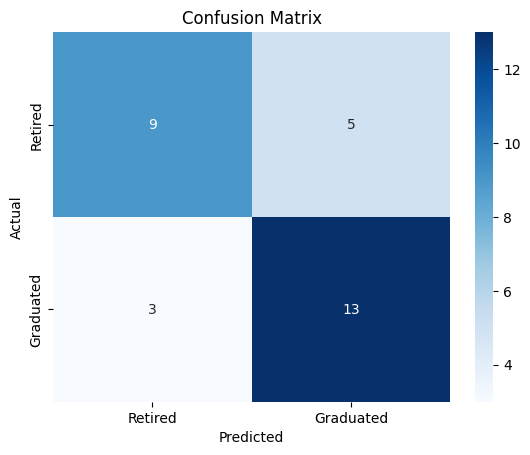

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 1 - Train Loss: 0.6892045736312866 | Train Acc: 0.5333333333333333
Epoch 1 - Val Loss: 0.5466243624687195 | Val Acc: 0.875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 2 - Train Loss: 0.5771004557609558 | Train Acc: 0.7238095238095238
Epoch 2 - Val Loss: 0.5205245018005371 | Val Acc: 0.625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 3 - Train Loss: 0.5780758857727051 | Train Acc: 0.7047619047619048
Epoch 3 - Val Loss: 0.45032042264938354 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 4 - Train Loss: 0.5514163076877594 | Train Acc: 0.7238095238095238
Epoch 4 - Val Loss: 0.5725911855697632 | Val Acc: 0.6875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 5 - Train Loss: 0.5381766557693481 | Train Acc: 0.7333333333333333
Epoch 5 - Val Loss: 0.45622000098228455 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 6 - Train Loss: 0.5035370141267776 | Train Acc: 0.7523809523809524
Epoch 6 - Val Loss: 0.4098065495491028 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 7 - Train Loss: 0.4876013547182083 | Train Acc: 0.780952380952381
Epoch 7 - Val Loss: 0.4167555272579193 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 8 - Train Loss: 0.49940694868564606 | Train Acc: 0.7904761904761904
Epoch 8 - Val Loss: 0.41438934206962585 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 9 - Train Loss: 0.45368580520153046 | Train Acc: 0.8
Epoch 9 - Val Loss: 0.4063876271247864 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 10 - Train Loss: 0.4508228451013565 | Train Acc: 0.819047619047619
Epoch 10 - Val Loss: 0.43985074758529663 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 11 - Train Loss: 0.45323511958122253 | Train Acc: 0.8095238095238095
Epoch 11 - Val Loss: 0.4292532503604889 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 12 - Train Loss: 0.4151081293821335 | Train Acc: 0.8285714285714286
Epoch 12 - Val Loss: 0.43482860922813416 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 13 - Train Loss: 0.41663649678230286 | Train Acc: 0.8380952380952381
Epoch 13 - Val Loss: 0.48708146810531616 | Val Acc: 0.75


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 14 - Train Loss: 0.410734623670578 | Train Acc: 0.8285714285714286
Epoch 14 - Val Loss: 0.4182625114917755 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Test Accuracy: 0.7667


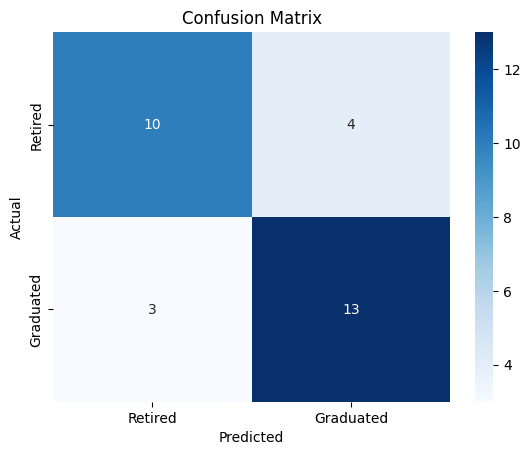

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 1 - Train Loss: 0.7810719949858529 | Train Acc: 0.4666666666666667
Epoch 1 - Val Loss: 0.8852097392082214 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 2 - Train Loss: 0.6968210765293666 | Train Acc: 0.5714285714285714
Epoch 2 - Val Loss: 0.6156579852104187 | Val Acc: 0.75


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 3 - Train Loss: 0.6683957832200187 | Train Acc: 0.6761904761904762
Epoch 3 - Val Loss: 0.41885167360305786 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Epoch 4 - Train Loss: 0.5985854906695229 | Train Acc: 0.7238095238095238
Epoch 4 - Val Loss: 0.49505946040153503 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 5 - Train Loss: 0.6176261007785797 | Train Acc: 0.6952380952380952
Epoch 5 - Val Loss: 0.7240415811538696 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 6 - Train Loss: 0.7147423624992371 | Train Acc: 0.5238095238095238
Epoch 6 - Val Loss: 0.7098526358604431 | Val Acc: 0.4375


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 7 - Train Loss: 0.7358993377004351 | Train Acc: 0.4857142857142857
Epoch 7 - Val Loss: 0.6946002244949341 | Val Acc: 0.4375


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 8 - Train Loss: 0.6939798934119088 | Train Acc: 0.4857142857142857
Epoch 8 - Val Loss: 0.6891303062438965 | Val Acc: 0.5625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Test Accuracy: 0.5333


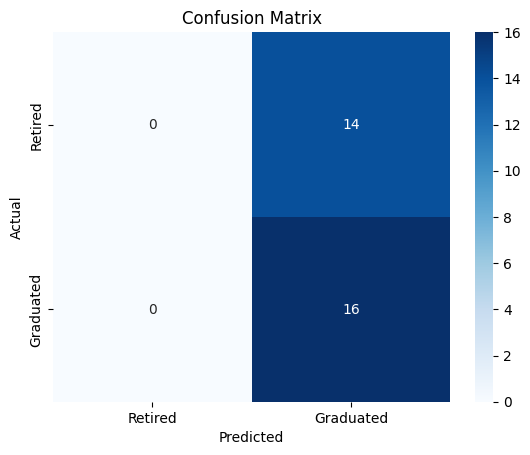

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 1 - Train Loss: 0.7196956872940063 | Train Acc: 0.5047619047619047
Epoch 1 - Val Loss: 0.7316595911979675 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 2 - Train Loss: 0.7371713519096375 | Train Acc: 0.45714285714285713
Epoch 2 - Val Loss: 0.6836029887199402 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 3 - Train Loss: 0.6866232454776764 | Train Acc: 0.5333333333333333
Epoch 3 - Val Loss: 0.674634575843811 | Val Acc: 0.625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 4 - Train Loss: 0.6775713413953781 | Train Acc: 0.580952380952381
Epoch 4 - Val Loss: 0.6597210168838501 | Val Acc: 0.625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 5 - Train Loss: 0.6871110051870346 | Train Acc: 0.6190476190476191
Epoch 5 - Val Loss: 0.6705034375190735 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 6 - Train Loss: 0.6890422403812408 | Train Acc: 0.6285714285714286
Epoch 6 - Val Loss: 0.6675289869308472 | Val Acc: 0.4375


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 7 - Train Loss: 0.6346827894449234 | Train Acc: 0.6
Epoch 7 - Val Loss: 0.585923969745636 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 8 - Train Loss: 0.6234736144542694 | Train Acc: 0.7238095238095238
Epoch 8 - Val Loss: 0.7664092183113098 | Val Acc: 0.5625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Epoch 9 - Train Loss: 0.6261615455150604 | Train Acc: 0.6571428571428571
Epoch 9 - Val Loss: 0.5043148398399353 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Epoch 10 - Train Loss: 0.626083567738533 | Train Acc: 0.6857142857142857
Epoch 10 - Val Loss: 0.5338289141654968 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Epoch 11 - Train Loss: 0.5459457263350487 | Train Acc: 0.7238095238095238
Epoch 11 - Val Loss: 0.6117299199104309 | Val Acc: 0.6875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 12 - Train Loss: 0.5921772420406342 | Train Acc: 0.7047619047619048
Epoch 12 - Val Loss: 0.5186340808868408 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 13 - Train Loss: 1.066246621310711 | Train Acc: 0.6
Epoch 13 - Val Loss: 1.02001953125 | Val Acc: 0.4375


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 14 - Train Loss: 0.7811194658279419 | Train Acc: 0.4380952380952381
Epoch 14 - Val Loss: 0.6857448220252991 | Val Acc: 0.5625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Test Accuracy: 0.5333


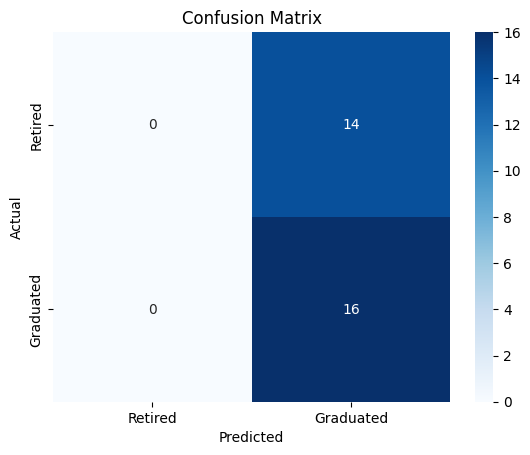

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 1 - Train Loss: 0.6176702380180359 | Train Acc: 0.6476190476190476
Epoch 1 - Val Loss: 0.7455151081085205 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 2 - Train Loss: 0.7687288224697113 | Train Acc: 0.5428571428571428
Epoch 2 - Val Loss: 0.6987674832344055 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 3 - Train Loss: 0.7245627045631409 | Train Acc: 0.5619047619047619
Epoch 3 - Val Loss: 0.6128792762756348 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 4 - Train Loss: 0.6216038763523102 | Train Acc: 0.7333333333333333
Epoch 4 - Val Loss: 0.5784121155738831 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 5 - Train Loss: 0.624917209148407 | Train Acc: 0.6666666666666666
Epoch 5 - Val Loss: 0.6425121426582336 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 6 - Train Loss: 0.65888312458992 | Train Acc: 0.6190476190476191
Epoch 6 - Val Loss: 0.6439509391784668 | Val Acc: 0.5625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 7 - Train Loss: 0.6290642619132996 | Train Acc: 0.6285714285714286
Epoch 7 - Val Loss: 0.6187065243721008 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 8 - Train Loss: 0.6347040832042694 | Train Acc: 0.5714285714285714
Epoch 8 - Val Loss: 0.5317238569259644 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 9 - Train Loss: 0.5938180387020111 | Train Acc: 0.7333333333333333
Epoch 9 - Val Loss: 0.4154430031776428 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 10 - Train Loss: 0.5975377857685089 | Train Acc: 0.6952380952380952
Epoch 10 - Val Loss: 0.47988811135292053 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 11 - Train Loss: 0.6045999526977539 | Train Acc: 0.7142857142857143
Epoch 11 - Val Loss: 0.4759567081928253 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 12 - Train Loss: 0.5296247750520706 | Train Acc: 0.7619047619047619
Epoch 12 - Val Loss: 0.49668580293655396 | Val Acc: 0.625


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 13 - Train Loss: 0.5026306509971619 | Train Acc: 0.7714285714285715
Epoch 13 - Val Loss: 0.5005850195884705 | Val Acc: 0.75


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 14 - Train Loss: 0.5152863413095474 | Train Acc: 0.7619047619047619
Epoch 14 - Val Loss: 0.5383915305137634 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Test Accuracy: 0.7000


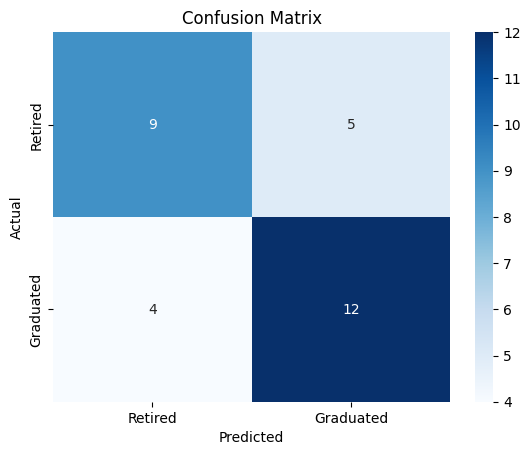

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 1 - Train Loss: 0.6958745888301304 | Train Acc: 0.580952380952381
Epoch 1 - Val Loss: 0.48702532052993774 | Val Acc: 0.875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 2 - Train Loss: 0.5884718937533242 | Train Acc: 0.7142857142857143
Epoch 2 - Val Loss: 0.5518403649330139 | Val Acc: 0.6875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 3 - Train Loss: 0.5926942569868905 | Train Acc: 0.7333333333333333
Epoch 3 - Val Loss: 0.5060693025588989 | Val Acc: 0.75


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 4 - Train Loss: 0.5663278826645443 | Train Acc: 0.7142857142857143
Epoch 4 - Val Loss: 0.45148399472236633 | Val Acc: 0.75


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 5 - Train Loss: 0.5316274634429387 | Train Acc: 0.7619047619047619
Epoch 5 - Val Loss: 0.4220011234283447 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 6 - Train Loss: 0.5272759667464665 | Train Acc: 0.7714285714285715
Epoch 6 - Val Loss: 0.49395233392715454 | Val Acc: 0.75


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 7 - Train Loss: 0.5408030450344086 | Train Acc: 0.7428571428571429
Epoch 7 - Val Loss: 0.5090316534042358 | Val Acc: 0.75


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 8 - Train Loss: 0.5331669194357735 | Train Acc: 0.7333333333333333
Epoch 8 - Val Loss: 0.4646194875240326 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 9 - Train Loss: 0.5089926421642303 | Train Acc: 0.7714285714285715
Epoch 9 - Val Loss: 0.4521681070327759 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 10 - Train Loss: 0.5377062346254077 | Train Acc: 0.7714285714285715
Epoch 10 - Val Loss: 0.4377843141555786 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


Test Accuracy: 0.7667


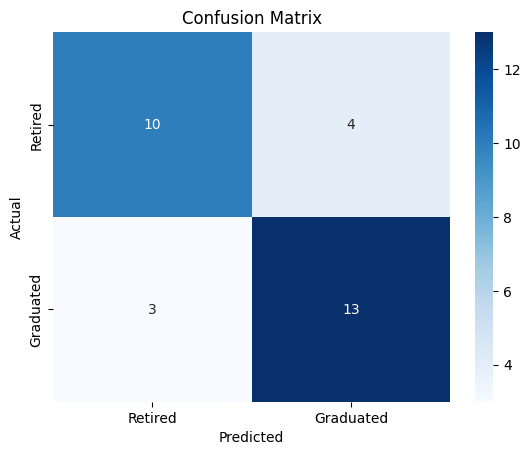

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 1 - Train Loss: 0.6891747862100601 | Train Acc: 0.5142857142857142
Epoch 1 - Val Loss: 0.5862822532653809 | Val Acc: 0.8125


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 2 - Train Loss: 0.578276589512825 | Train Acc: 0.7523809523809524
Epoch 2 - Val Loss: 0.5095904469490051 | Val Acc: 0.8125


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 3 - Train Loss: 0.6136106252670288 | Train Acc: 0.6571428571428571
Epoch 3 - Val Loss: 0.4530531167984009 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 4 - Train Loss: 0.5589015558362007 | Train Acc: 0.6857142857142857
Epoch 4 - Val Loss: 0.45660582184791565 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 5 - Train Loss: 0.5482958108186722 | Train Acc: 0.7238095238095238
Epoch 5 - Val Loss: 0.49456340074539185 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 6 - Train Loss: 0.5332961156964302 | Train Acc: 0.7428571428571429
Epoch 6 - Val Loss: 0.4300259053707123 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 7 - Train Loss: 0.5554500296711922 | Train Acc: 0.7523809523809524
Epoch 7 - Val Loss: 0.4757767915725708 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 8 - Train Loss: 0.5508190393447876 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.4884517192840576 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Epoch 9 - Train Loss: 0.5699546784162521 | Train Acc: 0.7238095238095238
Epoch 9 - Val Loss: 0.4431699216365814 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 10 - Train Loss: 0.5367588177323341 | Train Acc: 0.7428571428571429
Epoch 10 - Val Loss: 0.4717847406864166 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 11 - Train Loss: 0.5101776644587517 | Train Acc: 0.7619047619047619
Epoch 11 - Val Loss: 0.4564160704612732 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Test Accuracy: 0.8000


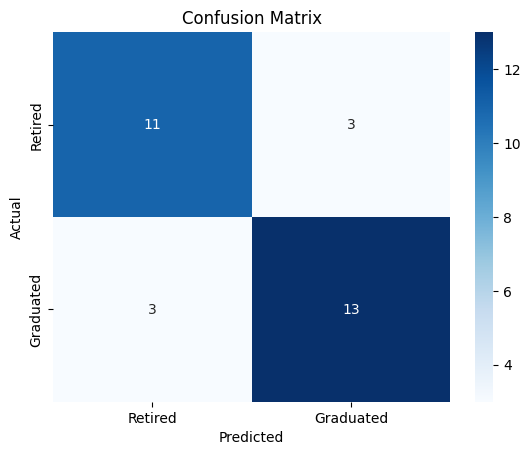

In [20]:
for i in range(10, 20):
  hyperparameters = hyperparameter_combinations[i]
  execute_hyperparameter_combination(
      hyperparameters['dropout'],
      hyperparameters['weight_decay'],
      hyperparameters['learning_rate'],
      hyperparameters['batch_size']
  )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Epoch 1 - Train Loss: 0.6906373202800751 | Train Acc: 0.5428571428571428
Epoch 1 - Val Loss: 0.6124578714370728 | Val Acc: 0.6875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 2 - Train Loss: 0.6178789734840393 | Train Acc: 0.7047619047619048
Epoch 2 - Val Loss: 0.5524872541427612 | Val Acc: 0.6875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 3 - Train Loss: 0.5798386335372925 | Train Acc: 0.7714285714285715
Epoch 3 - Val Loss: 0.46417248249053955 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 4 - Train Loss: 0.5884548723697662 | Train Acc: 0.7047619047619048
Epoch 4 - Val Loss: 0.45193347334861755 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 5 - Train Loss: 0.6031633913516998 | Train Acc: 0.6761904761904762
Epoch 5 - Val Loss: 0.444204181432724 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Epoch 6 - Train Loss: 0.5534456968307495 | Train Acc: 0.7142857142857143
Epoch 6 - Val Loss: 0.44077014923095703 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 7 - Train Loss: 0.5239183753728867 | Train Acc: 0.7523809523809524
Epoch 7 - Val Loss: 0.49519383907318115 | Val Acc: 0.75


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 8 - Train Loss: 0.5399264991283417 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.532129168510437 | Val Acc: 0.75


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 9 - Train Loss: 0.6091040968894958 | Train Acc: 0.7333333333333333
Epoch 9 - Val Loss: 0.4796617925167084 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 10 - Train Loss: 0.5012398064136505 | Train Acc: 0.7619047619047619
Epoch 10 - Val Loss: 0.4436185956001282 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 11 - Train Loss: 0.5436983406543732 | Train Acc: 0.7238095238095238
Epoch 11 - Val Loss: 0.4379023313522339 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 12 - Train Loss: 0.5271218121051788 | Train Acc: 0.7428571428571429
Epoch 12 - Val Loss: 0.4386194348335266 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 13 - Train Loss: 0.5158515274524689 | Train Acc: 0.7523809523809524
Epoch 13 - Val Loss: 0.4356999397277832 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 14 - Train Loss: 0.48968835175037384 | Train Acc: 0.780952380952381
Epoch 14 - Val Loss: 0.4585614800453186 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 15 - Train Loss: 0.5121686607599258 | Train Acc: 0.7428571428571429
Epoch 15 - Val Loss: 0.46866536140441895 | Val Acc: 0.8125


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 16 - Train Loss: 0.5189018398523331 | Train Acc: 0.7714285714285715
Epoch 16 - Val Loss: 0.44479799270629883 | Val Acc: 0.8125


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 17 - Train Loss: 0.48454204201698303 | Train Acc: 0.7714285714285715
Epoch 17 - Val Loss: 0.42372599244117737 | Val Acc: 0.8125


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 18 - Train Loss: 0.5052180737257004 | Train Acc: 0.7714285714285715
Epoch 18 - Val Loss: 0.41909676790237427 | Val Acc: 0.875


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 19 - Train Loss: 0.49027712643146515 | Train Acc: 0.780952380952381
Epoch 19 - Val Loss: 0.42511528730392456 | Val Acc: 0.875


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 20 - Train Loss: 0.46672721207141876 | Train Acc: 0.8
Epoch 20 - Val Loss: 0.43751102685928345 | Val Acc: 0.8125


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 21 - Train Loss: 0.4742000102996826 | Train Acc: 0.780952380952381
Epoch 21 - Val Loss: 0.46220818161964417 | Val Acc: 0.8125


Validation Epoch 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 22 - Train Loss: 0.480752557516098 | Train Acc: 0.7904761904761904
Epoch 22 - Val Loss: 0.46598729491233826 | Val Acc: 0.8125


Validation Epoch 23/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 23 - Train Loss: 0.4546685218811035 | Train Acc: 0.8
Epoch 23 - Val Loss: 0.44745370745658875 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Test Accuracy: 0.8000


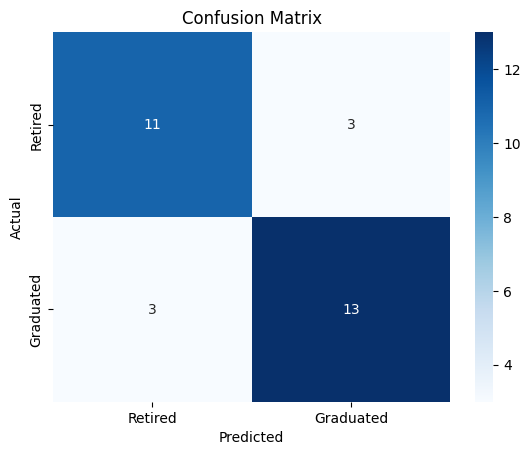

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 1 - Train Loss: 0.6990324514252799 | Train Acc: 0.5238095238095238
Epoch 1 - Val Loss: 0.6444389820098877 | Val Acc: 0.75


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 2 - Train Loss: 0.66026714018413 | Train Acc: 0.6285714285714286
Epoch 2 - Val Loss: 0.5960443615913391 | Val Acc: 0.6875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 3 - Train Loss: 0.6233429483004979 | Train Acc: 0.6952380952380952
Epoch 3 - Val Loss: 0.5828046202659607 | Val Acc: 0.6875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 4 - Train Loss: 0.52603137918881 | Train Acc: 0.7428571428571429
Epoch 4 - Val Loss: 0.4698489308357239 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 5 - Train Loss: 0.5772695796830314 | Train Acc: 0.7238095238095238
Epoch 5 - Val Loss: 0.5659074187278748 | Val Acc: 0.6875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 6 - Train Loss: 0.50908881851605 | Train Acc: 0.7619047619047619
Epoch 6 - Val Loss: 0.47084102034568787 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 7 - Train Loss: 0.5255627334117889 | Train Acc: 0.7619047619047619
Epoch 7 - Val Loss: 0.47144922614097595 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 8 - Train Loss: 0.4936369614941733 | Train Acc: 0.7714285714285715
Epoch 8 - Val Loss: 0.4760652780532837 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 9 - Train Loss: 0.4740561289446695 | Train Acc: 0.780952380952381
Epoch 9 - Val Loss: 0.4403405487537384 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 10 - Train Loss: 0.4561628912176405 | Train Acc: 0.7904761904761904
Epoch 10 - Val Loss: 0.3793126344680786 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 11 - Train Loss: 0.4303806168692453 | Train Acc: 0.819047619047619
Epoch 11 - Val Loss: 0.40069252252578735 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 12 - Train Loss: 0.4377030772822244 | Train Acc: 0.7904761904761904
Epoch 12 - Val Loss: 0.32919514179229736 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 13 - Train Loss: 0.3959081087793623 | Train Acc: 0.819047619047619
Epoch 13 - Val Loss: 0.4681108891963959 | Val Acc: 0.75


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 14 - Train Loss: 0.40146961382457186 | Train Acc: 0.8380952380952381
Epoch 14 - Val Loss: 0.35877442359924316 | Val Acc: 0.875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 15 - Train Loss: 0.3154944101614611 | Train Acc: 0.8761904761904762
Epoch 15 - Val Loss: 0.4081757962703705 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Epoch 16 - Train Loss: 0.42012032653604237 | Train Acc: 0.8571428571428571
Epoch 16 - Val Loss: 0.4123058617115021 | Val Acc: 0.75


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 17 - Train Loss: 0.42001246980258394 | Train Acc: 0.819047619047619
Epoch 17 - Val Loss: 0.3809148967266083 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Test Accuracy: 0.8000


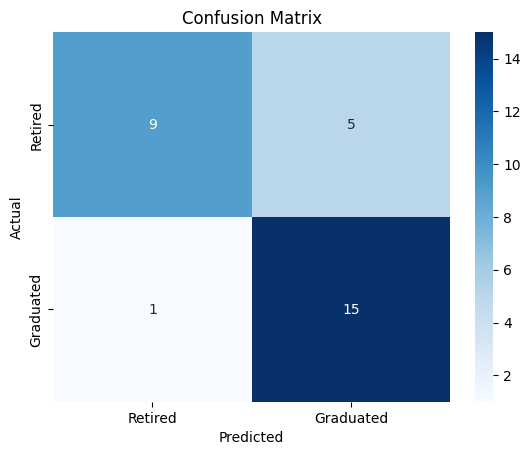

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1 - Train Loss: 0.7302100360393524 | Train Acc: 0.41904761904761906
Epoch 1 - Val Loss: 0.7142948508262634 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 2 - Train Loss: 0.620388388633728 | Train Acc: 0.6095238095238096
Epoch 2 - Val Loss: 0.5137205719947815 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 3 - Train Loss: 0.6003945544362068 | Train Acc: 0.6857142857142857
Epoch 3 - Val Loss: 0.5098089575767517 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 4 - Train Loss: 0.5966575443744659 | Train Acc: 0.7428571428571429
Epoch 4 - Val Loss: 0.5059814453125 | Val Acc: 0.75


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 5 - Train Loss: 0.5412224009633064 | Train Acc: 0.7523809523809524
Epoch 5 - Val Loss: 0.6638055443763733 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 6 - Train Loss: 0.5791304558515549 | Train Acc: 0.7047619047619048
Epoch 6 - Val Loss: 0.550835371017456 | Val Acc: 0.8125


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 7 - Train Loss: 0.5989850386977196 | Train Acc: 0.7428571428571429
Epoch 7 - Val Loss: 0.4756803810596466 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 8 - Train Loss: 0.5547730475664139 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.4650461971759796 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 9 - Train Loss: 0.4895186424255371 | Train Acc: 0.7619047619047619
Epoch 9 - Val Loss: 0.4971374273300171 | Val Acc: 0.6875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch 10 - Train Loss: 0.5497339144349098 | Train Acc: 0.7619047619047619
Epoch 10 - Val Loss: 0.5370892286300659 | Val Acc: 0.625


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Epoch 11 - Train Loss: 0.49279560148715973 | Train Acc: 0.7714285714285715
Epoch 11 - Val Loss: 0.4914896786212921 | Val Acc: 0.6875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 12 - Train Loss: 0.46829916536808014 | Train Acc: 0.780952380952381
Epoch 12 - Val Loss: 0.46400386095046997 | Val Acc: 0.6875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 13 - Train Loss: 0.4079940728843212 | Train Acc: 0.7904761904761904
Epoch 13 - Val Loss: 0.4511236548423767 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 14 - Train Loss: 0.5490707606077194 | Train Acc: 0.7904761904761904
Epoch 14 - Val Loss: 0.43352368474006653 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Epoch 15 - Train Loss: 0.45291269570589066 | Train Acc: 0.819047619047619
Epoch 15 - Val Loss: 0.4445829391479492 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 16 - Train Loss: 0.4081280529499054 | Train Acc: 0.8285714285714286
Epoch 16 - Val Loss: 0.4241800010204315 | Val Acc: 0.875


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 17 - Train Loss: 0.3853175565600395 | Train Acc: 0.8380952380952381
Epoch 17 - Val Loss: 0.3734297752380371 | Val Acc: 0.875


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 18 - Train Loss: 0.33755502104759216 | Train Acc: 0.8380952380952381
Epoch 18 - Val Loss: 0.5466921925544739 | Val Acc: 0.75


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 19 - Train Loss: 0.46003521978855133 | Train Acc: 0.8285714285714286
Epoch 19 - Val Loss: 0.37713879346847534 | Val Acc: 0.8125


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Epoch 20 - Train Loss: 0.42093051224946976 | Train Acc: 0.8285714285714286
Epoch 20 - Val Loss: 0.516438901424408 | Val Acc: 0.6875


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 21 - Train Loss: 0.43290533870458603 | Train Acc: 0.819047619047619
Epoch 21 - Val Loss: 0.5128268003463745 | Val Acc: 0.875


Validation Epoch 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 22 - Train Loss: 0.4691612608730793 | Train Acc: 0.819047619047619
Epoch 22 - Val Loss: 0.51097172498703 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Test Accuracy: 0.7667


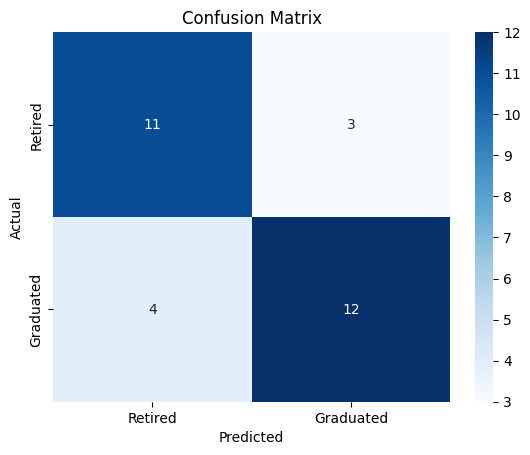

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Epoch 1 - Train Loss: 0.6721238791942596 | Train Acc: 0.5714285714285714
Epoch 1 - Val Loss: 0.5613812208175659 | Val Acc: 0.875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 2 - Train Loss: 0.588178813457489 | Train Acc: 0.7428571428571429
Epoch 2 - Val Loss: 0.6483902335166931 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 3 - Train Loss: 0.5761801600456238 | Train Acc: 0.6857142857142857
Epoch 3 - Val Loss: 0.46767133474349976 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 4 - Train Loss: 0.5640348792076111 | Train Acc: 0.7238095238095238
Epoch 4 - Val Loss: 0.4769127368927002 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 5 - Train Loss: 0.5254999250173569 | Train Acc: 0.7523809523809524
Epoch 5 - Val Loss: 0.6443842649459839 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 6 - Train Loss: 0.5564360022544861 | Train Acc: 0.7428571428571429
Epoch 6 - Val Loss: 0.5290210843086243 | Val Acc: 0.625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 7 - Train Loss: 0.5234297811985016 | Train Acc: 0.7619047619047619
Epoch 7 - Val Loss: 0.43590494990348816 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 8 - Train Loss: 0.5201673209667206 | Train Acc: 0.7333333333333333
Epoch 8 - Val Loss: 0.4431006610393524 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 9 - Train Loss: 0.4976496696472168 | Train Acc: 0.7904761904761904
Epoch 9 - Val Loss: 0.49137598276138306 | Val Acc: 0.625


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Epoch 10 - Train Loss: 0.4938381016254425 | Train Acc: 0.780952380952381
Epoch 10 - Val Loss: 0.42972642183303833 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 11 - Train Loss: 0.4638998806476593 | Train Acc: 0.780952380952381
Epoch 11 - Val Loss: 0.3968348205089569 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 12 - Train Loss: 0.45164501667022705 | Train Acc: 0.780952380952381
Epoch 12 - Val Loss: 0.39358505606651306 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 13 - Train Loss: 0.4326532930135727 | Train Acc: 0.8095238095238095
Epoch 13 - Val Loss: 0.4004133939743042 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 14 - Train Loss: 0.4016118198633194 | Train Acc: 0.819047619047619
Epoch 14 - Val Loss: 0.3621046245098114 | Val Acc: 0.875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 15 - Train Loss: 0.3924712538719177 | Train Acc: 0.819047619047619
Epoch 15 - Val Loss: 0.3597266972064972 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 16 - Train Loss: 0.38416483998298645 | Train Acc: 0.8666666666666667
Epoch 16 - Val Loss: 0.32448145747184753 | Val Acc: 0.875


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 17 - Train Loss: 0.3517514020204544 | Train Acc: 0.8476190476190476
Epoch 17 - Val Loss: 0.3489593267440796 | Val Acc: 0.875


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 18 - Train Loss: 0.3296274095773697 | Train Acc: 0.8761904761904762
Epoch 18 - Val Loss: 0.32251787185668945 | Val Acc: 0.875


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 19 - Train Loss: 0.31132006645202637 | Train Acc: 0.8857142857142857
Epoch 19 - Val Loss: 0.307574599981308 | Val Acc: 0.875


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 20 - Train Loss: 0.299414299428463 | Train Acc: 0.8571428571428571
Epoch 20 - Val Loss: 0.34333571791648865 | Val Acc: 0.875


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 21 - Train Loss: 0.26303622126579285 | Train Acc: 0.8952380952380953
Epoch 21 - Val Loss: 0.2992589473724365 | Val Acc: 0.875


Validation Epoch 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 22 - Train Loss: 0.2708524838089943 | Train Acc: 0.9047619047619048
Epoch 22 - Val Loss: 0.3120978772640228 | Val Acc: 0.875


Validation Epoch 23/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 23 - Train Loss: 0.23681488633155823 | Train Acc: 0.8857142857142857
Epoch 23 - Val Loss: 0.42687544226646423 | Val Acc: 0.875


Validation Epoch 24/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 24 - Train Loss: 0.17142386734485626 | Train Acc: 0.9238095238095239
Epoch 24 - Val Loss: 0.6848920583724976 | Val Acc: 0.8125


Validation Epoch 25/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 25 - Train Loss: 0.16727450489997864 | Train Acc: 0.9333333333333333
Epoch 25 - Val Loss: 0.4611670970916748 | Val Acc: 0.75


Validation Epoch 26/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 26 - Train Loss: 0.16890592500567436 | Train Acc: 0.9238095238095239
Epoch 26 - Val Loss: 0.49892234802246094 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Test Accuracy: 0.7333


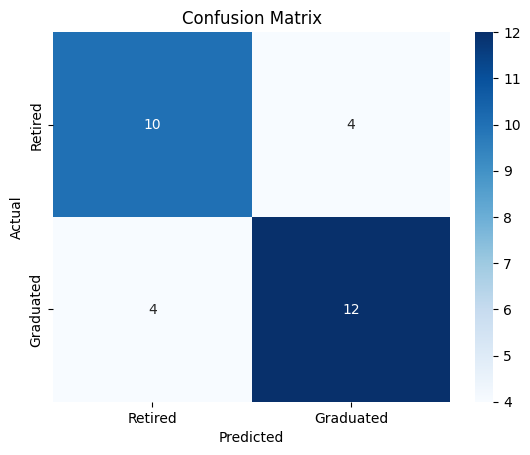

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 1 - Train Loss: 0.720902178968702 | Train Acc: 0.5333333333333333
Epoch 1 - Val Loss: 0.8885732889175415 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 2 - Train Loss: 0.6745700495583671 | Train Acc: 0.6190476190476191
Epoch 2 - Val Loss: 0.7039012312889099 | Val Acc: 0.4375


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 3 - Train Loss: 0.6866857920374189 | Train Acc: 0.5238095238095238
Epoch 3 - Val Loss: 0.6851420998573303 | Val Acc: 0.625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 4 - Train Loss: 0.7405041285923549 | Train Acc: 0.4857142857142857
Epoch 4 - Val Loss: 0.702494740486145 | Val Acc: 0.4375


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 5 - Train Loss: 0.7014950002942767 | Train Acc: 0.5047619047619047
Epoch 5 - Val Loss: 0.6846110820770264 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 6 - Train Loss: 0.7094152740069798 | Train Acc: 0.5047619047619047
Epoch 6 - Val Loss: 0.6874666810035706 | Val Acc: 0.5625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 7 - Train Loss: 0.7104700803756714 | Train Acc: 0.4857142857142857
Epoch 7 - Val Loss: 0.6828913688659668 | Val Acc: 0.5625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 8 - Train Loss: 0.6817404883248466 | Train Acc: 0.5619047619047619
Epoch 8 - Val Loss: 0.7363721132278442 | Val Acc: 0.5625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 9 - Train Loss: 0.6905271581241063 | Train Acc: 0.6285714285714286
Epoch 9 - Val Loss: 0.6751124262809753 | Val Acc: 0.625


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 10 - Train Loss: 0.6998882634299142 | Train Acc: 0.6095238095238096
Epoch 10 - Val Loss: 0.6561428308486938 | Val Acc: 0.625


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 11 - Train Loss: 0.6940699645451137 | Train Acc: 0.6285714285714286
Epoch 11 - Val Loss: 0.6684129238128662 | Val Acc: 0.625


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 12 - Train Loss: 0.6482227700097221 | Train Acc: 0.6476190476190476
Epoch 12 - Val Loss: 0.6510379910469055 | Val Acc: 0.625


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 13 - Train Loss: 0.6494759065764291 | Train Acc: 0.6476190476190476
Epoch 13 - Val Loss: 0.6530743837356567 | Val Acc: 0.625


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 14 - Train Loss: 0.682114703314645 | Train Acc: 0.6
Epoch 14 - Val Loss: 0.6545296311378479 | Val Acc: 0.625


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 15 - Train Loss: 0.6481899448803493 | Train Acc: 0.6285714285714286
Epoch 15 - Val Loss: 0.6510105133056641 | Val Acc: 0.625


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 16 - Train Loss: 0.6666658094951085 | Train Acc: 0.6095238095238096
Epoch 16 - Val Loss: 0.6519198417663574 | Val Acc: 0.625


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 17 - Train Loss: 0.7222433856555394 | Train Acc: 0.638095238095238
Epoch 17 - Val Loss: 0.6582033634185791 | Val Acc: 0.625


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 18 - Train Loss: 0.6403640508651733 | Train Acc: 0.6285714285714286
Epoch 18 - Val Loss: 0.6804754734039307 | Val Acc: 0.4375


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 19 - Train Loss: 0.6652508292879377 | Train Acc: 0.580952380952381
Epoch 19 - Val Loss: 0.6504719853401184 | Val Acc: 0.625


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 20 - Train Loss: 0.6610538789204189 | Train Acc: 0.6476190476190476
Epoch 20 - Val Loss: 0.653590202331543 | Val Acc: 0.625


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 21 - Train Loss: 0.6606071080480304 | Train Acc: 0.6095238095238096
Epoch 21 - Val Loss: 0.6543977856636047 | Val Acc: 0.625


Validation Epoch 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 22 - Train Loss: 0.6659706405230931 | Train Acc: 0.638095238095238
Epoch 22 - Val Loss: 0.6569427251815796 | Val Acc: 0.625


Validation Epoch 23/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 23 - Train Loss: 0.6529425638062614 | Train Acc: 0.6190476190476191
Epoch 23 - Val Loss: 0.6564094424247742 | Val Acc: 0.625


Validation Epoch 24/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 24 - Train Loss: 0.6594807250159127 | Train Acc: 0.5904761904761905
Epoch 24 - Val Loss: 0.6476147174835205 | Val Acc: 0.625


Validation Epoch 25/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 25 - Train Loss: 0.656135618686676 | Train Acc: 0.6285714285714286
Epoch 25 - Val Loss: 0.6489564180374146 | Val Acc: 0.625


Validation Epoch 26/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 26 - Train Loss: 0.6516892526830945 | Train Acc: 0.638095238095238
Epoch 26 - Val Loss: 0.6518380045890808 | Val Acc: 0.625


Validation Epoch 27/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 27 - Train Loss: 0.6614334242684501 | Train Acc: 0.638095238095238
Epoch 27 - Val Loss: 0.6554761528968811 | Val Acc: 0.625


Validation Epoch 28/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 28 - Train Loss: 0.6854710749217442 | Train Acc: 0.638095238095238
Epoch 28 - Val Loss: 0.6517152190208435 | Val Acc: 0.625


Validation Epoch 29/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 29 - Train Loss: 0.6658939634050641 | Train Acc: 0.580952380952381
Epoch 29 - Val Loss: 0.6504958271980286 | Val Acc: 0.625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


Test Accuracy: 0.7000


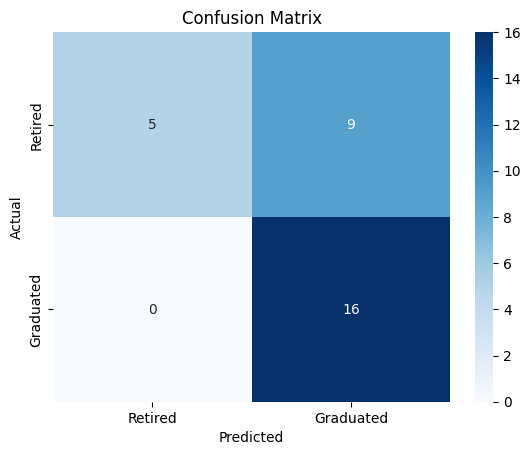

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 1 - Train Loss: 0.8021927028894424 | Train Acc: 0.44761904761904764
Epoch 1 - Val Loss: 0.6746554374694824 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 2 - Train Loss: 0.7462277263402939 | Train Acc: 0.5238095238095238
Epoch 2 - Val Loss: 0.6841430068016052 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 3 - Train Loss: 0.7112095654010773 | Train Acc: 0.5142857142857142
Epoch 3 - Val Loss: 0.6826866269111633 | Val Acc: 0.5625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 4 - Train Loss: 0.6886583864688873 | Train Acc: 0.5619047619047619
Epoch 4 - Val Loss: 0.6698948740959167 | Val Acc: 0.5625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 5 - Train Loss: 0.6559685319662094 | Train Acc: 0.5714285714285714
Epoch 5 - Val Loss: 0.6733149886131287 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 6 - Train Loss: 0.6955544352531433 | Train Acc: 0.5714285714285714
Epoch 6 - Val Loss: 0.7269861698150635 | Val Acc: 0.25


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 7 - Train Loss: 0.6714510917663574 | Train Acc: 0.6476190476190476
Epoch 7 - Val Loss: 0.8434581756591797 | Val Acc: 0.4375


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 8 - Train Loss: 0.6527426689863205 | Train Acc: 0.6190476190476191
Epoch 8 - Val Loss: 0.5256960391998291 | Val Acc: 0.75


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 9 - Train Loss: 0.5889086425304413 | Train Acc: 0.7047619047619048
Epoch 9 - Val Loss: 0.7988625764846802 | Val Acc: 0.4375


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Epoch 10 - Train Loss: 0.6499304324388504 | Train Acc: 0.6761904761904762
Epoch 10 - Val Loss: 0.540651261806488 | Val Acc: 0.6875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 11 - Train Loss: 0.6863047033548355 | Train Acc: 0.6857142857142857
Epoch 11 - Val Loss: 0.5837661623954773 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 12 - Train Loss: 0.6701520830392838 | Train Acc: 0.6
Epoch 12 - Val Loss: 0.6907870769500732 | Val Acc: 0.5625


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 13 - Train Loss: 0.697674497961998 | Train Acc: 0.5619047619047619
Epoch 13 - Val Loss: 0.6860073208808899 | Val Acc: 0.5625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Test Accuracy: 0.5333


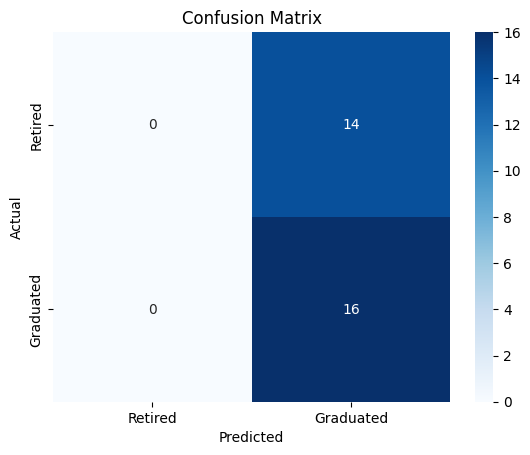

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1 - Train Loss: 0.7033208906650543 | Train Acc: 0.5142857142857142
Epoch 1 - Val Loss: 0.6224114298820496 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 2 - Train Loss: 0.6776217222213745 | Train Acc: 0.580952380952381
Epoch 2 - Val Loss: 0.7477579116821289 | Val Acc: 0.125


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 3 - Train Loss: 0.7069782018661499 | Train Acc: 0.5238095238095238
Epoch 3 - Val Loss: 0.8939898610115051 | Val Acc: 0.4375


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 4 - Train Loss: 0.7572543323040009 | Train Acc: 0.47619047619047616
Epoch 4 - Val Loss: 0.7101984620094299 | Val Acc: 0.5625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 5 - Train Loss: 0.7687791287899017 | Train Acc: 0.5238095238095238
Epoch 5 - Val Loss: 0.6882414221763611 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 6 - Train Loss: 0.7104932963848114 | Train Acc: 0.4857142857142857
Epoch 6 - Val Loss: 0.7159028649330139 | Val Acc: 0.4375
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Test Accuracy: 0.4667


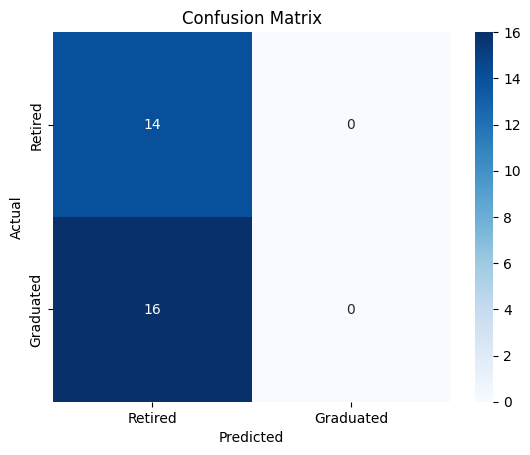

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 1 - Train Loss: 0.672817621912275 | Train Acc: 0.5714285714285714
Epoch 1 - Val Loss: 0.5743627548217773 | Val Acc: 0.875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 2 - Train Loss: 0.627760648727417 | Train Acc: 0.6761904761904762
Epoch 2 - Val Loss: 0.5139635801315308 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 3 - Train Loss: 0.6326839923858643 | Train Acc: 0.6761904761904762
Epoch 3 - Val Loss: 0.5232875347137451 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Epoch 4 - Train Loss: 0.5688239761761257 | Train Acc: 0.7238095238095238
Epoch 4 - Val Loss: 0.49447518587112427 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 5 - Train Loss: 0.5852956005505153 | Train Acc: 0.6857142857142857
Epoch 5 - Val Loss: 0.542410135269165 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 6 - Train Loss: 0.5563062301703862 | Train Acc: 0.7428571428571429
Epoch 6 - Val Loss: 0.538986325263977 | Val Acc: 0.6875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 7 - Train Loss: 0.537241301366261 | Train Acc: 0.7714285714285715
Epoch 7 - Val Loss: 0.4643442928791046 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 8 - Train Loss: 0.5125782191753387 | Train Acc: 0.7523809523809524
Epoch 8 - Val Loss: 0.4341545104980469 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 9 - Train Loss: 0.5624386114733559 | Train Acc: 0.7333333333333333
Epoch 9 - Val Loss: 0.42456164956092834 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 10 - Train Loss: 0.5035779178142548 | Train Acc: 0.7714285714285715
Epoch 10 - Val Loss: 0.4068883955478668 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 11 - Train Loss: 0.52700218132564 | Train Acc: 0.7523809523809524
Epoch 11 - Val Loss: 0.4047066569328308 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 12 - Train Loss: 0.49634940709386555 | Train Acc: 0.7523809523809524
Epoch 12 - Val Loss: 0.4147825241088867 | Val Acc: 0.875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 13 - Train Loss: 0.5184477184500013 | Train Acc: 0.780952380952381
Epoch 13 - Val Loss: 0.3965514302253723 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 14 - Train Loss: 0.4919440448284149 | Train Acc: 0.8
Epoch 14 - Val Loss: 0.4020515978336334 | Val Acc: 0.875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 15 - Train Loss: 0.4984445869922638 | Train Acc: 0.7428571428571429
Epoch 15 - Val Loss: 0.4313840866088867 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 16 - Train Loss: 0.4907758959702083 | Train Acc: 0.7619047619047619
Epoch 16 - Val Loss: 0.40704572200775146 | Val Acc: 0.875


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 17 - Train Loss: 0.4785520136356354 | Train Acc: 0.7714285714285715
Epoch 17 - Val Loss: 0.42545196413993835 | Val Acc: 0.875


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 18 - Train Loss: 0.45979091099330355 | Train Acc: 0.7714285714285715
Epoch 18 - Val Loss: 0.4114747643470764 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]



Test Accuracy: 0.7667


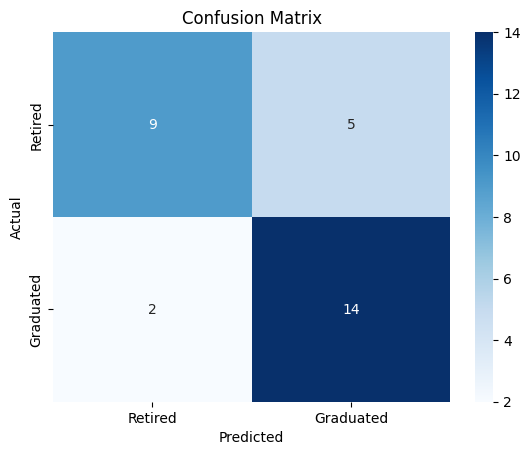

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 1 - Train Loss: 0.6856028884649277 | Train Acc: 0.5714285714285714
Epoch 1 - Val Loss: 0.6242464780807495 | Val Acc: 0.75


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 2 - Train Loss: 0.6399086713790894 | Train Acc: 0.7047619047619048
Epoch 2 - Val Loss: 0.6327255368232727 | Val Acc: 0.625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 3 - Train Loss: 0.6243603229522705 | Train Acc: 0.6761904761904762
Epoch 3 - Val Loss: 0.5506195425987244 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 4 - Train Loss: 0.6020643711090088 | Train Acc: 0.6952380952380952
Epoch 4 - Val Loss: 0.5029524564743042 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 5 - Train Loss: 0.5810269713401794 | Train Acc: 0.7238095238095238
Epoch 5 - Val Loss: 0.5087926387786865 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Epoch 6 - Train Loss: 0.5869820266962051 | Train Acc: 0.7428571428571429
Epoch 6 - Val Loss: 0.5805239677429199 | Val Acc: 0.6875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 7 - Train Loss: 0.6162386387586594 | Train Acc: 0.6952380952380952
Epoch 7 - Val Loss: 0.6212924718856812 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 8 - Train Loss: 0.5601606220006943 | Train Acc: 0.7619047619047619
Epoch 8 - Val Loss: 0.5062824487686157 | Val Acc: 0.75


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 9 - Train Loss: 0.588787630200386 | Train Acc: 0.7333333333333333
Epoch 9 - Val Loss: 0.4601166248321533 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 10 - Train Loss: 0.5109288617968559 | Train Acc: 0.7428571428571429
Epoch 10 - Val Loss: 0.4485965669155121 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 11 - Train Loss: 0.5144633650779724 | Train Acc: 0.7619047619047619
Epoch 11 - Val Loss: 0.46577367186546326 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 12 - Train Loss: 0.5449788272380829 | Train Acc: 0.7523809523809524
Epoch 12 - Val Loss: 0.4607751965522766 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 13 - Train Loss: 0.5091071128845215 | Train Acc: 0.7333333333333333
Epoch 13 - Val Loss: 0.43913373351097107 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 14 - Train Loss: 0.47152628004550934 | Train Acc: 0.7714285714285715
Epoch 14 - Val Loss: 0.43240439891815186 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 15 - Train Loss: 0.5342526361346245 | Train Acc: 0.7333333333333333
Epoch 15 - Val Loss: 0.47285234928131104 | Val Acc: 0.8125


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 16 - Train Loss: 0.5237076207995415 | Train Acc: 0.7523809523809524
Epoch 16 - Val Loss: 0.4741816818714142 | Val Acc: 0.8125


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 17 - Train Loss: 0.5015018731355667 | Train Acc: 0.7714285714285715
Epoch 17 - Val Loss: 0.4518205523490906 | Val Acc: 0.8125


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 18 - Train Loss: 0.5558788329362869 | Train Acc: 0.780952380952381
Epoch 18 - Val Loss: 0.4299926161766052 | Val Acc: 0.875


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 19 - Train Loss: 0.5037529692053795 | Train Acc: 0.780952380952381
Epoch 19 - Val Loss: 0.42767903208732605 | Val Acc: 0.875


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 20 - Train Loss: 0.45302218943834305 | Train Acc: 0.7904761904761904
Epoch 20 - Val Loss: 0.4245803952217102 | Val Acc: 0.8125


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 21 - Train Loss: 0.4800005182623863 | Train Acc: 0.8
Epoch 21 - Val Loss: 0.41922175884246826 | Val Acc: 0.8125


Validation Epoch 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 22 - Train Loss: 0.4392969608306885 | Train Acc: 0.780952380952381
Epoch 22 - Val Loss: 0.43409809470176697 | Val Acc: 0.8125


Validation Epoch 23/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 23 - Train Loss: 0.44580207020044327 | Train Acc: 0.8
Epoch 23 - Val Loss: 0.4161825180053711 | Val Acc: 0.875


Validation Epoch 24/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 24 - Train Loss: 0.4798348844051361 | Train Acc: 0.7904761904761904
Epoch 24 - Val Loss: 0.4080519676208496 | Val Acc: 0.875


Validation Epoch 25/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 25 - Train Loss: 0.4080178663134575 | Train Acc: 0.8285714285714286
Epoch 25 - Val Loss: 0.40484628081321716 | Val Acc: 0.875


Validation Epoch 26/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 26 - Train Loss: 0.42599572241306305 | Train Acc: 0.8285714285714286
Epoch 26 - Val Loss: 0.4133381247520447 | Val Acc: 0.8125


Validation Epoch 27/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 27 - Train Loss: 0.5002159252762794 | Train Acc: 0.819047619047619
Epoch 27 - Val Loss: 0.40526968240737915 | Val Acc: 0.875


Validation Epoch 28/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 28 - Train Loss: 0.43045926839113235 | Train Acc: 0.8095238095238095
Epoch 28 - Val Loss: 0.4147734045982361 | Val Acc: 0.875


Validation Epoch 29/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 29 - Train Loss: 0.41612111777067184 | Train Acc: 0.8285714285714286
Epoch 29 - Val Loss: 0.43999233841896057 | Val Acc: 0.8125


Validation Epoch 30/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 30 - Train Loss: 0.4527610316872597 | Train Acc: 0.8571428571428571
Epoch 30 - Val Loss: 0.44250571727752686 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Test Accuracy: 0.8333


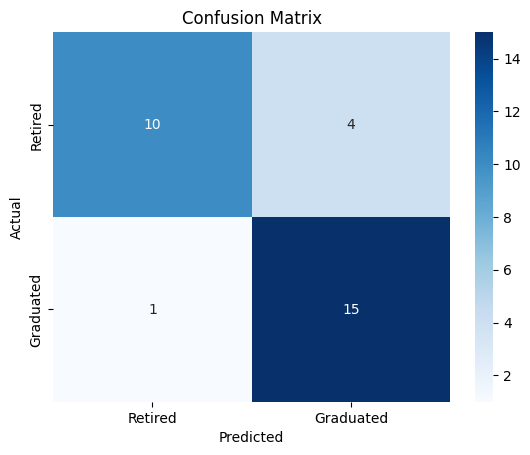

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 1 - Train Loss: 0.7387224435806274 | Train Acc: 0.4095238095238095
Epoch 1 - Val Loss: 0.6676875352859497 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 2 - Train Loss: 0.6948576271533966 | Train Acc: 0.5238095238095238
Epoch 2 - Val Loss: 0.6486068964004517 | Val Acc: 0.75


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 3 - Train Loss: 0.7049694061279297 | Train Acc: 0.4857142857142857
Epoch 3 - Val Loss: 0.6231557726860046 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 4 - Train Loss: 0.6351542770862579 | Train Acc: 0.6666666666666666
Epoch 4 - Val Loss: 0.5572584867477417 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 5 - Train Loss: 0.6298789978027344 | Train Acc: 0.6666666666666666
Epoch 5 - Val Loss: 0.5909703373908997 | Val Acc: 0.75


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 6 - Train Loss: 0.6133408546447754 | Train Acc: 0.6666666666666666
Epoch 6 - Val Loss: 0.5519086718559265 | Val Acc: 0.8125


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 7 - Train Loss: 0.5968608856201172 | Train Acc: 0.7142857142857143
Epoch 7 - Val Loss: 0.5424410104751587 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 8 - Train Loss: 0.6037968397140503 | Train Acc: 0.6952380952380952
Epoch 8 - Val Loss: 0.4753318727016449 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 9 - Train Loss: 0.5371018648147583 | Train Acc: 0.7238095238095238
Epoch 9 - Val Loss: 0.4841357469558716 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 10 - Train Loss: 0.5683274269104004 | Train Acc: 0.7333333333333333
Epoch 10 - Val Loss: 0.4672212302684784 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 11 - Train Loss: 0.5581893920898438 | Train Acc: 0.7523809523809524
Epoch 11 - Val Loss: 0.4422495663166046 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 12 - Train Loss: 0.5701025724411011 | Train Acc: 0.7333333333333333
Epoch 12 - Val Loss: 0.45197370648384094 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 13 - Train Loss: 0.5318492650985718 | Train Acc: 0.7523809523809524
Epoch 13 - Val Loss: 0.4383285939693451 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 14 - Train Loss: 0.5510019361972809 | Train Acc: 0.7428571428571429
Epoch 14 - Val Loss: 0.4463231861591339 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 15 - Train Loss: 0.5308507084846497 | Train Acc: 0.7523809523809524
Epoch 15 - Val Loss: 0.4492296576499939 | Val Acc: 0.8125


Validation Epoch 16/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 16 - Train Loss: 0.5283320546150208 | Train Acc: 0.7523809523809524
Epoch 16 - Val Loss: 0.4331735074520111 | Val Acc: 0.8125


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 17 - Train Loss: 0.4960664361715317 | Train Acc: 0.7904761904761904
Epoch 17 - Val Loss: 0.4214555025100708 | Val Acc: 0.8125


Validation Epoch 18/30: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 18 - Train Loss: 0.5066920816898346 | Train Acc: 0.7428571428571429
Epoch 18 - Val Loss: 0.4177582263946533 | Val Acc: 0.875


Validation Epoch 19/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 19 - Train Loss: 0.5111507773399353 | Train Acc: 0.7523809523809524
Epoch 19 - Val Loss: 0.4159930944442749 | Val Acc: 0.8125


Validation Epoch 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 20 - Train Loss: 0.5061183273792267 | Train Acc: 0.780952380952381
Epoch 20 - Val Loss: 0.42625945806503296 | Val Acc: 0.8125


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 21 - Train Loss: 0.4878091663122177 | Train Acc: 0.7714285714285715
Epoch 21 - Val Loss: 0.42854389548301697 | Val Acc: 0.8125


Validation Epoch 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 22 - Train Loss: 0.45812900364398956 | Train Acc: 0.7714285714285715
Epoch 22 - Val Loss: 0.4346608519554138 | Val Acc: 0.8125


Validation Epoch 23/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 23 - Train Loss: 0.4879417270421982 | Train Acc: 0.7714285714285715
Epoch 23 - Val Loss: 0.4426777958869934 | Val Acc: 0.8125


Validation Epoch 24/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 24 - Train Loss: 0.4975239336490631 | Train Acc: 0.7619047619047619
Epoch 24 - Val Loss: 0.44592297077178955 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Test Accuracy: 0.7667


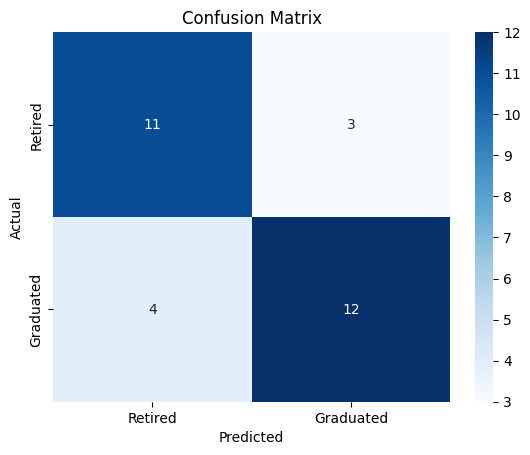

In [21]:
for i in range(20, 30):
  hyperparameters = hyperparameter_combinations[i]
  execute_hyperparameter_combination(
      hyperparameters['dropout'],
      hyperparameters['weight_decay'],
      hyperparameters['learning_rate'],
      hyperparameters['batch_size']
  )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Epoch 1 - Train Loss: 0.7574510489191327 | Train Acc: 0.47619047619047616
Epoch 1 - Val Loss: 0.659101128578186 | Val Acc: 0.875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 2 - Train Loss: 0.6907567637307304 | Train Acc: 0.49523809523809526
Epoch 2 - Val Loss: 0.6853243708610535 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 3 - Train Loss: 0.6977875488145011 | Train Acc: 0.5428571428571428
Epoch 3 - Val Loss: 0.6959267258644104 | Val Acc: 0.3125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 4 - Train Loss: 0.6847140959330967 | Train Acc: 0.6
Epoch 4 - Val Loss: 0.7427740097045898 | Val Acc: 0.4375


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 5 - Train Loss: 0.6383582779339382 | Train Acc: 0.6761904761904762
Epoch 5 - Val Loss: 0.6759819388389587 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 6 - Train Loss: 0.6717691676957267 | Train Acc: 0.6
Epoch 6 - Val Loss: 0.6971160769462585 | Val Acc: 0.4375
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


Test Accuracy: 0.4667


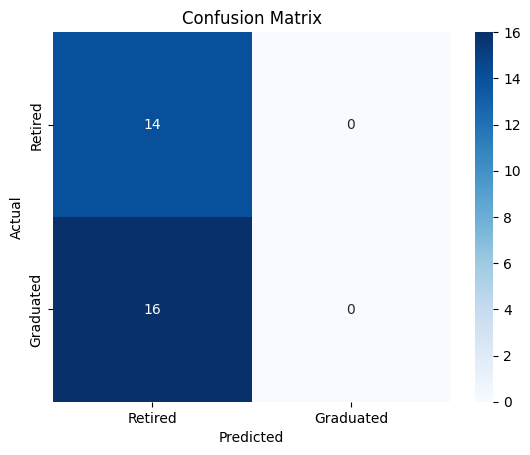

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1 - Train Loss: 0.6412095874547958 | Train Acc: 0.580952380952381
Epoch 1 - Val Loss: 0.6340776681900024 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Epoch 2 - Train Loss: 0.6496191322803497 | Train Acc: 0.5714285714285714
Epoch 2 - Val Loss: 0.509120523929596 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 3 - Train Loss: 0.5732753574848175 | Train Acc: 0.7238095238095238
Epoch 3 - Val Loss: 0.44787803292274475 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Epoch 4 - Train Loss: 0.6220437437295914 | Train Acc: 0.7047619047619048
Epoch 4 - Val Loss: 0.44560569524765015 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 5 - Train Loss: 0.5367806628346443 | Train Acc: 0.7619047619047619
Epoch 5 - Val Loss: 0.5239670276641846 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 6 - Train Loss: 0.5447744801640511 | Train Acc: 0.7619047619047619
Epoch 6 - Val Loss: 0.43695566058158875 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 7 - Train Loss: 0.5610217601060867 | Train Acc: 0.7523809523809524
Epoch 7 - Val Loss: 0.4590960741043091 | Val Acc: 0.75


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Epoch 8 - Train Loss: 0.5063965171575546 | Train Acc: 0.780952380952381
Epoch 8 - Val Loss: 0.5694610476493835 | Val Acc: 0.6875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 9 - Train Loss: 0.5714699029922485 | Train Acc: 0.7523809523809524
Epoch 9 - Val Loss: 0.44305893778800964 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Epoch 10 - Train Loss: 0.5315121561288834 | Train Acc: 0.7238095238095238
Epoch 10 - Val Loss: 0.4456041753292084 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Epoch 11 - Train Loss: 0.5567647442221642 | Train Acc: 0.8
Epoch 11 - Val Loss: 0.4450575113296509 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Test Accuracy: 0.8000


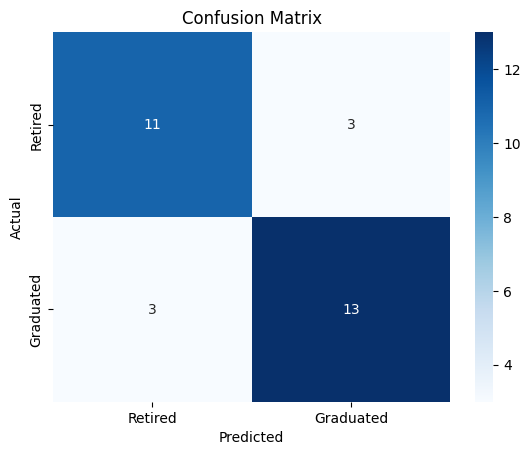

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 1 - Train Loss: 0.7421737611293793 | Train Acc: 0.4857142857142857
Epoch 1 - Val Loss: 0.6283984780311584 | Val Acc: 0.625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 2 - Train Loss: 0.6316447257995605 | Train Acc: 0.6
Epoch 2 - Val Loss: 0.6030533909797668 | Val Acc: 0.75


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Epoch 3 - Train Loss: 0.6398365795612335 | Train Acc: 0.6476190476190476
Epoch 3 - Val Loss: 0.567039430141449 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 4 - Train Loss: 0.5962037146091461 | Train Acc: 0.7333333333333333
Epoch 4 - Val Loss: 0.5228379368782043 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch 5 - Train Loss: 0.5672674477100372 | Train Acc: 0.7142857142857143
Epoch 5 - Val Loss: 0.5283663272857666 | Val Acc: 0.6875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Epoch 6 - Train Loss: 0.546452984213829 | Train Acc: 0.7523809523809524
Epoch 6 - Val Loss: 0.4686688184738159 | Val Acc: 0.8125


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 7 - Train Loss: 0.5550293326377869 | Train Acc: 0.7523809523809524
Epoch 7 - Val Loss: 0.48361948132514954 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Epoch 8 - Train Loss: 0.5532098412513733 | Train Acc: 0.7333333333333333
Epoch 8 - Val Loss: 0.5219854116439819 | Val Acc: 0.625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Epoch 9 - Train Loss: 0.510938748717308 | Train Acc: 0.7714285714285715
Epoch 9 - Val Loss: 0.48447391390800476 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Epoch 10 - Train Loss: 0.5250444710254669 | Train Acc: 0.7714285714285715
Epoch 10 - Val Loss: 0.50904780626297 | Val Acc: 0.75


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Epoch 11 - Train Loss: 0.5218847244977951 | Train Acc: 0.7714285714285715
Epoch 11 - Val Loss: 0.563532292842865 | Val Acc: 0.6875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Test Accuracy: 0.7667


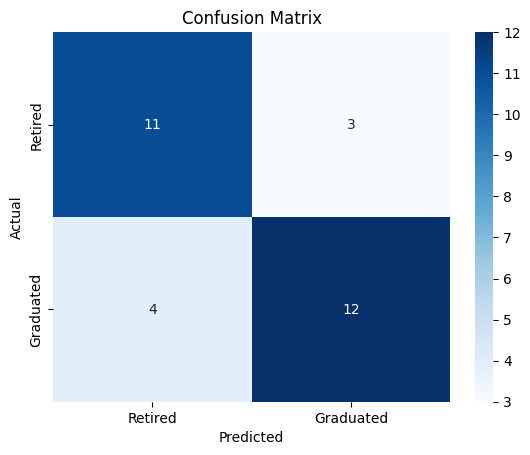

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 1 - Train Loss: 0.7386324320520673 | Train Acc: 0.4857142857142857
Epoch 1 - Val Loss: 0.6742727756500244 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 2 - Train Loss: 0.6976502111979893 | Train Acc: 0.5428571428571428
Epoch 2 - Val Loss: 0.6801279783248901 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 3 - Train Loss: 0.6780714733260018 | Train Acc: 0.5333333333333333
Epoch 3 - Val Loss: 0.6676972508430481 | Val Acc: 0.625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 4 - Train Loss: 0.7535110626901899 | Train Acc: 0.5238095238095238
Epoch 4 - Val Loss: 0.6743522882461548 | Val Acc: 0.625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 5 - Train Loss: 0.7136152897562299 | Train Acc: 0.5238095238095238
Epoch 5 - Val Loss: 0.7012410163879395 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 6 - Train Loss: 0.730231591633388 | Train Acc: 0.4666666666666667
Epoch 6 - Val Loss: 0.7018377780914307 | Val Acc: 0.4375


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 7 - Train Loss: 0.7219007866723197 | Train Acc: 0.5142857142857142
Epoch 7 - Val Loss: 0.6838803291320801 | Val Acc: 0.5625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 8 - Train Loss: 0.6804349167006356 | Train Acc: 0.6
Epoch 8 - Val Loss: 0.6784852147102356 | Val Acc: 0.625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


Test Accuracy: 0.8000


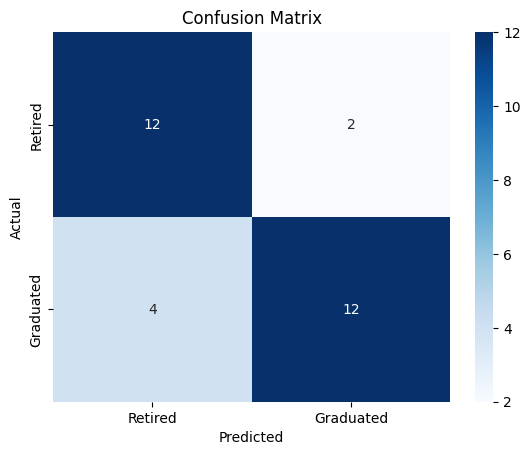

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 1 - Train Loss: 0.7045067548751831 | Train Acc: 0.49523809523809526
Epoch 1 - Val Loss: 0.6415501832962036 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 2 - Train Loss: 0.7106413692235947 | Train Acc: 0.5904761904761905
Epoch 2 - Val Loss: 0.5932339429855347 | Val Acc: 0.6875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 3 - Train Loss: 0.6570675224065781 | Train Acc: 0.6476190476190476
Epoch 3 - Val Loss: 0.5930978059768677 | Val Acc: 0.625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 4 - Train Loss: 0.5939540266990662 | Train Acc: 0.780952380952381
Epoch 4 - Val Loss: 0.5459378361701965 | Val Acc: 0.6875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 5 - Train Loss: 0.6950226724147797 | Train Acc: 0.6857142857142857
Epoch 5 - Val Loss: 0.555997371673584 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 6 - Train Loss: 0.609697699546814 | Train Acc: 0.6857142857142857
Epoch 6 - Val Loss: 0.5692351460456848 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 7 - Train Loss: 0.5840292572975159 | Train Acc: 0.7047619047619048
Epoch 7 - Val Loss: 0.6828515529632568 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 8 - Train Loss: 0.5436956137418747 | Train Acc: 0.7904761904761904
Epoch 8 - Val Loss: 0.39613911509513855 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 9 - Train Loss: 0.6921305358409882 | Train Acc: 0.6571428571428571
Epoch 9 - Val Loss: 0.7725113034248352 | Val Acc: 0.625


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Epoch 10 - Train Loss: 0.6610073894262314 | Train Acc: 0.6
Epoch 10 - Val Loss: 0.48004239797592163 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Epoch 11 - Train Loss: 0.5495539009571075 | Train Acc: 0.7333333333333333
Epoch 11 - Val Loss: 0.49133291840553284 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Epoch 12 - Train Loss: 0.5918049961328506 | Train Acc: 0.6761904761904762
Epoch 12 - Val Loss: 0.47158727049827576 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 13 - Train Loss: 0.5368593409657478 | Train Acc: 0.7428571428571429
Epoch 13 - Val Loss: 0.5982575416564941 | Val Acc: 0.6875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Test Accuracy: 0.7333


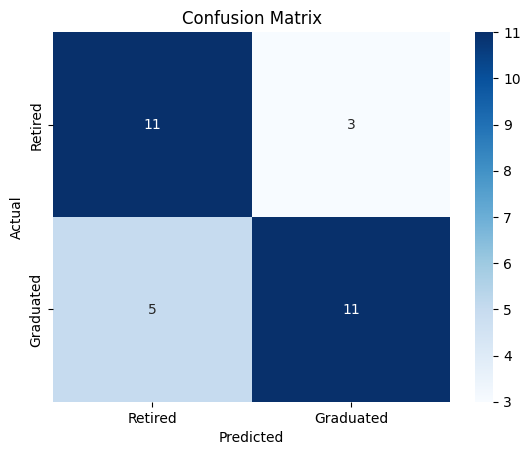

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch 1 - Train Loss: 0.6976062655448914 | Train Acc: 0.5619047619047619
Epoch 1 - Val Loss: 0.6397388577461243 | Val Acc: 0.6875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 2 - Train Loss: 0.6544366478919983 | Train Acc: 0.6095238095238096
Epoch 2 - Val Loss: 0.7816861867904663 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Epoch 3 - Train Loss: 0.7005545198917389 | Train Acc: 0.6
Epoch 3 - Val Loss: 0.6206539869308472 | Val Acc: 0.625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 4 - Train Loss: 0.7169217765331268 | Train Acc: 0.6095238095238096
Epoch 4 - Val Loss: 0.560433566570282 | Val Acc: 0.75


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 5 - Train Loss: 0.6178131401538849 | Train Acc: 0.6571428571428571
Epoch 5 - Val Loss: 0.6834599375724792 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Epoch 6 - Train Loss: 0.669593334197998 | Train Acc: 0.638095238095238
Epoch 6 - Val Loss: 0.6807944774627686 | Val Acc: 0.625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Epoch 7 - Train Loss: 0.6705647706985474 | Train Acc: 0.638095238095238
Epoch 7 - Val Loss: 0.6483515501022339 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 8 - Train Loss: 0.6696734130382538 | Train Acc: 0.6
Epoch 8 - Val Loss: 0.6711750626564026 | Val Acc: 0.5625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 9 - Train Loss: 0.6452062427997589 | Train Acc: 0.638095238095238
Epoch 9 - Val Loss: 0.6664787530899048 | Val Acc: 0.625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Test Accuracy: 0.7000


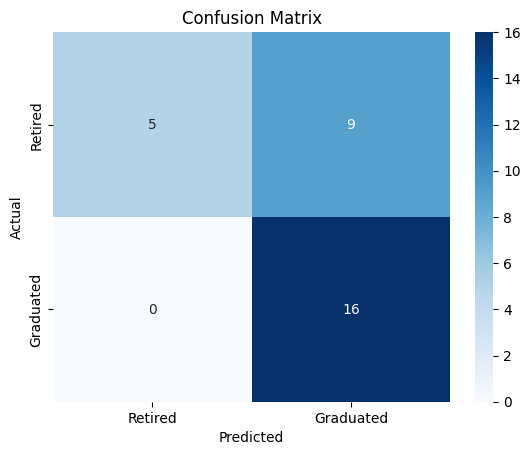

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Epoch 1 - Train Loss: 0.7183244058064052 | Train Acc: 0.5142857142857142
Epoch 1 - Val Loss: 0.6618838310241699 | Val Acc: 0.6875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 2 - Train Loss: 0.6745002014296395 | Train Acc: 0.6
Epoch 2 - Val Loss: 0.6243463158607483 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 3 - Train Loss: 0.6119776453290667 | Train Acc: 0.6761904761904762
Epoch 3 - Val Loss: 0.6145421862602234 | Val Acc: 0.625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch 4 - Train Loss: 0.5939797461032867 | Train Acc: 0.7428571428571429
Epoch 4 - Val Loss: 0.5665044188499451 | Val Acc: 0.6875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Epoch 5 - Train Loss: 0.5509603917598724 | Train Acc: 0.7047619047619048
Epoch 5 - Val Loss: 0.5742504596710205 | Val Acc: 0.6875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Epoch 6 - Train Loss: 0.6086909132344382 | Train Acc: 0.6857142857142857
Epoch 6 - Val Loss: 0.5363592505455017 | Val Acc: 0.625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Epoch 7 - Train Loss: 0.5733815218721118 | Train Acc: 0.7333333333333333
Epoch 7 - Val Loss: 0.5537487864494324 | Val Acc: 0.6875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Epoch 8 - Train Loss: 0.5321279764175415 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.5188956260681152 | Val Acc: 0.625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Epoch 9 - Train Loss: 0.554094306060246 | Train Acc: 0.7523809523809524
Epoch 9 - Val Loss: 0.5443353652954102 | Val Acc: 0.6875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 10 - Train Loss: 0.557718004499163 | Train Acc: 0.7714285714285715
Epoch 10 - Val Loss: 0.5057528018951416 | Val Acc: 0.6875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Epoch 11 - Train Loss: 0.5128423954759326 | Train Acc: 0.7714285714285715
Epoch 11 - Val Loss: 0.44724348187446594 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 12 - Train Loss: 0.5249358415603638 | Train Acc: 0.780952380952381
Epoch 12 - Val Loss: 0.4317069947719574 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Epoch 13 - Train Loss: 0.5312269883496421 | Train Acc: 0.7619047619047619
Epoch 13 - Val Loss: 0.4342004954814911 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 14 - Train Loss: 0.4856846332550049 | Train Acc: 0.780952380952381
Epoch 14 - Val Loss: 0.4382336139678955 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Epoch 15 - Train Loss: 0.5263535678386688 | Train Acc: 0.780952380952381
Epoch 15 - Val Loss: 0.46966108679771423 | Val Acc: 0.75


Validation Epoch 16/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 16 - Train Loss: 0.4880362110478537 | Train Acc: 0.780952380952381
Epoch 16 - Val Loss: 0.41385790705680847 | Val Acc: 0.8125


Validation Epoch 17/30: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Epoch 17 - Train Loss: 0.4698040613106319 | Train Acc: 0.7619047619047619
Epoch 17 - Val Loss: 0.4339953660964966 | Val Acc: 0.75


Validation Epoch 18/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 18 - Train Loss: 0.46269894923482624 | Train Acc: 0.7904761904761904
Epoch 18 - Val Loss: 0.4409617781639099 | Val Acc: 0.8125


Validation Epoch 19/30: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Epoch 19 - Train Loss: 0.47232538887432646 | Train Acc: 0.8
Epoch 19 - Val Loss: 0.4014805555343628 | Val Acc: 0.8125


Validation Epoch 20/30: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Epoch 20 - Train Loss: 0.4658076124531882 | Train Acc: 0.7904761904761904
Epoch 20 - Val Loss: 0.37418875098228455 | Val Acc: 0.875


Validation Epoch 21/30: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch 21 - Train Loss: 0.47227756466184345 | Train Acc: 0.8
Epoch 21 - Val Loss: 0.42022770643234253 | Val Acc: 0.8125


Validation Epoch 22/30: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 22 - Train Loss: 0.48660815613610403 | Train Acc: 0.7714285714285715
Epoch 22 - Val Loss: 0.3851712942123413 | Val Acc: 0.875


Validation Epoch 23/30: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 23 - Train Loss: 0.4798564910888672 | Train Acc: 0.8
Epoch 23 - Val Loss: 0.41674163937568665 | Val Acc: 0.875


Validation Epoch 24/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 24 - Train Loss: 0.46020221284457613 | Train Acc: 0.819047619047619
Epoch 24 - Val Loss: 0.4143413007259369 | Val Acc: 0.8125


Validation Epoch 25/30: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 25 - Train Loss: 0.5059350686413902 | Train Acc: 0.7714285714285715
Epoch 25 - Val Loss: 0.39620503783226013 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


Test Accuracy: 0.8000


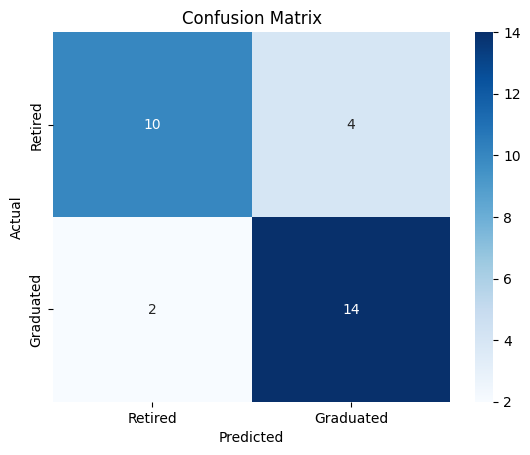

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 1 - Train Loss: 0.6672452688217163 | Train Acc: 0.5619047619047619
Epoch 1 - Val Loss: 0.6119654178619385 | Val Acc: 0.75


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 2 - Train Loss: 0.6425363719463348 | Train Acc: 0.638095238095238
Epoch 2 - Val Loss: 0.5428037047386169 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Epoch 3 - Train Loss: 0.5913221687078476 | Train Acc: 0.6952380952380952
Epoch 3 - Val Loss: 0.5445992946624756 | Val Acc: 0.6875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Epoch 4 - Train Loss: 0.5666462630033493 | Train Acc: 0.7238095238095238
Epoch 4 - Val Loss: 0.5083214640617371 | Val Acc: 0.75


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Epoch 5 - Train Loss: 0.5828751772642136 | Train Acc: 0.7142857142857143
Epoch 5 - Val Loss: 0.5129019021987915 | Val Acc: 0.75


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Epoch 6 - Train Loss: 0.5210605040192604 | Train Acc: 0.7714285714285715
Epoch 6 - Val Loss: 0.5415230989456177 | Val Acc: 0.6875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 7 - Train Loss: 0.5698363333940506 | Train Acc: 0.7238095238095238
Epoch 7 - Val Loss: 0.5496978759765625 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 8 - Train Loss: 0.49609042704105377 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.5629121661186218 | Val Acc: 0.6875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 9 - Train Loss: 0.5629803910851479 | Train Acc: 0.7714285714285715
Epoch 9 - Val Loss: 0.514589250087738 | Val Acc: 0.75
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Test Accuracy: 0.7333


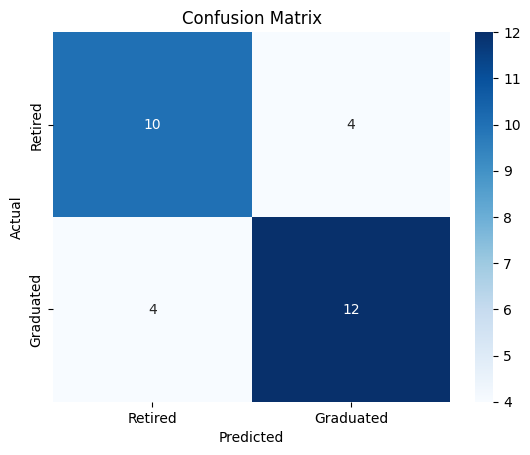

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 1 - Train Loss: 0.6812039017677307 | Train Acc: 0.5619047619047619
Epoch 1 - Val Loss: 0.6491432785987854 | Val Acc: 0.6875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch 2 - Train Loss: 0.6698350012302399 | Train Acc: 0.6190476190476191
Epoch 2 - Val Loss: 0.6069254875183105 | Val Acc: 0.8125


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch 3 - Train Loss: 0.633223831653595 | Train Acc: 0.7238095238095238
Epoch 3 - Val Loss: 0.5663226842880249 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


Epoch 4 - Train Loss: 0.6133677661418915 | Train Acc: 0.6666666666666666
Epoch 4 - Val Loss: 0.5647989511489868 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 5 - Train Loss: 0.5971654951572418 | Train Acc: 0.6857142857142857
Epoch 5 - Val Loss: 0.5673546195030212 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 6 - Train Loss: 0.5767435729503632 | Train Acc: 0.7619047619047619
Epoch 6 - Val Loss: 0.5416139364242554 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 7 - Train Loss: 0.6173116266727448 | Train Acc: 0.7238095238095238
Epoch 7 - Val Loss: 0.5063881874084473 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 8 - Train Loss: 0.6091964840888977 | Train Acc: 0.6952380952380952
Epoch 8 - Val Loss: 0.47279468178749084 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch 9 - Train Loss: 0.5596620440483093 | Train Acc: 0.7238095238095238
Epoch 9 - Val Loss: 0.44895315170288086 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 10 - Train Loss: 0.5686720311641693 | Train Acc: 0.7333333333333333
Epoch 10 - Val Loss: 0.4345139265060425 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 11 - Train Loss: 0.5225269347429276 | Train Acc: 0.7619047619047619
Epoch 11 - Val Loss: 0.4351079761981964 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 12 - Train Loss: 0.5579235553741455 | Train Acc: 0.6857142857142857
Epoch 12 - Val Loss: 0.4497295916080475 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 13 - Train Loss: 0.508243590593338 | Train Acc: 0.7619047619047619
Epoch 13 - Val Loss: 0.4735119640827179 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 14 - Train Loss: 0.5956705212593079 | Train Acc: 0.7047619047619048
Epoch 14 - Val Loss: 0.5014557838439941 | Val Acc: 0.625


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Epoch 15 - Train Loss: 0.5533265173435211 | Train Acc: 0.7142857142857143
Epoch 15 - Val Loss: 0.49053576588630676 | Val Acc: 0.6875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Test Accuracy: 0.8000


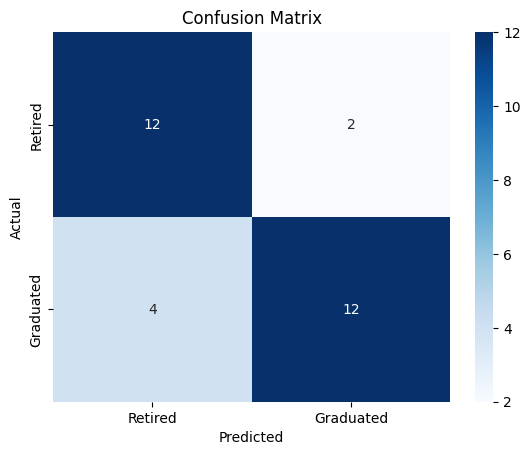

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 1 - Train Loss: 0.7156986168452671 | Train Acc: 0.5428571428571428
Epoch 1 - Val Loss: 0.6809269785881042 | Val Acc: 0.625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 2 - Train Loss: 0.6824508820261274 | Train Acc: 0.5904761904761905
Epoch 2 - Val Loss: 0.5975525379180908 | Val Acc: 0.625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 3 - Train Loss: 0.6201297470501491 | Train Acc: 0.6095238095238096
Epoch 3 - Val Loss: 0.5401546955108643 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 4 - Train Loss: 0.6135122648307255 | Train Acc: 0.6952380952380952
Epoch 4 - Val Loss: 0.47753065824508667 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 5 - Train Loss: 0.6618222338812692 | Train Acc: 0.6476190476190476
Epoch 5 - Val Loss: 0.6218396425247192 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Epoch 6 - Train Loss: 0.5814107741628375 | Train Acc: 0.6761904761904762
Epoch 6 - Val Loss: 0.552560031414032 | Val Acc: 0.8125


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 7 - Train Loss: 0.6285340658255986 | Train Acc: 0.6857142857142857
Epoch 7 - Val Loss: 0.4106261134147644 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 8 - Train Loss: 0.5244348389761788 | Train Acc: 0.7904761904761904
Epoch 8 - Val Loss: 0.4124414026737213 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 9 - Train Loss: 0.5594292112759182 | Train Acc: 0.7238095238095238
Epoch 9 - Val Loss: 0.4246331453323364 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 10 - Train Loss: 0.5611437261104584 | Train Acc: 0.7714285714285715
Epoch 10 - Val Loss: 0.509150505065918 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 11 - Train Loss: 0.5351327444825854 | Train Acc: 0.7619047619047619
Epoch 11 - Val Loss: 0.4530843496322632 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 12 - Train Loss: 0.482959691967283 | Train Acc: 0.7714285714285715
Epoch 12 - Val Loss: 0.4767332077026367 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


Test Accuracy: 0.7667


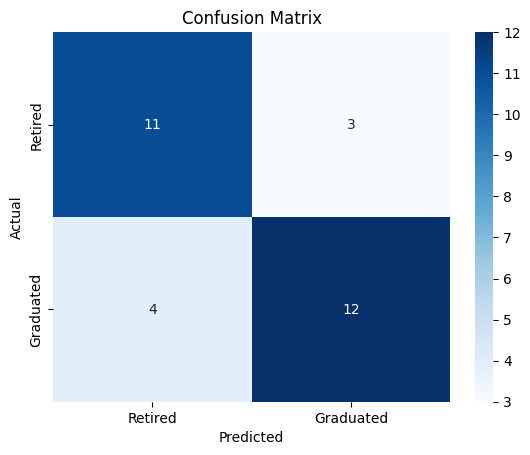

In [22]:
for i in range(30, 40):
  hyperparameters = hyperparameter_combinations[i]
  execute_hyperparameter_combination(
      hyperparameters['dropout'],
      hyperparameters['weight_decay'],
      hyperparameters['learning_rate'],
      hyperparameters['batch_size']
  )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 1 - Train Loss: 0.724312037229538 | Train Acc: 0.5047619047619047
Epoch 1 - Val Loss: 0.6144632697105408 | Val Acc: 0.6875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 2 - Train Loss: 0.6255189627408981 | Train Acc: 0.6571428571428571
Epoch 2 - Val Loss: 0.558484673500061 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 3 - Train Loss: 0.5831279158592224 | Train Acc: 0.7238095238095238
Epoch 3 - Val Loss: 0.573077380657196 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 4 - Train Loss: 0.5596216470003128 | Train Acc: 0.7714285714285715
Epoch 4 - Val Loss: 0.5488176345825195 | Val Acc: 0.625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 5 - Train Loss: 0.5825284719467163 | Train Acc: 0.7238095238095238
Epoch 5 - Val Loss: 0.4552672207355499 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 6 - Train Loss: 0.5856263339519501 | Train Acc: 0.7333333333333333
Epoch 6 - Val Loss: 0.3910409212112427 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 7 - Train Loss: 0.5532947480678558 | Train Acc: 0.7142857142857143
Epoch 7 - Val Loss: 0.44553396105766296 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch 8 - Train Loss: 0.48362890630960464 | Train Acc: 0.780952380952381
Epoch 8 - Val Loss: 0.4280933737754822 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 9 - Train Loss: 0.5350655019283295 | Train Acc: 0.7238095238095238
Epoch 9 - Val Loss: 0.4221782386302948 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 10 - Train Loss: 0.5782385319471359 | Train Acc: 0.7428571428571429
Epoch 10 - Val Loss: 0.45295533537864685 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 11 - Train Loss: 0.605743333697319 | Train Acc: 0.780952380952381
Epoch 11 - Val Loss: 0.40562471747398376 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Test Accuracy: 0.7333


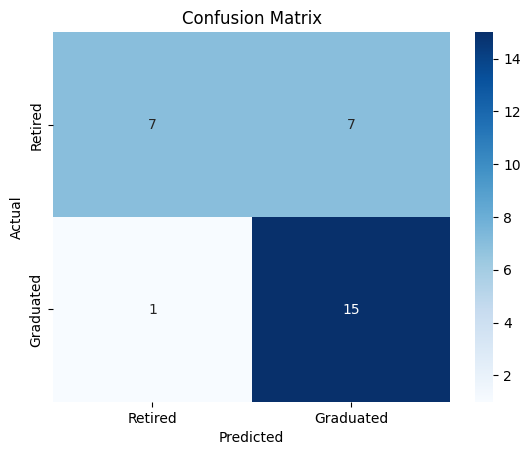

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 1 - Train Loss: 0.6890156269073486 | Train Acc: 0.5428571428571428
Epoch 1 - Val Loss: 0.6798908114433289 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 2 - Train Loss: 0.648571103811264 | Train Acc: 0.6095238095238096
Epoch 2 - Val Loss: 0.6440195441246033 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 3 - Train Loss: 0.5912294685840607 | Train Acc: 0.6952380952380952
Epoch 3 - Val Loss: 0.5045002102851868 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 4 - Train Loss: 0.6103691756725311 | Train Acc: 0.7142857142857143
Epoch 4 - Val Loss: 0.45640289783477783 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 5 - Train Loss: 0.5594505071640015 | Train Acc: 0.7047619047619048
Epoch 5 - Val Loss: 0.48392289876937866 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 6 - Train Loss: 0.5804656445980072 | Train Acc: 0.7523809523809524
Epoch 6 - Val Loss: 0.4877987205982208 | Val Acc: 0.8125


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch 7 - Train Loss: 0.5545626580715179 | Train Acc: 0.7619047619047619
Epoch 7 - Val Loss: 0.541789710521698 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch 8 - Train Loss: 0.5332403481006622 | Train Acc: 0.7333333333333333
Epoch 8 - Val Loss: 0.45689570903778076 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 9 - Train Loss: 0.49447867274284363 | Train Acc: 0.7333333333333333
Epoch 9 - Val Loss: 0.4537254869937897 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 10 - Train Loss: 0.4965355098247528 | Train Acc: 0.7428571428571429
Epoch 10 - Val Loss: 0.49793973565101624 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 11 - Train Loss: 0.5385625809431076 | Train Acc: 0.7428571428571429
Epoch 11 - Val Loss: 0.5139807462692261 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 12 - Train Loss: 0.5021965205669403 | Train Acc: 0.7714285714285715
Epoch 12 - Val Loss: 0.5186982154846191 | Val Acc: 0.6875


Validation Epoch 13/30: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 13 - Train Loss: 0.5670094788074493 | Train Acc: 0.7523809523809524
Epoch 13 - Val Loss: 0.4610641300678253 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 14 - Train Loss: 0.4822797477245331 | Train Acc: 0.7333333333333333
Epoch 14 - Val Loss: 0.45313286781311035 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 15 - Train Loss: 0.48791585862636566 | Train Acc: 0.780952380952381
Epoch 15 - Val Loss: 0.45873719453811646 | Val Acc: 0.8125


Validation Epoch 16/30: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 16 - Train Loss: 0.4870719015598297 | Train Acc: 0.8095238095238095
Epoch 16 - Val Loss: 0.46890774369239807 | Val Acc: 0.8125


Validation Epoch 17/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 17 - Train Loss: 0.46131017804145813 | Train Acc: 0.780952380952381
Epoch 17 - Val Loss: 0.42851951718330383 | Val Acc: 0.8125


Validation Epoch 18/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 18 - Train Loss: 0.4585206061601639 | Train Acc: 0.7714285714285715
Epoch 18 - Val Loss: 0.39184439182281494 | Val Acc: 0.875


Validation Epoch 19/30: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


Epoch 19 - Train Loss: 0.44150659441947937 | Train Acc: 0.8
Epoch 19 - Val Loss: 0.4058266580104828 | Val Acc: 0.8125


Validation Epoch 20/30: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 20 - Train Loss: 0.43707582354545593 | Train Acc: 0.7904761904761904
Epoch 20 - Val Loss: 0.5022674202919006 | Val Acc: 0.8125


Validation Epoch 21/30: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 21 - Train Loss: 0.44254811108112335 | Train Acc: 0.7714285714285715
Epoch 21 - Val Loss: 0.42768025398254395 | Val Acc: 0.8125


Validation Epoch 22/30: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 22 - Train Loss: 0.42704175412654877 | Train Acc: 0.8095238095238095
Epoch 22 - Val Loss: 0.39946797490119934 | Val Acc: 0.8125


Validation Epoch 23/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 23 - Train Loss: 0.419323205947876 | Train Acc: 0.819047619047619
Epoch 23 - Val Loss: 0.4129365384578705 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Test Accuracy: 0.7667


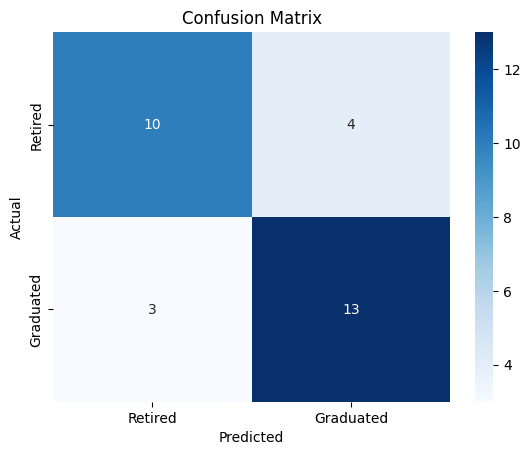

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 1 - Train Loss: 0.7658691491399493 | Train Acc: 0.5238095238095238
Epoch 1 - Val Loss: 0.6697457432746887 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 2 - Train Loss: 0.663811879498618 | Train Acc: 0.5619047619047619
Epoch 2 - Val Loss: 0.6141808032989502 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 3 - Train Loss: 0.7715964572770255 | Train Acc: 0.5619047619047619
Epoch 3 - Val Loss: 0.6935699582099915 | Val Acc: 0.4375


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 4 - Train Loss: 0.7174955010414124 | Train Acc: 0.4666666666666667
Epoch 4 - Val Loss: 0.6524559259414673 | Val Acc: 0.625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 5 - Train Loss: 0.6656306896890912 | Train Acc: 0.6571428571428571
Epoch 5 - Val Loss: 0.6702018976211548 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 6 - Train Loss: 0.6415097287722996 | Train Acc: 0.6571428571428571
Epoch 6 - Val Loss: 0.6529517769813538 | Val Acc: 0.625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 7 - Train Loss: 0.6762249725205558 | Train Acc: 0.6
Epoch 7 - Val Loss: 0.662864089012146 | Val Acc: 0.625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


Test Accuracy: 0.7000


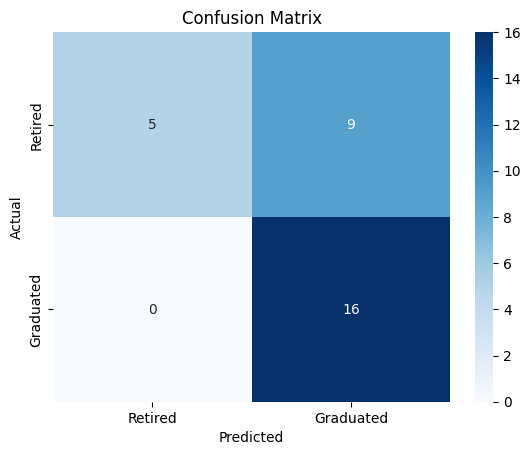

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 1 - Train Loss: 0.7419680207967758 | Train Acc: 0.49523809523809526
Epoch 1 - Val Loss: 0.6824281215667725 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 2 - Train Loss: 0.6761509925127029 | Train Acc: 0.5904761904761905
Epoch 2 - Val Loss: 0.6878898739814758 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 3 - Train Loss: 0.7521112859249115 | Train Acc: 0.45714285714285713
Epoch 3 - Val Loss: 0.656659722328186 | Val Acc: 0.625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 4 - Train Loss: 0.6212724298238754 | Train Acc: 0.6476190476190476
Epoch 4 - Val Loss: 0.6891418695449829 | Val Acc: 0.5625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 5 - Train Loss: 0.730167418718338 | Train Acc: 0.47619047619047616
Epoch 5 - Val Loss: 0.6921617984771729 | Val Acc: 0.4375


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 6 - Train Loss: 0.7013237774372101 | Train Acc: 0.4857142857142857
Epoch 6 - Val Loss: 0.6794183850288391 | Val Acc: 0.625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Epoch 7 - Train Loss: 0.7160171866416931 | Train Acc: 0.5714285714285714
Epoch 7 - Val Loss: 0.6830814480781555 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 8 - Train Loss: 0.7242900729179382 | Train Acc: 0.5428571428571428
Epoch 8 - Val Loss: 0.6802740693092346 | Val Acc: 0.5625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Test Accuracy: 0.5333


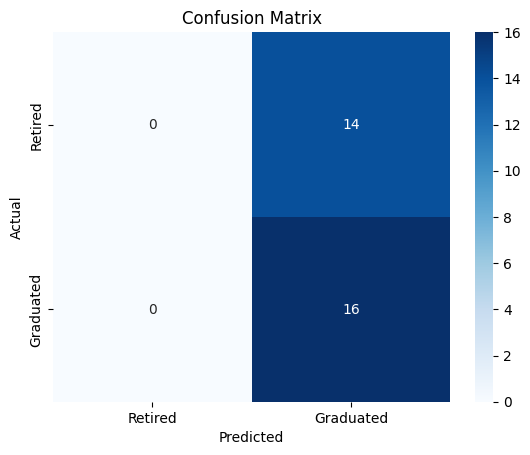

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 1 - Train Loss: 0.7132723033428192 | Train Acc: 0.5142857142857142
Epoch 1 - Val Loss: 0.6648249626159668 | Val Acc: 0.6875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 2 - Train Loss: 0.6308183670043945 | Train Acc: 0.6285714285714286
Epoch 2 - Val Loss: 0.6587812900543213 | Val Acc: 0.8125


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 3 - Train Loss: 0.6910412013530731 | Train Acc: 0.5333333333333333
Epoch 3 - Val Loss: 0.6900199055671692 | Val Acc: 0.5625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 4 - Train Loss: 0.6673422455787659 | Train Acc: 0.580952380952381
Epoch 4 - Val Loss: 0.6448585987091064 | Val Acc: 0.625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 5 - Train Loss: 0.7208094596862793 | Train Acc: 0.5333333333333333
Epoch 5 - Val Loss: 0.6762597560882568 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 6 - Train Loss: 0.7021432518959045 | Train Acc: 0.5142857142857142
Epoch 6 - Val Loss: 0.6766936182975769 | Val Acc: 0.5


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 7 - Train Loss: 0.6880476772785187 | Train Acc: 0.5142857142857142
Epoch 7 - Val Loss: 0.6332821846008301 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 8 - Train Loss: 0.6046400368213654 | Train Acc: 0.638095238095238
Epoch 8 - Val Loss: 0.5687669515609741 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 9 - Train Loss: 0.6325215995311737 | Train Acc: 0.6857142857142857
Epoch 9 - Val Loss: 0.6747696995735168 | Val Acc: 0.5


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 10 - Train Loss: 0.6044220328330994 | Train Acc: 0.7047619047619048
Epoch 10 - Val Loss: 0.45660004019737244 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 11 - Train Loss: 0.5866347253322601 | Train Acc: 0.6761904761904762
Epoch 11 - Val Loss: 0.6976537108421326 | Val Acc: 0.625


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 12 - Train Loss: 0.607596755027771 | Train Acc: 0.7238095238095238
Epoch 12 - Val Loss: 0.5397049188613892 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 13 - Train Loss: 0.6179972887039185 | Train Acc: 0.7047619047619048
Epoch 13 - Val Loss: 0.5275287628173828 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 14 - Train Loss: 0.5964047908782959 | Train Acc: 0.7333333333333333
Epoch 14 - Val Loss: 0.533284068107605 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 15 - Train Loss: 0.5839787721633911 | Train Acc: 0.7238095238095238
Epoch 15 - Val Loss: 0.6344260573387146 | Val Acc: 0.6875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]



Test Accuracy: 0.8000


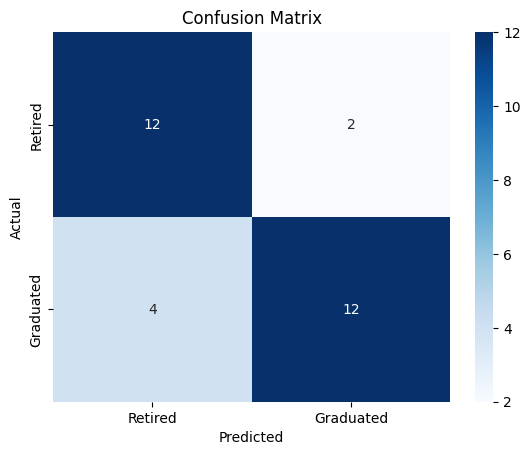

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Epoch 1 - Train Loss: 0.6811525651386806 | Train Acc: 0.5904761904761905
Epoch 1 - Val Loss: 0.6671332716941833 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 2 - Train Loss: 0.6040321333067757 | Train Acc: 0.7142857142857143
Epoch 2 - Val Loss: 0.5129371285438538 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 3 - Train Loss: 0.5839101757322039 | Train Acc: 0.7142857142857143
Epoch 3 - Val Loss: 0.4813084304332733 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


Epoch 4 - Train Loss: 0.5988522895744869 | Train Acc: 0.7047619047619048
Epoch 4 - Val Loss: 0.48247402906417847 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 5 - Train Loss: 0.610299927847726 | Train Acc: 0.6571428571428571
Epoch 5 - Val Loss: 0.47654709219932556 | Val Acc: 0.8125


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 6 - Train Loss: 0.5858224587781089 | Train Acc: 0.7238095238095238
Epoch 6 - Val Loss: 0.612734317779541 | Val Acc: 0.6875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 7 - Train Loss: 0.5603562593460083 | Train Acc: 0.7333333333333333
Epoch 7 - Val Loss: 0.4696846306324005 | Val Acc: 0.8125


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 8 - Train Loss: 0.5835762321949005 | Train Acc: 0.7047619047619048
Epoch 8 - Val Loss: 0.507396936416626 | Val Acc: 0.8125


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Epoch 9 - Train Loss: 0.513123848608562 | Train Acc: 0.7333333333333333
Epoch 9 - Val Loss: 0.555797815322876 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 10 - Train Loss: 0.5403124392032623 | Train Acc: 0.7428571428571429
Epoch 10 - Val Loss: 0.5613459944725037 | Val Acc: 0.6875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 11 - Train Loss: 0.5659000490392957 | Train Acc: 0.6857142857142857
Epoch 11 - Val Loss: 0.4893222749233246 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 12 - Train Loss: 0.526076648916517 | Train Acc: 0.7523809523809524
Epoch 12 - Val Loss: 0.4752489924430847 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Test Accuracy: 0.7333


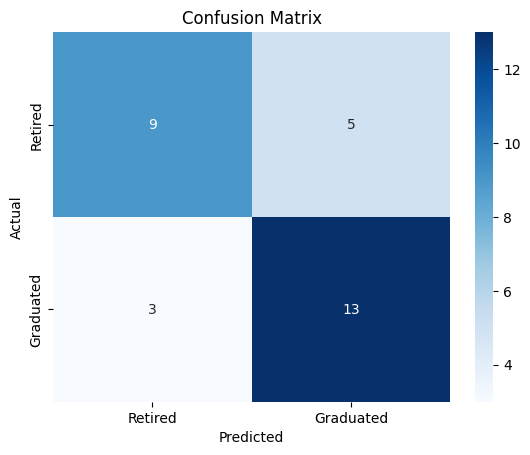

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch 1 - Train Loss: 0.6593059152364731 | Train Acc: 0.6095238095238096
Epoch 1 - Val Loss: 0.6494372487068176 | Val Acc: 0.6875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 2 - Train Loss: 0.6480052322149277 | Train Acc: 0.6285714285714286
Epoch 2 - Val Loss: 0.6443641185760498 | Val Acc: 0.6875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 3 - Train Loss: 0.6447415798902512 | Train Acc: 0.6190476190476191
Epoch 3 - Val Loss: 0.5255036950111389 | Val Acc: 0.8125


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 4 - Train Loss: 0.5758200734853745 | Train Acc: 0.7333333333333333
Epoch 4 - Val Loss: 0.5578382611274719 | Val Acc: 0.6875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Epoch 5 - Train Loss: 0.5870426297187805 | Train Acc: 0.7333333333333333
Epoch 5 - Val Loss: 0.5840988755226135 | Val Acc: 0.6875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Epoch 6 - Train Loss: 0.604388564825058 | Train Acc: 0.7238095238095238
Epoch 6 - Val Loss: 0.5723899602890015 | Val Acc: 0.6875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Epoch 7 - Train Loss: 0.5705219432711601 | Train Acc: 0.7333333333333333
Epoch 7 - Val Loss: 0.5308329463005066 | Val Acc: 0.6875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 8 - Train Loss: 0.5574130266904831 | Train Acc: 0.7523809523809524
Epoch 8 - Val Loss: 0.5686474442481995 | Val Acc: 0.6875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Test Accuracy: 0.7667


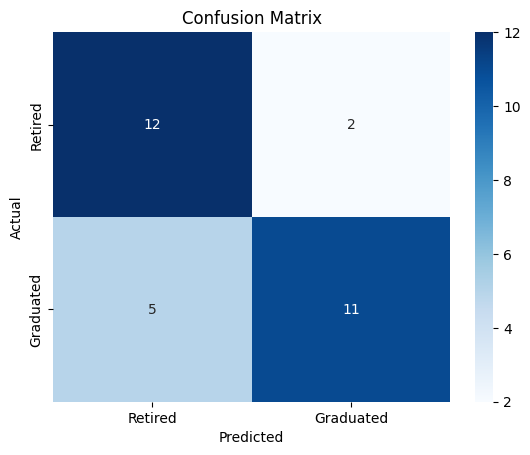

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch 1 - Train Loss: 0.7082151174545288 | Train Acc: 0.49523809523809526
Epoch 1 - Val Loss: 0.6641125679016113 | Val Acc: 0.75


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 2 - Train Loss: 0.6804667115211487 | Train Acc: 0.5333333333333333
Epoch 2 - Val Loss: 0.6000949144363403 | Val Acc: 0.875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 3 - Train Loss: 0.645115077495575 | Train Acc: 0.6285714285714286
Epoch 3 - Val Loss: 0.561677873134613 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 4 - Train Loss: 0.6301201283931732 | Train Acc: 0.6190476190476191
Epoch 4 - Val Loss: 0.5457126498222351 | Val Acc: 0.875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Epoch 5 - Train Loss: 0.5774538516998291 | Train Acc: 0.7333333333333333
Epoch 5 - Val Loss: 0.5445661544799805 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 6 - Train Loss: 0.5796775817871094 | Train Acc: 0.7142857142857143
Epoch 6 - Val Loss: 0.5950259566307068 | Val Acc: 0.6875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 7 - Train Loss: 0.5724542438983917 | Train Acc: 0.7428571428571429
Epoch 7 - Val Loss: 0.5817645192146301 | Val Acc: 0.6875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


Epoch 8 - Train Loss: 0.5523706674575806 | Train Acc: 0.7333333333333333
Epoch 8 - Val Loss: 0.5984782576560974 | Val Acc: 0.625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 9 - Train Loss: 0.5550887286663055 | Train Acc: 0.7428571428571429
Epoch 9 - Val Loss: 0.5278940200805664 | Val Acc: 0.6875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 10 - Train Loss: 0.5656291544437408 | Train Acc: 0.7333333333333333
Epoch 10 - Val Loss: 0.4915562570095062 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 11 - Train Loss: 0.5438142418861389 | Train Acc: 0.7523809523809524
Epoch 11 - Val Loss: 0.4963173270225525 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Epoch 12 - Train Loss: 0.5529438555240631 | Train Acc: 0.7428571428571429
Epoch 12 - Val Loss: 0.5299097299575806 | Val Acc: 0.625


Validation Epoch 13/30: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 13 - Train Loss: 0.5468968451023102 | Train Acc: 0.780952380952381
Epoch 13 - Val Loss: 0.5621219277381897 | Val Acc: 0.6875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Epoch 14 - Train Loss: 0.5281640142202377 | Train Acc: 0.7428571428571429
Epoch 14 - Val Loss: 0.5792199969291687 | Val Acc: 0.6875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Epoch 15 - Train Loss: 0.5317812860012054 | Train Acc: 0.7523809523809524
Epoch 15 - Val Loss: 0.5574737191200256 | Val Acc: 0.6875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Test Accuracy: 0.7333


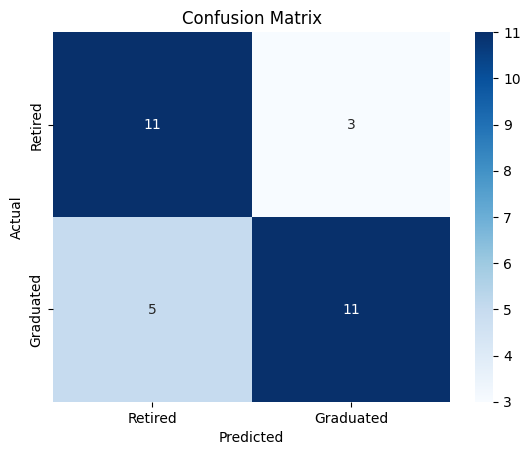

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


Epoch 1 - Train Loss: 0.6661551254136222 | Train Acc: 0.5523809523809524
Epoch 1 - Val Loss: 0.5437279939651489 | Val Acc: 0.8125


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Epoch 2 - Train Loss: 0.6283846071788243 | Train Acc: 0.6761904761904762
Epoch 2 - Val Loss: 0.5626832246780396 | Val Acc: 0.6875


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


Epoch 3 - Train Loss: 0.5891602805682591 | Train Acc: 0.6952380952380952
Epoch 3 - Val Loss: 0.5161791443824768 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Epoch 4 - Train Loss: 0.5594808118683952 | Train Acc: 0.7142857142857143
Epoch 4 - Val Loss: 0.46767500042915344 | Val Acc: 0.8125


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


Epoch 5 - Train Loss: 0.5585663488933018 | Train Acc: 0.7333333333333333
Epoch 5 - Val Loss: 0.4058946967124939 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Epoch 6 - Train Loss: 0.5850039550236293 | Train Acc: 0.7047619047619048
Epoch 6 - Val Loss: 0.37788063287734985 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Epoch 7 - Train Loss: 0.5270878417151315 | Train Acc: 0.7714285714285715
Epoch 7 - Val Loss: 0.40151363611221313 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 8 - Train Loss: 0.4860767935003553 | Train Acc: 0.7904761904761904
Epoch 8 - Val Loss: 0.35588303208351135 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 9 - Train Loss: 0.5511293028082166 | Train Acc: 0.7619047619047619
Epoch 9 - Val Loss: 0.40087783336639404 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 10 - Train Loss: 0.4780705102852413 | Train Acc: 0.7904761904761904
Epoch 10 - Val Loss: 0.41167744994163513 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 11 - Train Loss: 0.4807097486087254 | Train Acc: 0.8
Epoch 11 - Val Loss: 0.37304234504699707 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 12 - Train Loss: 0.47484908785138813 | Train Acc: 0.8
Epoch 12 - Val Loss: 0.4345490634441376 | Val Acc: 0.8125


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 13 - Train Loss: 0.5413520549024854 | Train Acc: 0.7714285714285715
Epoch 13 - Val Loss: 0.43900689482688904 | Val Acc: 0.8125
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Test Accuracy: 0.8333


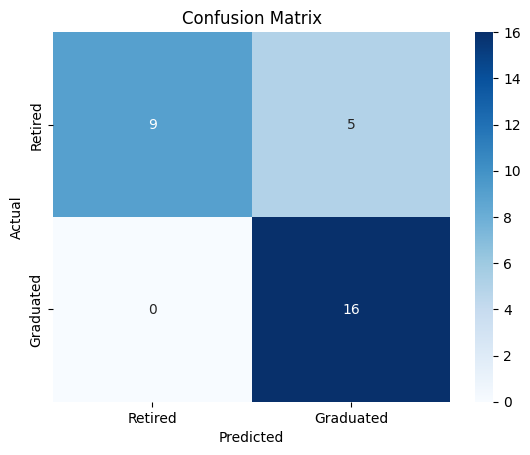

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 1 - Train Loss: 0.6835060864686966 | Train Acc: 0.5428571428571428
Epoch 1 - Val Loss: 0.5570459961891174 | Val Acc: 0.875


Validation Epoch 2/30: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Epoch 2 - Train Loss: 0.5828694552183151 | Train Acc: 0.7047619047619048
Epoch 2 - Val Loss: 0.8401810526847839 | Val Acc: 0.4375


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 3 - Train Loss: 0.6775686591863632 | Train Acc: 0.638095238095238
Epoch 3 - Val Loss: 0.4938347339630127 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 4 - Train Loss: 0.5828943699598312 | Train Acc: 0.6857142857142857
Epoch 4 - Val Loss: 0.5751540064811707 | Val Acc: 0.625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 5 - Train Loss: 0.5708047151565552 | Train Acc: 0.7523809523809524
Epoch 5 - Val Loss: 0.5191295742988586 | Val Acc: 0.75


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 6 - Train Loss: 0.6559376865625381 | Train Acc: 0.6857142857142857
Epoch 6 - Val Loss: 0.4741162359714508 | Val Acc: 0.8125


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Epoch 7 - Train Loss: 0.5335594341158867 | Train Acc: 0.7238095238095238
Epoch 7 - Val Loss: 0.6794010400772095 | Val Acc: 0.6875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Epoch 8 - Train Loss: 0.5457881465554237 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.5120050311088562 | Val Acc: 0.75


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Epoch 9 - Train Loss: 0.5368725284934044 | Train Acc: 0.7333333333333333
Epoch 9 - Val Loss: 0.47825324535369873 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Epoch 10 - Train Loss: 0.5963124707341194 | Train Acc: 0.7523809523809524
Epoch 10 - Val Loss: 0.49788299202919006 | Val Acc: 0.625


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch 11 - Train Loss: 0.5323452726006508 | Train Acc: 0.7428571428571429
Epoch 11 - Val Loss: 0.5283252000808716 | Val Acc: 0.625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Test Accuracy: 0.7667


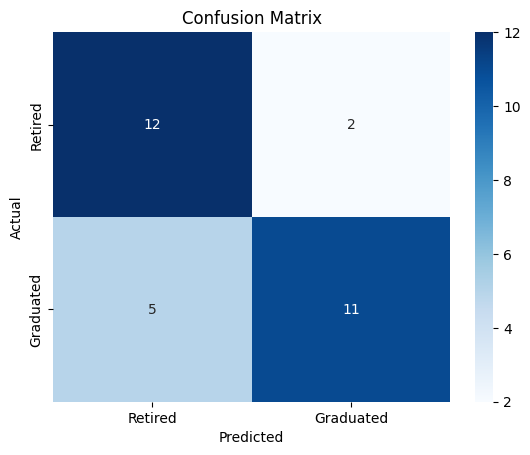

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Epoch 1 - Train Loss: 0.6705575585365295 | Train Acc: 0.5904761904761905
Epoch 1 - Val Loss: 0.6346471905708313 | Val Acc: 0.5625


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 2 - Train Loss: 0.6724407970905304 | Train Acc: 0.6
Epoch 2 - Val Loss: 0.5980367064476013 | Val Acc: 0.625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Epoch 3 - Train Loss: 0.6690182387828827 | Train Acc: 0.5333333333333333
Epoch 3 - Val Loss: 0.5997544527053833 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 4 - Train Loss: 0.6392459571361542 | Train Acc: 0.6190476190476191
Epoch 4 - Val Loss: 0.5849084258079529 | Val Acc: 0.6875


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 5 - Train Loss: 0.5945881903171539 | Train Acc: 0.7047619047619048
Epoch 5 - Val Loss: 0.618944525718689 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Epoch 6 - Train Loss: 0.5725945234298706 | Train Acc: 0.7047619047619048
Epoch 6 - Val Loss: 0.7124320268630981 | Val Acc: 0.625


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 7 - Train Loss: 0.5641623735427856 | Train Acc: 0.6952380952380952
Epoch 7 - Val Loss: 0.6799533367156982 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Epoch 8 - Train Loss: 0.6033339947462082 | Train Acc: 0.7428571428571429
Epoch 8 - Val Loss: 0.6607275605201721 | Val Acc: 0.625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Epoch 9 - Train Loss: 0.5836184918880463 | Train Acc: 0.7333333333333333
Epoch 9 - Val Loss: 0.5539670586585999 | Val Acc: 0.75


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 10 - Train Loss: 0.5881624221801758 | Train Acc: 0.6952380952380952
Epoch 10 - Val Loss: 0.5358574390411377 | Val Acc: 0.8125


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch 11 - Train Loss: 0.5410373955965042 | Train Acc: 0.7523809523809524
Epoch 11 - Val Loss: 0.5368492007255554 | Val Acc: 0.6875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 12 - Train Loss: 0.5273225605487823 | Train Acc: 0.7428571428571429
Epoch 12 - Val Loss: 0.5348012447357178 | Val Acc: 0.625


Validation Epoch 13/30: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 13 - Train Loss: 0.531395822763443 | Train Acc: 0.780952380952381
Epoch 13 - Val Loss: 0.48293793201446533 | Val Acc: 0.8125


Validation Epoch 14/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 14 - Train Loss: 0.4913371354341507 | Train Acc: 0.7523809523809524
Epoch 14 - Val Loss: 0.4657720923423767 | Val Acc: 0.8125


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Epoch 15 - Train Loss: 0.5181115716695786 | Train Acc: 0.7428571428571429
Epoch 15 - Val Loss: 0.46518421173095703 | Val Acc: 0.8125


Validation Epoch 16/30: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Epoch 16 - Train Loss: 0.5247369259595871 | Train Acc: 0.7523809523809524
Epoch 16 - Val Loss: 0.46466416120529175 | Val Acc: 0.875


Validation Epoch 17/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 17 - Train Loss: 0.48777376115322113 | Train Acc: 0.7714285714285715
Epoch 17 - Val Loss: 0.4757591485977173 | Val Acc: 0.875


Validation Epoch 18/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 18 - Train Loss: 0.5108394473791122 | Train Acc: 0.7714285714285715
Epoch 18 - Val Loss: 0.46823650598526 | Val Acc: 0.8125


Validation Epoch 19/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 19 - Train Loss: 0.4971156716346741 | Train Acc: 0.7238095238095238
Epoch 19 - Val Loss: 0.4492757320404053 | Val Acc: 0.8125


Validation Epoch 20/30: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Epoch 20 - Train Loss: 0.5214740335941315 | Train Acc: 0.7904761904761904
Epoch 20 - Val Loss: 0.4333186149597168 | Val Acc: 0.875


Validation Epoch 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Epoch 21 - Train Loss: 0.5226047039031982 | Train Acc: 0.7523809523809524
Epoch 21 - Val Loss: 0.4265924096107483 | Val Acc: 0.875


Validation Epoch 22/30: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 22 - Train Loss: 0.45135706663131714 | Train Acc: 0.780952380952381
Epoch 22 - Val Loss: 0.39716166257858276 | Val Acc: 0.875


Validation Epoch 23/30: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Epoch 23 - Train Loss: 0.44845497608184814 | Train Acc: 0.7714285714285715
Epoch 23 - Val Loss: 0.4024893641471863 | Val Acc: 0.875


Validation Epoch 24/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 24 - Train Loss: 0.4450759142637253 | Train Acc: 0.8
Epoch 24 - Val Loss: 0.37764912843704224 | Val Acc: 0.875


Validation Epoch 25/30: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Epoch 25 - Train Loss: 0.43609142303466797 | Train Acc: 0.819047619047619
Epoch 25 - Val Loss: 0.40319526195526123 | Val Acc: 0.875


Validation Epoch 26/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 26 - Train Loss: 0.4552048444747925 | Train Acc: 0.7904761904761904
Epoch 26 - Val Loss: 0.4120909571647644 | Val Acc: 0.875


Validation Epoch 27/30: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 27 - Train Loss: 0.4432775527238846 | Train Acc: 0.8
Epoch 27 - Val Loss: 0.4524761438369751 | Val Acc: 0.875


Validation Epoch 28/30: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Epoch 28 - Train Loss: 0.42850421369075775 | Train Acc: 0.8285714285714286
Epoch 28 - Val Loss: 0.44244715571403503 | Val Acc: 0.8125


Validation Epoch 29/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 29 - Train Loss: 0.4042211323976517 | Train Acc: 0.8095238095238095
Epoch 29 - Val Loss: 0.4737478494644165 | Val Acc: 0.875
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Test Accuracy: 0.8000


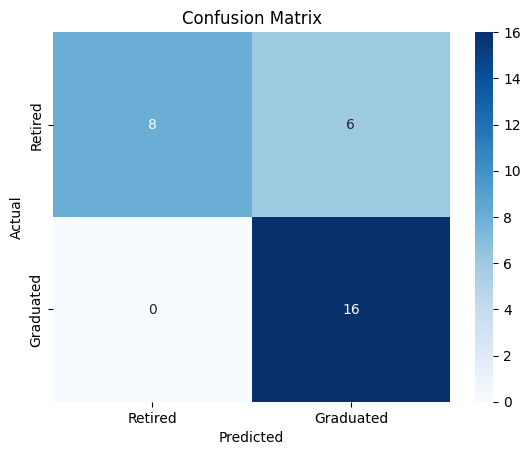

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 1 - Train Loss: 0.8439130783081055 | Train Acc: 0.49523809523809526
Epoch 1 - Val Loss: 0.778382420539856 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 2 - Train Loss: 0.7159161141940525 | Train Acc: 0.49523809523809526
Epoch 2 - Val Loss: 0.7232117652893066 | Val Acc: 0.5625


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 3 - Train Loss: 0.7804349660873413 | Train Acc: 0.44761904761904764
Epoch 3 - Val Loss: 0.689005970954895 | Val Acc: 0.875


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 4 - Train Loss: 0.7073427779333932 | Train Acc: 0.5142857142857142
Epoch 4 - Val Loss: 0.7224214673042297 | Val Acc: 0.5625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 5 - Train Loss: 0.757320727620806 | Train Acc: 0.41904761904761906
Epoch 5 - Val Loss: 0.6879907846450806 | Val Acc: 0.5625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Epoch 6 - Train Loss: 0.7299412403787885 | Train Acc: 0.4857142857142857
Epoch 6 - Val Loss: 0.6985010504722595 | Val Acc: 0.4375


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 7 - Train Loss: 0.698351902621133 | Train Acc: 0.4857142857142857
Epoch 7 - Val Loss: 0.6888144016265869 | Val Acc: 0.5625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Epoch 8 - Train Loss: 0.6741421052387783 | Train Acc: 0.6190476190476191
Epoch 8 - Val Loss: 0.6877301335334778 | Val Acc: 0.5625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Epoch 9 - Train Loss: 0.7068607125963483 | Train Acc: 0.5333333333333333
Epoch 9 - Val Loss: 0.6865502595901489 | Val Acc: 0.5625


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 10 - Train Loss: 0.728179429258619 | Train Acc: 0.45714285714285713
Epoch 10 - Val Loss: 0.7239947319030762 | Val Acc: 0.4375


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 11 - Train Loss: 0.7106018917901176 | Train Acc: 0.4666666666666667
Epoch 11 - Val Loss: 0.6853434443473816 | Val Acc: 0.5625


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 12 - Train Loss: 0.7081636956759861 | Train Acc: 0.5333333333333333
Epoch 12 - Val Loss: 0.6857526302337646 | Val Acc: 0.5625


Validation Epoch 13/30: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch 13 - Train Loss: 0.7104587129184178 | Train Acc: 0.49523809523809526
Epoch 13 - Val Loss: 0.6872974634170532 | Val Acc: 0.5625


Validation Epoch 14/30: 100%|██████████| 1/1 [00:02<00:00,  2.00s/it]


Epoch 14 - Train Loss: 0.7045032637459892 | Train Acc: 0.4666666666666667
Epoch 14 - Val Loss: 0.703307569026947 | Val Acc: 0.4375


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Epoch 15 - Train Loss: 0.6973777839115688 | Train Acc: 0.4666666666666667
Epoch 15 - Val Loss: 0.6919021010398865 | Val Acc: 0.5625


Validation Epoch 16/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 16 - Train Loss: 0.7012330719402858 | Train Acc: 0.4857142857142857
Epoch 16 - Val Loss: 0.6875969171524048 | Val Acc: 0.5625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Test Accuracy: 0.5333


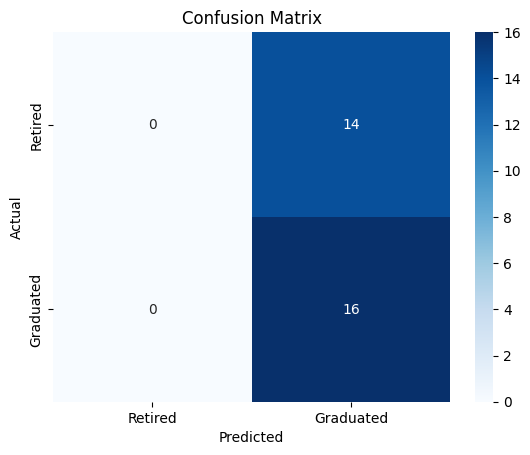

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 1 - Train Loss: 0.7571612894535065 | Train Acc: 0.47619047619047616
Epoch 1 - Val Loss: 0.7113125324249268 | Val Acc: 0.4375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 2 - Train Loss: 0.7085904777050018 | Train Acc: 0.49523809523809526
Epoch 2 - Val Loss: 0.6504934430122375 | Val Acc: 0.8125


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 3 - Train Loss: 0.651206374168396 | Train Acc: 0.638095238095238
Epoch 3 - Val Loss: 0.7872597575187683 | Val Acc: 0.4375


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 4 - Train Loss: 0.718610092997551 | Train Acc: 0.5047619047619047
Epoch 4 - Val Loss: 0.6588781476020813 | Val Acc: 0.625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 5 - Train Loss: 0.6588954627513885 | Train Acc: 0.580952380952381
Epoch 5 - Val Loss: 0.5940936803817749 | Val Acc: 0.875


Validation Epoch 6/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 6 - Train Loss: 0.6230951100587845 | Train Acc: 0.6285714285714286
Epoch 6 - Val Loss: 0.4760916531085968 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 7 - Train Loss: 0.7185671478509903 | Train Acc: 0.6095238095238096
Epoch 7 - Val Loss: 0.5332219004631042 | Val Acc: 0.6875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 8 - Train Loss: 0.6377507448196411 | Train Acc: 0.6095238095238096
Epoch 8 - Val Loss: 0.5660161375999451 | Val Acc: 0.875


Validation Epoch 9/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 9 - Train Loss: 0.6114221960306168 | Train Acc: 0.6476190476190476
Epoch 9 - Val Loss: 0.4843897819519043 | Val Acc: 0.8125


Validation Epoch 10/30: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Epoch 10 - Train Loss: 0.6011019796133041 | Train Acc: 0.7142857142857143
Epoch 10 - Val Loss: 0.4614435136318207 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 11 - Train Loss: 0.6502498611807823 | Train Acc: 0.7142857142857143
Epoch 11 - Val Loss: 0.5099785923957825 | Val Acc: 0.8125


Validation Epoch 12/30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 12 - Train Loss: 0.5642885714769363 | Train Acc: 0.7333333333333333
Epoch 12 - Val Loss: 0.724652886390686 | Val Acc: 0.5


Validation Epoch 13/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 13 - Train Loss: 0.6386762261390686 | Train Acc: 0.6
Epoch 13 - Val Loss: 0.49300453066825867 | Val Acc: 0.875


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Epoch 14 - Train Loss: 0.5858391523361206 | Train Acc: 0.7238095238095238
Epoch 14 - Val Loss: 0.41942912340164185 | Val Acc: 0.875


Validation Epoch 15/30: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 15 - Train Loss: 0.5306556597352028 | Train Acc: 0.7523809523809524
Epoch 15 - Val Loss: 0.40801680088043213 | Val Acc: 0.875


Validation Epoch 16/30: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Epoch 16 - Train Loss: 0.45258332788944244 | Train Acc: 0.7904761904761904
Epoch 16 - Val Loss: 0.3976745307445526 | Val Acc: 0.875


Validation Epoch 17/30: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Epoch 17 - Train Loss: 0.576234757900238 | Train Acc: 0.780952380952381
Epoch 17 - Val Loss: 0.47037273645401 | Val Acc: 0.8125


Validation Epoch 18/30: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 18 - Train Loss: 0.5851735770702362 | Train Acc: 0.7428571428571429
Epoch 18 - Val Loss: 0.45428454875946045 | Val Acc: 0.8125


Validation Epoch 19/30: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch 19 - Train Loss: 0.6169198974967003 | Train Acc: 0.7428571428571429
Epoch 19 - Val Loss: 0.5958701968193054 | Val Acc: 0.6875


Validation Epoch 20/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 20 - Train Loss: 0.5400713682174683 | Train Acc: 0.7142857142857143
Epoch 20 - Val Loss: 0.5147819519042969 | Val Acc: 0.875


Validation Epoch 21/30: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch 21 - Train Loss: 0.4805716797709465 | Train Acc: 0.8095238095238095
Epoch 21 - Val Loss: 0.45916512608528137 | Val Acc: 0.75
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Test Accuracy: 0.7667


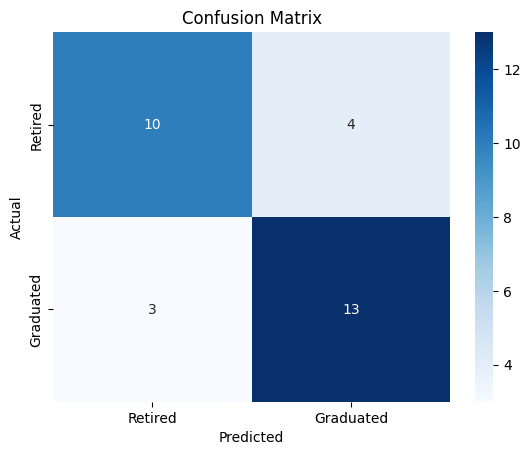

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Epoch 1 - Train Loss: 0.7693398296833038 | Train Acc: 0.49523809523809526
Epoch 1 - Val Loss: 0.7142853140830994 | Val Acc: 0.5


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch 2 - Train Loss: 0.7194767594337463 | Train Acc: 0.4
Epoch 2 - Val Loss: 0.6953321099281311 | Val Acc: 0.4375


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Epoch 3 - Train Loss: 0.705872505903244 | Train Acc: 0.5333333333333333
Epoch 3 - Val Loss: 0.6753954887390137 | Val Acc: 0.5625


Validation Epoch 4/30: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Epoch 4 - Train Loss: 0.6638356149196625 | Train Acc: 0.6095238095238096
Epoch 4 - Val Loss: 0.7194523811340332 | Val Acc: 0.5625


Validation Epoch 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


Epoch 5 - Train Loss: 0.7204238176345825 | Train Acc: 0.5047619047619047
Epoch 5 - Val Loss: 0.6725730895996094 | Val Acc: 0.625


Validation Epoch 6/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 6 - Train Loss: 0.6585798561573029 | Train Acc: 0.5904761904761905
Epoch 6 - Val Loss: 0.6507574915885925 | Val Acc: 0.75


Validation Epoch 7/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 7 - Train Loss: 0.6980182826519012 | Train Acc: 0.5333333333333333
Epoch 7 - Val Loss: 0.6498756408691406 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Epoch 8 - Train Loss: 0.6532520353794098 | Train Acc: 0.6095238095238096
Epoch 8 - Val Loss: 0.6706116199493408 | Val Acc: 0.625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch 9 - Train Loss: 0.6283951103687286 | Train Acc: 0.6476190476190476
Epoch 9 - Val Loss: 0.7076717615127563 | Val Acc: 0.625


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Epoch 10 - Train Loss: 0.5817842781543732 | Train Acc: 0.7333333333333333
Epoch 10 - Val Loss: 0.5178570747375488 | Val Acc: 0.75


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 11 - Train Loss: 0.6529206037521362 | Train Acc: 0.6666666666666666
Epoch 11 - Val Loss: 0.5738334059715271 | Val Acc: 0.75


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Epoch 12 - Train Loss: 0.668420821428299 | Train Acc: 0.7047619047619048
Epoch 12 - Val Loss: 0.8107749223709106 | Val Acc: 0.4375


Validation Epoch 13/30: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch 13 - Train Loss: 0.6799026131629944 | Train Acc: 0.5714285714285714
Epoch 13 - Val Loss: 0.6810125708580017 | Val Acc: 0.625


Validation Epoch 14/30: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 14 - Train Loss: 0.6729818880558014 | Train Acc: 0.580952380952381
Epoch 14 - Val Loss: 0.6764639616012573 | Val Acc: 0.5625


Validation Epoch 15/30: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Epoch 15 - Train Loss: 0.7131805717945099 | Train Acc: 0.5619047619047619
Epoch 15 - Val Loss: 0.697638750076294 | Val Acc: 0.5625
Early stopping triggered.
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Test Accuracy: 0.5333


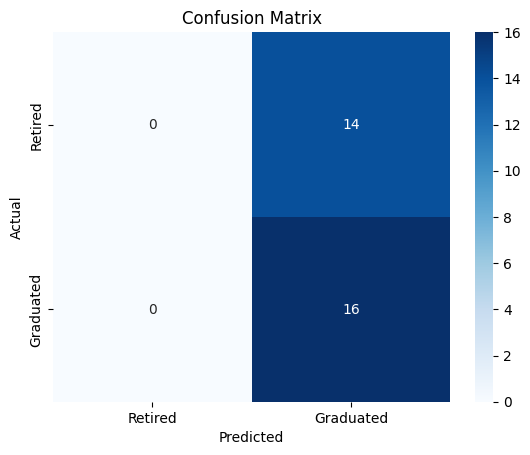

In [23]:
for i in range(40, len(hyperparameter_combinations)):
  hyperparameters = hyperparameter_combinations[i]
  execute_hyperparameter_combination(
      hyperparameters['dropout'],
      hyperparameters['weight_decay'],
      hyperparameters['learning_rate'],
      hyperparameters['batch_size']
  )

In [24]:
print("\n*** Best Hyperparameters ***")
print(
    f"Dropout: {best_hyperparams[0]}, Weight Decay: {best_hyperparams[1]}, Learning Rate: {best_hyperparams[2]}, Batch Size: {best_hyperparams[3]}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")


*** Best Hyperparameters ***
Dropout: 0.1, Weight Decay: 0, Learning Rate: 0.0002, Batch Size: 64
Best Test Accuracy: 0.8667


# k-fold cross validation on best hyperparameters

Using device: cuda
Fold 1/5 - Training with dropout=0.1, weight_decay=0, lr=0.0002, batch_size=64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/han/.local/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validation Epoch 1/30: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 1 - Train Loss: 0.7281450033187866 | Train Acc: 0.4583333333333333
Epoch 1 - Val Loss: 0.7414930462837219 | Val Acc: 0.5


Validation Epoch 2/30: 100%|██████████| 1/1 [00:05<00:00,  5.56s/it]


Epoch 2 - Train Loss: 0.7559063136577606 | Train Acc: 0.46875
Epoch 2 - Val Loss: 0.687694251537323 | Val Acc: 0.5


Validation Epoch 3/30: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Epoch 3 - Train Loss: 0.7045813500881195 | Train Acc: 0.4479166666666667
Epoch 3 - Val Loss: 0.6503670811653137 | Val Acc: 0.5


Validation Epoch 4/30: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Epoch 4 - Train Loss: 0.6326923668384552 | Train Acc: 0.5833333333333334
Epoch 4 - Val Loss: 0.7770245671272278 | Val Acc: 0.5833333333333334


Validation Epoch 5/30: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Epoch 5 - Train Loss: 0.69256991147995 | Train Acc: 0.5520833333333334
Epoch 5 - Val Loss: 0.7095463275909424 | Val Acc: 0.5416666666666666


Validation Epoch 6/30: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch 6 - Train Loss: 0.6440400183200836 | Train Acc: 0.6458333333333334
Epoch 6 - Val Loss: 0.8322782516479492 | Val Acc: 0.5


Validation Epoch 7/30: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


Epoch 7 - Train Loss: 0.6661498546600342 | Train Acc: 0.6458333333333334
Epoch 7 - Val Loss: 0.6401671171188354 | Val Acc: 0.625


Validation Epoch 8/30: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Epoch 8 - Train Loss: 0.7350489795207977 | Train Acc: 0.5625
Epoch 8 - Val Loss: 0.5697842836380005 | Val Acc: 0.75


Validation Epoch 9/30: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


Epoch 9 - Train Loss: 0.6110906302928925 | Train Acc: 0.6979166666666666
Epoch 9 - Val Loss: 0.628591001033783 | Val Acc: 0.6666666666666666


Validation Epoch 10/30: 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]


Epoch 10 - Train Loss: 0.6032520830631256 | Train Acc: 0.7291666666666666
Epoch 10 - Val Loss: 0.6677841544151306 | Val Acc: 0.5833333333333334


Validation Epoch 11/30: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Epoch 11 - Train Loss: 0.5893946290016174 | Train Acc: 0.6770833333333334
Epoch 11 - Val Loss: 0.6472070813179016 | Val Acc: 0.5833333333333334


Validation Epoch 12/30: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


Epoch 12 - Train Loss: 0.5820188820362091 | Train Acc: 0.71875
Epoch 12 - Val Loss: 0.6364597678184509 | Val Acc: 0.5833333333333334


Validation Epoch 13/30: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


Epoch 13 - Train Loss: 0.5616161525249481 | Train Acc: 0.75
Epoch 13 - Val Loss: 0.5961558222770691 | Val Acc: 0.7083333333333334
Early stopping triggered.
Fold 2/5 - Training with dropout=0.1, weight_decay=0, lr=0.0002, batch_size=64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Epoch 1/30: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Epoch 1 - Train Loss: 0.7544328570365906 | Train Acc: 0.46875
Epoch 1 - Val Loss: 0.7118814587593079 | Val Acc: 0.375


Validation Epoch 2/30: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


Epoch 2 - Train Loss: 0.6969600319862366 | Train Acc: 0.5104166666666666
Epoch 2 - Val Loss: 0.663894534111023 | Val Acc: 0.75


Validation Epoch 3/30: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


Epoch 3 - Train Loss: 0.6957458257675171 | Train Acc: 0.5833333333333334
Epoch 3 - Val Loss: 0.6098281741142273 | Val Acc: 0.8333333333333334


Validation Epoch 4/30: 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


Epoch 4 - Train Loss: 0.6573407351970673 | Train Acc: 0.6666666666666666
Epoch 4 - Val Loss: 0.5271211266517639 | Val Acc: 0.8333333333333334


Validation Epoch 5/30: 100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


Epoch 5 - Train Loss: 0.6412217319011688 | Train Acc: 0.6666666666666666
Epoch 5 - Val Loss: 0.6121202111244202 | Val Acc: 0.6666666666666666


Validation Epoch 6/30: 100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


Epoch 6 - Train Loss: 0.6503197550773621 | Train Acc: 0.6041666666666666
Epoch 6 - Val Loss: 0.4963010847568512 | Val Acc: 0.875


Validation Epoch 7/30: 100%|██████████| 1/1 [00:09<00:00,  9.26s/it]


Epoch 7 - Train Loss: 0.5913686752319336 | Train Acc: 0.6979166666666666
Epoch 7 - Val Loss: 0.46141016483306885 | Val Acc: 0.875


Validation Epoch 8/30: 100%|██████████| 1/1 [00:09<00:00,  9.32s/it]


Epoch 8 - Train Loss: 0.5705639719963074 | Train Acc: 0.7083333333333334
Epoch 8 - Val Loss: 0.517122209072113 | Val Acc: 0.7916666666666666


Validation Epoch 9/30: 100%|██████████| 1/1 [00:05<00:00,  5.07s/it]


Epoch 9 - Train Loss: 0.5833710134029388 | Train Acc: 0.7291666666666666
Epoch 9 - Val Loss: 0.46454837918281555 | Val Acc: 0.875


Validation Epoch 10/30: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


Epoch 10 - Train Loss: 0.5419521629810333 | Train Acc: 0.7291666666666666
Epoch 10 - Val Loss: 0.4719620645046234 | Val Acc: 0.875


Validation Epoch 11/30: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


Epoch 11 - Train Loss: 0.5693159699440002 | Train Acc: 0.71875
Epoch 11 - Val Loss: 0.46227899193763733 | Val Acc: 0.875


Validation Epoch 12/30: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Epoch 12 - Train Loss: 0.5975126624107361 | Train Acc: 0.6979166666666666
Epoch 12 - Val Loss: 0.5349041819572449 | Val Acc: 0.7916666666666666
Early stopping triggered.
Fold 3/5 - Training with dropout=0.1, weight_decay=0, lr=0.0002, batch_size=64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Epoch 1/30: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Epoch 1 - Train Loss: 0.7095976173877716 | Train Acc: 0.5
Epoch 1 - Val Loss: 0.6672172546386719 | Val Acc: 0.5416666666666666


Validation Epoch 2/30: 100%|██████████| 1/1 [00:05<00:00,  5.13s/it]


Epoch 2 - Train Loss: 0.748487800359726 | Train Acc: 0.5416666666666666
Epoch 2 - Val Loss: 0.6842436194419861 | Val Acc: 0.5416666666666666


Validation Epoch 3/30: 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]


Epoch 3 - Train Loss: 0.7060912847518921 | Train Acc: 0.59375
Epoch 3 - Val Loss: 0.6950843930244446 | Val Acc: 0.5416666666666666


Validation Epoch 4/30: 100%|██████████| 1/1 [00:05<00:00,  5.40s/it]


Epoch 4 - Train Loss: 0.6528906524181366 | Train Acc: 0.6354166666666666
Epoch 4 - Val Loss: 0.6275297403335571 | Val Acc: 0.7083333333333334


Validation Epoch 5/30: 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


Epoch 5 - Train Loss: 0.5459819436073303 | Train Acc: 0.71875
Epoch 5 - Val Loss: 0.5696113705635071 | Val Acc: 0.7083333333333334


Validation Epoch 6/30: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


Epoch 6 - Train Loss: 0.5469944179058075 | Train Acc: 0.7604166666666666
Epoch 6 - Val Loss: 0.504551351070404 | Val Acc: 0.75


Validation Epoch 7/30: 100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


Epoch 7 - Train Loss: 0.5216242969036102 | Train Acc: 0.7708333333333334
Epoch 7 - Val Loss: 0.5024754405021667 | Val Acc: 0.75


Validation Epoch 8/30: 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


Epoch 8 - Train Loss: 0.5119322538375854 | Train Acc: 0.7604166666666666
Epoch 8 - Val Loss: 0.5528153777122498 | Val Acc: 0.7083333333333334


Validation Epoch 9/30: 100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


Epoch 9 - Train Loss: 0.5256569087505341 | Train Acc: 0.7916666666666666
Epoch 9 - Val Loss: 0.5375471115112305 | Val Acc: 0.75


Validation Epoch 10/30: 100%|██████████| 1/1 [00:06<00:00,  6.84s/it]


Epoch 10 - Train Loss: 0.4990379810333252 | Train Acc: 0.78125
Epoch 10 - Val Loss: 0.5466315150260925 | Val Acc: 0.7083333333333334


Validation Epoch 11/30: 100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


Epoch 11 - Train Loss: 0.4458675682544708 | Train Acc: 0.8020833333333334
Epoch 11 - Val Loss: 0.5974991917610168 | Val Acc: 0.7083333333333334


Validation Epoch 12/30: 100%|██████████| 1/1 [00:08<00:00,  8.28s/it]


Epoch 12 - Train Loss: 0.6503783762454987 | Train Acc: 0.7291666666666666
Epoch 12 - Val Loss: 0.4903675317764282 | Val Acc: 0.75


Validation Epoch 13/30: 100%|██████████| 1/1 [00:08<00:00,  8.10s/it]


Epoch 13 - Train Loss: 0.5436048656702042 | Train Acc: 0.78125
Epoch 13 - Val Loss: 0.5218018889427185 | Val Acc: 0.7916666666666666


Validation Epoch 14/30: 100%|██████████| 1/1 [00:08<00:00,  8.00s/it]


Epoch 14 - Train Loss: 0.5135754644870758 | Train Acc: 0.7708333333333334
Epoch 14 - Val Loss: 0.5659963488578796 | Val Acc: 0.7083333333333334


Validation Epoch 15/30: 100%|██████████| 1/1 [00:09<00:00,  9.29s/it]


Epoch 15 - Train Loss: 0.5310291349887848 | Train Acc: 0.7604166666666666
Epoch 15 - Val Loss: 0.5277597308158875 | Val Acc: 0.75


Validation Epoch 16/30: 100%|██████████| 1/1 [00:17<00:00, 17.60s/it]


Epoch 16 - Train Loss: 0.46054576337337494 | Train Acc: 0.8125
Epoch 16 - Val Loss: 0.48979416489601135 | Val Acc: 0.7916666666666666


Validation Epoch 17/30: 100%|██████████| 1/1 [00:11<00:00, 11.89s/it]


Epoch 17 - Train Loss: 0.42690177261829376 | Train Acc: 0.8229166666666666
Epoch 17 - Val Loss: 0.6659416556358337 | Val Acc: 0.75


Validation Epoch 18/30: 100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


Epoch 18 - Train Loss: 0.5779541730880737 | Train Acc: 0.7916666666666666
Epoch 18 - Val Loss: 0.9099125862121582 | Val Acc: 0.5833333333333334


Validation Epoch 19/30: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


Epoch 19 - Train Loss: 0.7386549711227417 | Train Acc: 0.6666666666666666
Epoch 19 - Val Loss: 0.6971157193183899 | Val Acc: 0.5833333333333334


Validation Epoch 20/30: 100%|██████████| 1/1 [00:11<00:00, 11.50s/it]


Epoch 20 - Train Loss: 0.6330035328865051 | Train Acc: 0.6979166666666666
Epoch 20 - Val Loss: 0.5992874503135681 | Val Acc: 0.75


Validation Epoch 21/30: 100%|██████████| 1/1 [00:10<00:00, 10.77s/it]


Epoch 21 - Train Loss: 0.5574423670768738 | Train Acc: 0.7083333333333334
Epoch 21 - Val Loss: 0.5569999814033508 | Val Acc: 0.75
Early stopping triggered.
Fold 4/5 - Training with dropout=0.1, weight_decay=0, lr=0.0002, batch_size=64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Epoch 1/30: 100%|██████████| 1/1 [00:08<00:00,  8.20s/it]


Epoch 1 - Train Loss: 0.7170933485031128 | Train Acc: 0.53125
Epoch 1 - Val Loss: 0.7501835823059082 | Val Acc: 0.5


Validation Epoch 2/30: 100%|██████████| 1/1 [00:08<00:00,  8.60s/it]


Epoch 2 - Train Loss: 0.6771657168865204 | Train Acc: 0.5625
Epoch 2 - Val Loss: 0.685481607913971 | Val Acc: 0.5


Validation Epoch 3/30: 100%|██████████| 1/1 [00:10<00:00, 10.17s/it]


Epoch 3 - Train Loss: 0.5950170457363129 | Train Acc: 0.65625
Epoch 3 - Val Loss: 0.7552996277809143 | Val Acc: 0.5833333333333334


Validation Epoch 4/30: 100%|██████████| 1/1 [00:09<00:00,  9.26s/it]


Epoch 4 - Train Loss: 0.6571804583072662 | Train Acc: 0.6145833333333334
Epoch 4 - Val Loss: 0.5912355780601501 | Val Acc: 0.6666666666666666


Validation Epoch 5/30: 100%|██████████| 1/1 [00:11<00:00, 11.72s/it]


Epoch 5 - Train Loss: 0.6426479816436768 | Train Acc: 0.71875
Epoch 5 - Val Loss: 0.6042932868003845 | Val Acc: 0.7083333333333334


Validation Epoch 6/30: 100%|██████████| 1/1 [00:09<00:00,  9.47s/it]


Epoch 6 - Train Loss: 0.6373560130596161 | Train Acc: 0.6979166666666666
Epoch 6 - Val Loss: 0.5891112685203552 | Val Acc: 0.75


Validation Epoch 7/30: 100%|██████████| 1/1 [00:09<00:00,  9.65s/it]


Epoch 7 - Train Loss: 0.5581973791122437 | Train Acc: 0.78125
Epoch 7 - Val Loss: 0.5820096135139465 | Val Acc: 0.7083333333333334


Validation Epoch 8/30: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Epoch 8 - Train Loss: 0.48527994751930237 | Train Acc: 0.7916666666666666
Epoch 8 - Val Loss: 0.6099014282226562 | Val Acc: 0.75


Validation Epoch 9/30: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


Epoch 9 - Train Loss: 0.5062961429357529 | Train Acc: 0.78125
Epoch 9 - Val Loss: 0.5782086253166199 | Val Acc: 0.6666666666666666


Validation Epoch 10/30: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


Epoch 10 - Train Loss: 0.4761716276407242 | Train Acc: 0.78125
Epoch 10 - Val Loss: 0.621580183506012 | Val Acc: 0.6666666666666666


Validation Epoch 11/30: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


Epoch 11 - Train Loss: 0.44560056924819946 | Train Acc: 0.8020833333333334
Epoch 11 - Val Loss: 0.6236954927444458 | Val Acc: 0.6666666666666666


Validation Epoch 12/30: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Epoch 12 - Train Loss: 0.4336092174053192 | Train Acc: 0.78125
Epoch 12 - Val Loss: 0.5788081288337708 | Val Acc: 0.7083333333333334


Validation Epoch 13/30: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


Epoch 13 - Train Loss: 0.48221494257450104 | Train Acc: 0.8125
Epoch 13 - Val Loss: 0.5921729803085327 | Val Acc: 0.6666666666666666


Validation Epoch 14/30: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Epoch 14 - Train Loss: 0.43830354511737823 | Train Acc: 0.8125
Epoch 14 - Val Loss: 0.6295009255409241 | Val Acc: 0.7083333333333334
Early stopping triggered.
Fold 5/5 - Training with dropout=0.1, weight_decay=0, lr=0.0002, batch_size=64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Epoch 1/30: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch 1 - Train Loss: 0.7148449718952179 | Train Acc: 0.4791666666666667
Epoch 1 - Val Loss: 0.7107087969779968 | Val Acc: 0.5


Validation Epoch 2/30: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Epoch 2 - Train Loss: 0.7347574830055237 | Train Acc: 0.4479166666666667
Epoch 2 - Val Loss: 0.6853054165840149 | Val Acc: 0.4583333333333333


Validation Epoch 3/30: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Epoch 3 - Train Loss: 0.6324581205844879 | Train Acc: 0.6875
Epoch 3 - Val Loss: 0.6859371662139893 | Val Acc: 0.4583333333333333


Validation Epoch 4/30: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Epoch 4 - Train Loss: 0.6335408687591553 | Train Acc: 0.65625
Epoch 4 - Val Loss: 0.6512971520423889 | Val Acc: 0.7083333333333334


Validation Epoch 5/30: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Epoch 5 - Train Loss: 0.5836472511291504 | Train Acc: 0.65625
Epoch 5 - Val Loss: 0.7056064009666443 | Val Acc: 0.5833333333333334


Validation Epoch 6/30: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Epoch 6 - Train Loss: 0.5748847424983978 | Train Acc: 0.7604166666666666
Epoch 6 - Val Loss: 0.6818394660949707 | Val Acc: 0.5833333333333334


Validation Epoch 7/30: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


Epoch 7 - Train Loss: 0.5489091575145721 | Train Acc: 0.7708333333333334
Epoch 7 - Val Loss: 0.8042430877685547 | Val Acc: 0.5416666666666666


Validation Epoch 8/30: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Epoch 8 - Train Loss: 0.5349959135055542 | Train Acc: 0.75
Epoch 8 - Val Loss: 0.7115283608436584 | Val Acc: 0.625


Validation Epoch 9/30: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Epoch 9 - Train Loss: 0.4859683960676193 | Train Acc: 0.7916666666666666
Epoch 9 - Val Loss: 0.7712070941925049 | Val Acc: 0.5833333333333334
Early stopping triggered.
Avg Validation Accuracy for dropout=0.1, weight_decay=0, lr=0.0002, batch_size=64: 0.7083333333333334
Final evaluation on test set...


Testing: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]



Test Accuracy: 0.6774


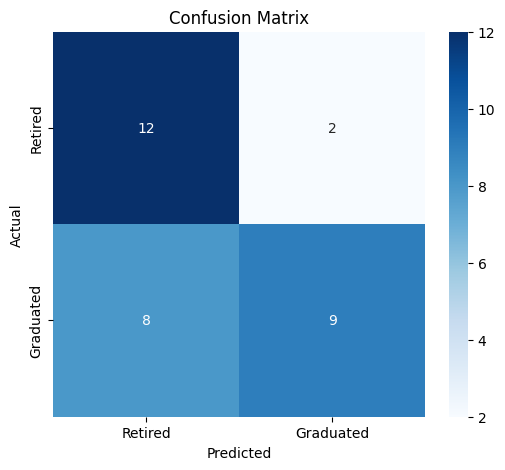

In [7]:
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data Preprocessing
max_length = max(df.shape[0] for df in cleaned_data_transformer.values())

data = []
labels = []

for project, df in cleaned_data_transformer.items():
  text = df.drop(columns=['status']).astype(str).agg(' '.join, axis=1).tolist()
  label = df['status'].iloc[0]
  labels.append(label)
  while len(text) < max_length:
    text.append("PAD")
  data.append(" ".join(text))

# Retired=0, Graduated=1
labels = [0 if label == 'Retired' else 1 for label in labels]

# Split the data into 80% training and 20% test using stratification
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42, shuffle=True)

# Custom Dataset Class


class ProjectDataset(Dataset):
  def __init__(self, data, labels, tokenizer, max_length):
    self.data = data
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, item):
    text = self.data[item]
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
    }

# Training function with early stopping


def train_model(model, train_loader, val_loader, optimizer, epochs=30, patience=5):
  best_val_loss = float('inf')
  patience_counter = 0

  for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
      optimizer.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = model(input_ids=input_ids,
                      attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      logits = outputs.logits

      total_train_loss += loss.item()
      _, predicted = torch.max(logits, dim=1)
      correct_train += (predicted == labels).sum().item()
      total_train += labels.size(0)

      loss.backward()
      optimizer.step()

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0

    with torch.no_grad():
      for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask, labels=labels)
        val_loss += outputs.loss.item()

        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)
        correct_val += (predicted == labels).sum().item()
        total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val
    print(f"Epoch {epoch+1} - Train Loss: {total_train_loss/len(train_loader)} | Train Acc: {correct_train/total_train}")
    print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss} | Val Acc: {val_acc}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print("Early stopping triggered.")
        break

  return val_acc  # Return validation accuracy for this fold


# Hyperparameter tuning loops with K-Fold Cross Validation
k_folds = 5  # Number of cross-validation folds
train_dataset = ProjectDataset(X_train, y_train, tokenizer, max_length)
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Hyperparameter tuning function


def execute_hyperparameter_combination(dropout, weight_decay, lr, batch_size):
  fold_accs = []
  for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold+1}/{k_folds} - Training with dropout={dropout}, weight_decay={weight_decay}, lr={lr}, batch_size={batch_size}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        hidden_dropout_prob=dropout,
        attention_probs_dropout_prob=dropout
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr,
                      weight_decay=weight_decay)

    fold_acc = train_model(
        model, train_loader, val_loader, optimizer, epochs=30)
    fold_accs.append(fold_acc)

  avg_acc = np.mean(fold_accs)
  print(
      f"Avg Validation Accuracy for dropout={dropout}, weight_decay={weight_decay}, lr={lr}, batch_size={batch_size}: {avg_acc}")

  # Final testing on the fixed test set
  print("Final evaluation on test set...")
  model.eval()
  test_dataset = ProjectDataset(X_test, y_test, tokenizer, max_length)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  all_preds = []
  all_labels = []

  with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      _, predicted = torch.max(logits, dim=1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  test_acc = accuracy_score(all_labels, all_preds)
  print(f"\nTest Accuracy: {test_acc:.4f}")

  # Plot confusion matrix
  conf_matrix = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(6, 5))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[
              "Retired", "Graduated"], yticklabels=["Retired", "Graduated"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()


# Execute hyperparameter search
execute_hyperparameter_combination(
    0.1,
    0,
    0.0002,
    64
)